In [1]:
%matplotlib notebook

from collections import Counter
import dill
import glob
import igraph as ig
import itertools
import leidenalg
#import magic
import matplotlib
from matplotlib import pyplot
import numba
import numpy
import os
import pickle
from plumbum import local
import random
import re
import scipy
from scipy.cluster import hierarchy
import scipy.sparse as sps
from scipy.spatial import distance
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import neighbors
from sklearn import metrics
import sys
import umap

#from plotly import tools
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)

src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def find_nearest_genes(peak_files, out_subdir, refseq_exon_bed):
    #get unix utilities
    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']

    #process the peak files to find nearest genes
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)
    return nearest_genes

def load_expr_db(db_path):
    if os.path.basename(db_path) == 'RepAvgGeneTPM.csv':
        with open(db_path) as lines_in:
            db_headers = lines_in.readline().strip().split(',')[1:]
        db_vals = numpy.loadtxt(db_path, delimiter=',', skiprows=1, dtype=object)[:,1:]
    else:
        with open(db_path) as lines_in:
            db_headers = lines_in.readline().strip().split('\t')
        db_vals = numpy.loadtxt(db_path, delimiter='\t', skiprows=1, dtype=object)
    print('Loaded DB shape: {!s}'.format(db_vals.shape))
    return (db_headers, db_vals)

TOPN=500
def get_gene_data(genes_path, gene_expr_db, topn=TOPN):
    if isinstance(genes_path, list):
        genes_list = genes_path
    else:
        with open(genes_path) as lines_in:
            genes_list = [elt.strip().split()[:2] for elt in lines_in]
    gene_idx = [(numpy.where(gene_expr_db[:,0] == elt[0])[0],elt[1]) for elt in genes_list]
    gene_idx_sorted = sorted(gene_idx, key=lambda x:float(x[1]), reverse=True)
    gene_idx, gene_weights = zip(*[elt for elt in gene_idx_sorted if len(elt[0]) > 0][:topn])
    gene_idx = [elt[0] for elt in gene_idx]
    gene_data = gene_expr_db[:,1:].astype(float)[gene_idx,:]
    denom = numpy.sum(gene_data, axis=1)[:,None] + 1e-8
    gene_norm = gene_data/denom
    return gene_idx, gene_data, gene_norm, len(genes_list), numpy.array(gene_weights, dtype=float)

def sample_db(data_norm, expr_db, data_weights=None, nsamples=1000):
    samples = []
    rs = numpy.random.RandomState(15321)
    random_subset = numpy.arange(expr_db.shape[0])
    num_to_select = data_norm.shape[0]
    for idx in range(nsamples):
        rs.shuffle(random_subset)
        db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
        denom = numpy.sum(db_subset, axis=1)[:None] + 1e-8
        db_subset_norm = numpy.mean((db_subset.T/denom).T, axis=0)
        if data_weights is not None:
            samples.append(numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/db_subset_norm))
        else:
            samples.append(numpy.log2(numpy.average(data_norm, axis=0, weights=None)/db_subset_norm))
    samples = numpy.vstack(samples)
    samples_mean = numpy.mean(samples, axis=0)
    samples_sem = stats.sem(samples, axis=0)
    conf_int = numpy.array([stats.t.interval(0.95, samples.shape[0]-1, 
                                             loc=samples_mean[idx], scale=samples_sem[idx])
                            for idx in range(samples.shape[1])]).T
    conf_int[0] = samples_mean - conf_int[0]
    conf_int[1] = conf_int[1] - samples_mean
    return samples_mean, conf_int

def plot_l2_tissues(nearest_genes_glob, refdata, expr_db=None, expr_db_headers=None, ncols=3, 
                    topn=TOPN, weights=False, nsamples=100, savefile=None, display_in_notebook=True):
    if expr_db is None:
        #Get all L2 tissue expression data to normalize the distribution of genes from peaks
        l2_tissue_db_path = os.path.join(refdata,'gexplore_l2_tissue_expr.txt')
        expr_db_headers, expr_db = load_expr_db(l2_tissue_db_path)
    
    gene_lists = glob.glob(nearest_genes_glob)
    if os.path.basename(gene_lists[0]).startswith('peaks'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[0].replace('peaks', '')))
    elif os.path.basename(gene_lists[0]).startswith('topic'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[1].replace('rank', '')))
    else:
        gene_lists.sort(key=lambda x:os.path.basename(x).split('.')[0])
    gene_list_data = [(os.path.basename(path).split('.')[0], get_gene_data(path, expr_db, topn=topn)) for path in gene_lists]
    print('\n'.join(['{!s} nearest genes: found {!s} out of {!s} total'.format(fname, data.shape[0], gene_list_len)
                    for (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in gene_list_data]))
    
    l2_tissue_colors = [('Body wall muscle', '#e51a1e'),
                        ('Intestinal/rectal muscle', '#e51a1e'),
                        ('Pharyngeal muscle', '#377db8'),
                        ('Pharyngeal epithelia', '#377db8'),
                        ('Pharyngeal gland', '#377db8'),
                        ('Seam cells', '#4eae4a'),
                        ('Non-seam hypodermis', '#4eae4a'),
                        ('Rectum', '#4eae4a'),
                        ('Ciliated sensory neurons', '#984ea3'),
                        ('Oxygen sensory neurons', '#984ea3'),
                        ('Touch receptor neurons', '#984ea3'),
                        ('Cholinergic neurons', '#984ea3'),
                        ('GABAergic neurons', '#984ea3'),
                        ('Pharyngeal neurons', '#984ea3'),
                        ('flp-1(+) interneurons', '#984ea3'),
                        ('Other interneurons', '#984ea3'),
                        ('Canal associated neurons', '#984ea3'),
                        ('Am/PH sheath cells', '#ff8000'),
                        ('Socket cells', '#ff8000'),
                        ('Excretory cells', '#ff8000'),
                        ('Intestine', '#fcd800'),
                        ('Germline', '#f97fc0'),
                        ('Somatic gonad precursors', '#f97fc0'),
                        ('Distal tip cells', '#f97fc0'),
                        ('Vulval precursors', '#f97fc0'),
                        ('Sex myoblasts', '#f97fc0'),
                        ('Coelomocytes', '#a75629')]
    idx_by_color = {}
    for idx, (name, color) in enumerate(l2_tissue_colors):
        try:
            idx_by_color[color][1].append(idx)
        except KeyError:
            idx_by_color[color] = [name, [idx]]
            
#    rs = numpy.random.RandomState(15321)
#    random_subset = numpy.arange(expr_db.shape[0])
#    rs.shuffle(random_subset)
#    #num_to_select = int(numpy.mean([neuron_data.shape[0], emb_muscle_data.shape[0], l2_muscle_data.shape[0]]))
#    num_to_select = len(random_subset)
#    l2_tissue_db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
#    denom = numpy.sum(l2_tissue_db_subset, axis=1)[:,None] + 1e-8
#    l2_tissue_db_norm = numpy.mean(l2_tissue_db_subset/denom, axis=0)
    print('Tissue DB norm shape: {!s}'.format(expr_db.shape))

    pyplot.rcParams.update({'xtick.labelsize':14,
                            'ytick.labelsize':14,
                            'xtick.major.pad':8})

    ind = numpy.arange(len(expr_db_headers) - 1)
    width = 0.66
    axis_fontsize = 18
    title_fontsize = 19
    nrows = int(numpy.ceil(len(gene_list_data)/float(ncols)))
    fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 7 * nrows), sharey=True)
    for idx, (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in enumerate(gene_list_data):
        ax_idx = (idx//ncols, idx%ncols) if nrows > 1 else idx
#        to_plot = numpy.log2(numpy.mean(data_norm, axis=0)/l2_tissue_db_norm)
#        import pdb; pdb.set_trace()
        if weights is True:
#            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/l2_tissue_db_norm)
            to_plot, errs = sample_db(data_norm, expr_db, data_weights=gene_weights, nsamples=nsamples)
        else:
#            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=None)/l2_tissue_db_norm)
            to_plot, errs = sample_db(data_norm, expr_db, data_weights=None, nsamples=nsamples)
        for idx, (name, color) in enumerate(l2_tissue_colors):
            axes[ax_idx[0],ax_idx[1]].bar(ind[idx], to_plot[idx], width, yerr=errs[:,idx][:,None], color=color, label=name)
        axes[ax_idx[0],ax_idx[1]].axhline(0, color='k')
        axes[ax_idx[0],ax_idx[1]].set_xlim((-1, len(expr_db_headers)))
        axes[ax_idx[0],ax_idx[1]].set_title('{!s}\n({!s} genes)\n'.format(fname, data.shape[0]), fontsize=title_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_ylabel('Log2 ratio of mean expr proportion\n(ATAC targets:Random genes)', fontsize=axis_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_xlabel('L2 tissues', fontsize=axis_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_xticks(ind + width/2)
        axes[ax_idx[0],ax_idx[1]].set_xticklabels([])
    #axes[0].set_xticklabels(expr_db_headers[1:], rotation=90)
    if nrows > 1:
        axes[0,ncols-1].legend(bbox_to_anchor=[1.0,1.0])
    else:
        axes[-1].legend(bbox_to_anchor=[1.0,1.0])

    if display_in_notebook is True:
        fig.tight_layout()
    if savefile is not None:
        fig.savefig(savefile, bbox_inches='tight')

def plot_stages(nearest_genes_glob, refdata, expr_db=None, expr_db_headers=None, ncols=3, topn=TOPN, weights=False):
    if expr_db is None:
        #Get all stages expression data to normalize the distribution of genes from peaks
        stage_db_path = os.path.join(refdata,'gexplore_stage_expr.txt')
        expr_db_headers, expr_db = load_expr_db(stage_db_path)

    gene_lists = glob.glob(nearest_genes_glob)
    if os.path.basename(gene_lists[0]).startswith('peaks'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[0].replace('peaks', '')))
    elif os.path.basename(gene_lists[0]).startswith('topic'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[1].replace('rank', '')))
    else:
        gene_lists.sort(key=lambda x:os.path.basename(x).split('.')[0])
    gene_list_data = [(os.path.basename(path).split('.')[0], get_gene_data(path, expr_db, topn=topn)) for path in gene_lists]
    print('\n'.join(['{!s} nearest genes: found {!s} out of {!s} total'.format(fname, data.shape[0], gene_list_len)
                    for (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in gene_list_data]))
    
    rs = numpy.random.RandomState(15321)
    random_subset = numpy.arange(expr_db.shape[0])
    rs.shuffle(random_subset)
    #num_to_select = int(numpy.mean([neuron_data.shape[0], emb_muscle_data.shape[0], l2_muscle_data.shape[0]]))
    num_to_select = len(random_subset)
    stage_db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
    denom = numpy.sum(stage_db_subset, axis=1)[:,None] + 1e-8
    stage_db_norm = numpy.mean(stage_db_subset/denom, axis=0)
    print('Stage DB norm shape: {!s}'.format(stage_db_norm.shape))

    emb_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
               if elt.endswith('m') or elt == '4-cell']
    larva_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
                 if elt.startswith('L')]
    adult_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:]
                if 'adult' in elt]
    dauer_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:]
                if 'dauer' in elt]
#    rest_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
#                if not elt.endswith('m') and not elt.startswith('L') and elt != '4-cell']

    pyplot.rcParams.update({'xtick.labelsize':20,
                            'ytick.labelsize':20,
                            'xtick.major.pad':8})

    ind = numpy.arange(len(expr_db_headers) - 1)
    width = 0.66
    axis_fontsize = 25
    title_fontsize = 27
    nrows = int(numpy.ceil(len(gene_list_data)/float(ncols)))
    fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 7 * nrows), sharey=True)
    for idx, (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in enumerate(gene_list_data):
        ax_idx = (idx//ncols, idx%ncols) if nrows > 1 else idx
#        to_plot = numpy.log2(numpy.mean(data_norm, axis=0)/stage_db_norm)
        if weights is True:
            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/stage_db_norm)
        else:
            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=None)/stage_db_norm)
        axes[ax_idx].bar(ind[emb_idx], to_plot[emb_idx], width, color='orange', label='Embryo')
        axes[ax_idx].bar(ind[larva_idx], to_plot[larva_idx], width, color='blue', label='Larva')
        axes[ax_idx].bar(ind[adult_idx], to_plot[adult_idx], width, color='red', label='Adult')
        axes[ax_idx].bar(ind[dauer_idx], to_plot[dauer_idx], width, color='green', label='Dauer')
#        axes[ax_idx].bar(ind[rest_idx], to_plot[rest_idx], width, color='grey', label='Other')
        axes[ax_idx].axhline(0, color='k')
        axes[ax_idx].set_xlim((-1, len(expr_db_headers)))
        axes[ax_idx].set_title('{!s}\n({!s} genes)\n'.format(fname, data.shape[0]), fontsize=title_fontsize)
        axes[ax_idx].set_ylabel('Log2 Ratio of Mean Expr Proportion\n(ATAC Targets:All Genes)', fontsize=axis_fontsize)
        axes[ax_idx].set_xlabel('Developmental Stage', fontsize=axis_fontsize)
        axes[ax_idx].set_xticks(ind + width/2)
        axes[ax_idx].set_xticklabels([])

    fig.tight_layout()

def leiden_clustering(umap_res, resolution_range=(0,1), random_state=2, kdtree_dist='euclidean'):
    tree = neighbors.KDTree(umap_res, metric=kdtree_dist)
    vals, i, j = [], [], []
    for idx in range(umap_res.shape[0]):
        dist, ind = tree.query([umap_res[idx]], k=25)
        vals.extend(list(dist.squeeze()))
        j.extend(list(ind.squeeze()))
        i.extend([idx] * len(ind.squeeze()))
    print(len(vals))
    ginput = sps.csc_matrix((numpy.array(vals), (numpy.array(i),numpy.array(j))), 
                            shape=(umap_res.shape[0], umap_res.shape[0]))
    sources, targets = ginput.nonzero()
    edgelist = zip(sources.tolist(), targets.tolist())
    G = ig.Graph(edges=list(edgelist))
    optimiser = leidenalg.Optimiser()
    optimiser.set_rng_seed(random_state)
    profile = optimiser.resolution_profile(G, leidenalg.CPMVertexPartition, resolution_range=resolution_range, number_iterations=0)
    print([len(elt) for elt in profile])
    return profile

def write_peaks_and_map_to_genes(data_array, row_headers, c_labels, out_dir, refseq_exon_bed, 
                                 uniqueness_threshold=3, num_peaks=1000):
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)
    
    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        cell_coords = numpy.where(c_labels == cluster_name)
        peak_sums = numpy.mean(data_array[:,cell_coords[0]], axis=1)
        peak_sort = numpy.argsort(peak_sums)
#        sorted_peaks = peak_sums[peak_sort]
#        print('Cluster {!s} -- Present Peaks: {!s}, '
#              'Min Peaks/Cell: {!s}, '
#              'Max Peaks/Cell: {!s}, '
#              'Peaks in {!s}th cell: {!s}'.format(cluster_name, numpy.sum(peak_sums > 0), 
#                                                  sorted_peaks[0], sorted_peaks[-1], 
#                                                  num_peaks, sorted_peaks[-num_peaks]))
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
        peak_indices = peak_sort[-num_peaks:]
        with open(out_tmp, 'w') as out:
            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
                                for elt in numpy.hstack([row_headers[peak_indices],
                                                         peak_sums[peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

def write_peaks_and_map_to_genes2(data_array, peak_topic_specificity, row_headers, c_labels, out_dir, 
                                  refseq_exon_bed, uniqueness_threshold=3, num_peaks=1000):
#    import pdb; pdb.set_trace()
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)
    
    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        cell_coords = numpy.where(c_labels == cluster_name)
        peaks_present = numpy.sum(data_array[cell_coords[0],:], axis=0)
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
#        peak_indices = peak_sort[-num_peaks:]
        peak_scores = (peak_topic_specificity ** 2) * peaks_present
        sort_idx = numpy.argsort(peak_scores[peaks_present.astype(bool)])
        peak_indices = sort_idx[-num_peaks:]
        with open(out_tmp, 'w') as out:
#            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
#                                for elt in numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
#                                                         peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
            out.write('\n'.join('\t'.join(elt) for elt in 
                                numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
                                              peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

def write_peaks_and_map_to_genes3(data_array, row_headers, c_labels, out_dir, 
                                  refseq_exon_bed, uniqueness_threshold=3, num_peaks=1000):
#    import pdb; pdb.set_trace()
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)

    agg_clusters = numpy.vstack([numpy.sum(data_array[numpy.where(c_labels == cluster_idx)[0]], axis=0)
                                 for cluster_idx in sorted(set(c_labels))])
    tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    agg_clusters_tfidf = tfidf.fit_transform(agg_clusters).toarray()

    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
        sort_idx = numpy.argsort(agg_clusters_tfidf[idx])
        peak_indices = sort_idx[-num_peaks:]
        with open(out_tmp, 'w') as out:
#            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
#                                for elt in numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
#                                                         peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
            out.write('\n'.join('\t'.join(elt) for elt in 
                                numpy.hstack([row_headers[peak_indices],
                                              agg_clusters_tfidf[idx][peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

## Peaks model

In [3]:
#read in sc peak table
peaktable_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/filtered_peaks_iqr4.0_low_cells.bow'
peak_data_sparse = numpy.loadtxt(peaktable_path, dtype=int, skiprows=3)
peak_data = sps.csr_matrix((peak_data_sparse[:,2], (peak_data_sparse[:,0] - 1, peak_data_sparse[:,1] - 1)))

cell_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/filtered_peaks_iqr4.0_low_cells.indextable.txt'
cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]

peak_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/filtered_peaks_iqr4.0_low_cells.extra_cols.bed'
peak_row_headers = numpy.loadtxt(peak_names_path, dtype=object)
#chr_regex = re.compile('[:-]')
peak_row_headers = numpy.hstack([peak_row_headers, numpy.array(['name'] * peak_row_headers.shape[0])[:,None]])
print(peak_data.shape)

orig_peaktable_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.bow'
orig_peak_data_sparse = numpy.loadtxt(orig_peaktable_path, dtype=int, skiprows=3)
orig_peak_data = sps.csr_matrix((orig_peak_data_sparse[:,2], 
                                (orig_peak_data_sparse[:,0] - 1, orig_peak_data_sparse[:,1] - 1)))

orig_cell_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.zeros_filtered.indextable.txt'
orig_cell_names = numpy.loadtxt(orig_cell_names_path, dtype=object)[:,0]

orig_peak_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.zeros_filtered.bed'
orig_peak_row_headers = numpy.loadtxt(orig_peak_names_path, dtype=object)
#chr_regex = re.compile('[:-]')
orig_peak_row_headers = numpy.hstack([orig_peak_row_headers, 
                                      numpy.array(['name'] * orig_peak_row_headers.shape[0])[:,None]])
print(orig_peak_data.shape)

#peak_binary = sps.csr_matrix((numpy.ones((peak_data_sparse.shape[0],)), 
#                              (peak_data_sparse[:,0], peak_data_sparse[:,1])))
#print(peak_binary.shape)

#make a cells x peaks array
peak_data_array = peak_data.toarray().astype(numpy.int8)
print(peak_data_array.shape)
del(peak_data)

orig_peak_data_array = orig_peak_data.toarray().astype(numpy.int8)
print(orig_peak_data_array.shape)
del(orig_peak_data)

(614, 9926)
(616, 10946)
(614, 9926)
(616, 10946)


In [4]:
cell_idx_map = [numpy.where(orig_cell_names == elt)[0][0] for elt in cell_names]
orig_peak_data_array_filtered = orig_peak_data_array[cell_idx_map]
print(orig_peak_data_array_filtered.shape)

(614, 10946)


In [5]:
numpy.median(numpy.sum(peak_data_array, axis=1))

103.5

In [6]:
numpy.median(numpy.sum(peak_data_array, axis=0))

6.0

In [7]:
numpy.max(peak_data_array)

1

## Analysis functions

In [8]:
REFDATA = 'ATAC_sequencing/2018_worm_atac/ref_data/WS235'
refseq_exon_bed = os.path.join(REFDATA, 'c_elegans.WS272.canonical_geneset.genes.common_names.sorted.bed.gz')
import gzip
ucsc = True if peak_row_headers[0][0].startswith('chr') else False
with gzip.open(refseq_exon_bed, 'rb') as lines_in:
    exon_locs = []
    for line in lines_in:
        line = line.decode()[3:].strip().split()
        if ucsc is True:
            line[0] = 'chr{!s}'.format(line[0])
        line[1] = int(line[1])
        line[2] = int(line[2])
        exon_locs.append(line)

gene_locs = {}
for exon in exon_locs:
    gene_locs.setdefault(exon[3], []).append(exon)
for gene, locs in gene_locs.items():
    gene_locs[gene] = sorted(locs, key=lambda x:(x[1],x[2]))

In [9]:
class DistanceException(Exception):
    pass
class NoPeakException(Exception):
    pass

def get_closest_peaks(gene_name, row_headers, verbose=False, dist_threshold=1200, dist_excpt=False):
    gene_coord = gene_locs[gene_name][0] if gene_locs[gene_name][0][-1] == '+' else gene_locs[gene_name][-1]
    if verbose:
        print(gene_coord)
    if gene_coord[-1] == '+':
        try:
            nearest_peak = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                         row_headers[:,1].astype(int) <= gene_coord[1]))[0][-1]
        except IndexError:
            raise NoPeakException()
        alt_peak = nearest_peak - 1
#        peak_dist = numpy.absolute(gene_coord[1] - row_headers[[nearest_peak, alt_peak],1].astype(int))
        peak_dist = gene_coord[1] - row_headers[[nearest_peak, alt_peak],2].astype(int)
        if verbose:
            print(row_headers[[nearest_peak, alt_peak]])
            print(peak_dist)
    else:
        try:
            nearest_peak = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                         row_headers[:,2].astype(int) >= gene_coord[2]))[0][0]
        except IndexError:
            raise NoPeakException()
        alt_peak = nearest_peak + 1
#        peak_dist = numpy.absolute(gene_coord[2] - row_headers[[nearest_peak, alt_peak],2].astype(int))
        peak_dist = row_headers[[nearest_peak, alt_peak],1].astype(int) - gene_coord[2]
        if verbose:
            print(row_headers[[nearest_peak, alt_peak]])
            print(peak_dist)
    if peak_dist[0] > dist_threshold:
        msg = 'Warning: nearest peak to {!s} is far away! ({!s} bp)'.format(gene_name, peak_dist[0])
        if dist_excpt:
            raise DistanceException(msg)
        else:
            print(msg)
    return nearest_peak, alt_peak

def get_closest_peaks2(gene_name, row_headers, verbose=False, dist_threshold=1200, gene_end_threshold=100, dist_excpt=False):
    gene_coord = gene_locs[gene_name][0] if gene_locs[gene_name][0][-1] == '+' else gene_locs[gene_name][-1]
#    gene_coord = gene_locs[gene_name][0]
#    gene_coord[2] = gene_locs[gene_name][-1][2]
    if verbose:
        print(gene_coord)
    if gene_coord[-1] == '+':
        try:                                              #same chromosome
            nearest_peaks = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                          #peak start is before gene stop
                                                          #peak stop is after gene start - dist threshold and close to gene end
                                                          numpy.logical_and(row_headers[:,1].astype(int) <= (gene_coord[2] + gene_end_threshold),
                                                                            row_headers[:,2].astype(int) >= (gene_coord[1] - dist_threshold))))[0]
#                                                                            numpy.logical_and(row_headers[:,2].astype(int) >= (gene_coord[1] - dist_threshold),
#                                                                                              row_headers[:,2].astype(int) <= (gene_coord[2] + gene_end_threshold)))))[0]
        except IndexError:
            raise NoPeakException()
#        alt_peak = nearest_peak - 1
#        peak_dist = numpy.absolute(gene_coord[1] - row_headers[[nearest_peak, alt_peak],1].astype(int))
        peak_dist = gene_coord[1] - row_headers[nearest_peaks,1].astype(int)
        if verbose:
            print(row_headers[nearest_peaks])
            print(peak_dist)
    else:
        try:
            nearest_peaks = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                          numpy.logical_and(row_headers[:,2].astype(int) >= (gene_coord[1] - gene_end_threshold),
                                                                            row_headers[:,1].astype(int) <= (gene_coord[2] + dist_threshold))))[0]
#                                                                            numpy.logical_and(row_headers[:,1].astype(int) <= (gene_coord[2] + dist_threshold),
#                                                                                              row_headers[:,1].astype(int) >= (gene_coord[1] - gene_end_threshold)))))[0]
        except IndexError:
            raise NoPeakException()
#        alt_peak = nearest_peak + 1
#        peak_dist = numpy.absolute(gene_coord[2] - row_headers[[nearest_peak, alt_peak],2].astype(int))
        peak_dist = row_headers[nearest_peaks,2].astype(int) - gene_coord[2]
        if verbose:
            print(row_headers[nearest_peaks])
            print(peak_dist)
#    if peak_dist[0] > dist_threshold:
#        msg = 'Warning: nearest peak to {!s} is far away! ({!s} bp)'.format(gene_name, peak_dist[0])
#        if dist_excpt:
#            raise DistanceException(msg)
#        else:
#            print(msg)
    return nearest_peaks

def get_gene_cells(gene_name, row_headers, peak_data_array, **kwargs):
    nearest_peaks = get_closest_peaks2(gene_name, row_headers, **kwargs)
    cells_idx = numpy.any(peak_data_array[:,nearest_peaks], axis=1)
    return cells_idx

def get_gene_idx(gene_name, row_headers, peaktopic_frac, topic_prob_threshold=0.5, **kwargs):
    nearest_peak, alt_peak = get_closest_peaks(gene_name, row_headers, **kwargs)
    topic_idx = numpy.argsort(peaktopic_frac[nearest_peak])[::-1]
    num_to_get = numpy.where(numpy.cumsum(peaktopic_frac[nearest_peak][topic_idx]) > topic_prob_threshold)[0][0] + 1
    return nearest_peak, topic_idx[:num_to_get]

def get_gene_topn_topics(gene_name, row_headers, peaktopic_frac, ntopics=1, **kwargs):
    nearest_peak, alt_peak = get_closest_peaks(gene_name, row_headers, **kwargs)
    topic_idx = numpy.argsort(peaktopic_frac[nearest_peak])[::-1]
    return nearest_peak, topic_idx[:ntopics]

## Topic Mode

In [10]:
doctopic_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/0000_topics5_alpha3.000_beta2000.000/topic_mode.theta'
doctopic_peaks = numpy.loadtxt(doctopic_path, delimiter=',', dtype=float)
print(doctopic_peaks.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

col_means = numpy.mean(doctopic_peaks.T, axis=0)
doctopic_peaks_norm = doctopic_peaks.T - col_means
l2_for_norm = (doctopic_peaks_norm ** 2).sum(axis=0).flatten() ** 0.5
doctopic_peaks_norm /= l2_for_norm
doctopic_peaks_norm = doctopic_peaks_norm.T
print(doctopic_peaks_norm.shape)

doctopic_peaks_frac = (doctopic_peaks.T/doctopic_peaks.sum(axis=1).astype(float)).T
print(doctopic_peaks_frac.shape)

(614, 5)
(614, 5)
(614, 5)


In [11]:
peaktopic_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/0000_topics5_alpha3.000_beta2000.000/topic_mode.wordTopic'
peaktopic = numpy.loadtxt(peaktopic_path, delimiter=',', dtype=float)
print(peaktopic.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

nonzero_idx = numpy.where(numpy.sum(peaktopic, axis=1) > 0)[0]
peaktopic = peaktopic[nonzero_idx]
peak_row_headers = peak_row_headers[nonzero_idx]
peak_data_array = peak_data_array[:,nonzero_idx]

col_means = numpy.mean(peaktopic.T, axis=0)
peaktopic_norm = peaktopic.T - col_means
l2_for_norm = (peaktopic_norm ** 2).sum(axis=0).flatten() ** 0.5
peaktopic_norm /= l2_for_norm
peaktopic_norm = peaktopic_norm.T
print(peaktopic_norm.shape)

peaktopic_frac = (peaktopic.T/peaktopic.sum(axis=1).astype(float)).T
print(peaktopic_frac.shape)

(9926, 5)
(9926, 5)
(9926, 5)


In [12]:
doctopic_peaks_umap3_obj = umap.UMAP(n_components=3, random_state=253)
doctopic_peaks_umap3_res = doctopic_peaks_umap3_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap3_res.shape)

src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


(614, 3)


In [13]:
doctopic_peaks_umap2_obj = umap.UMAP(n_components=2, n_neighbors=15, random_state=1)
doctopic_peaks_umap2_res = doctopic_peaks_umap2_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap2_res.shape)

src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


(614, 2)


<IPython.core.display.Javascript object>


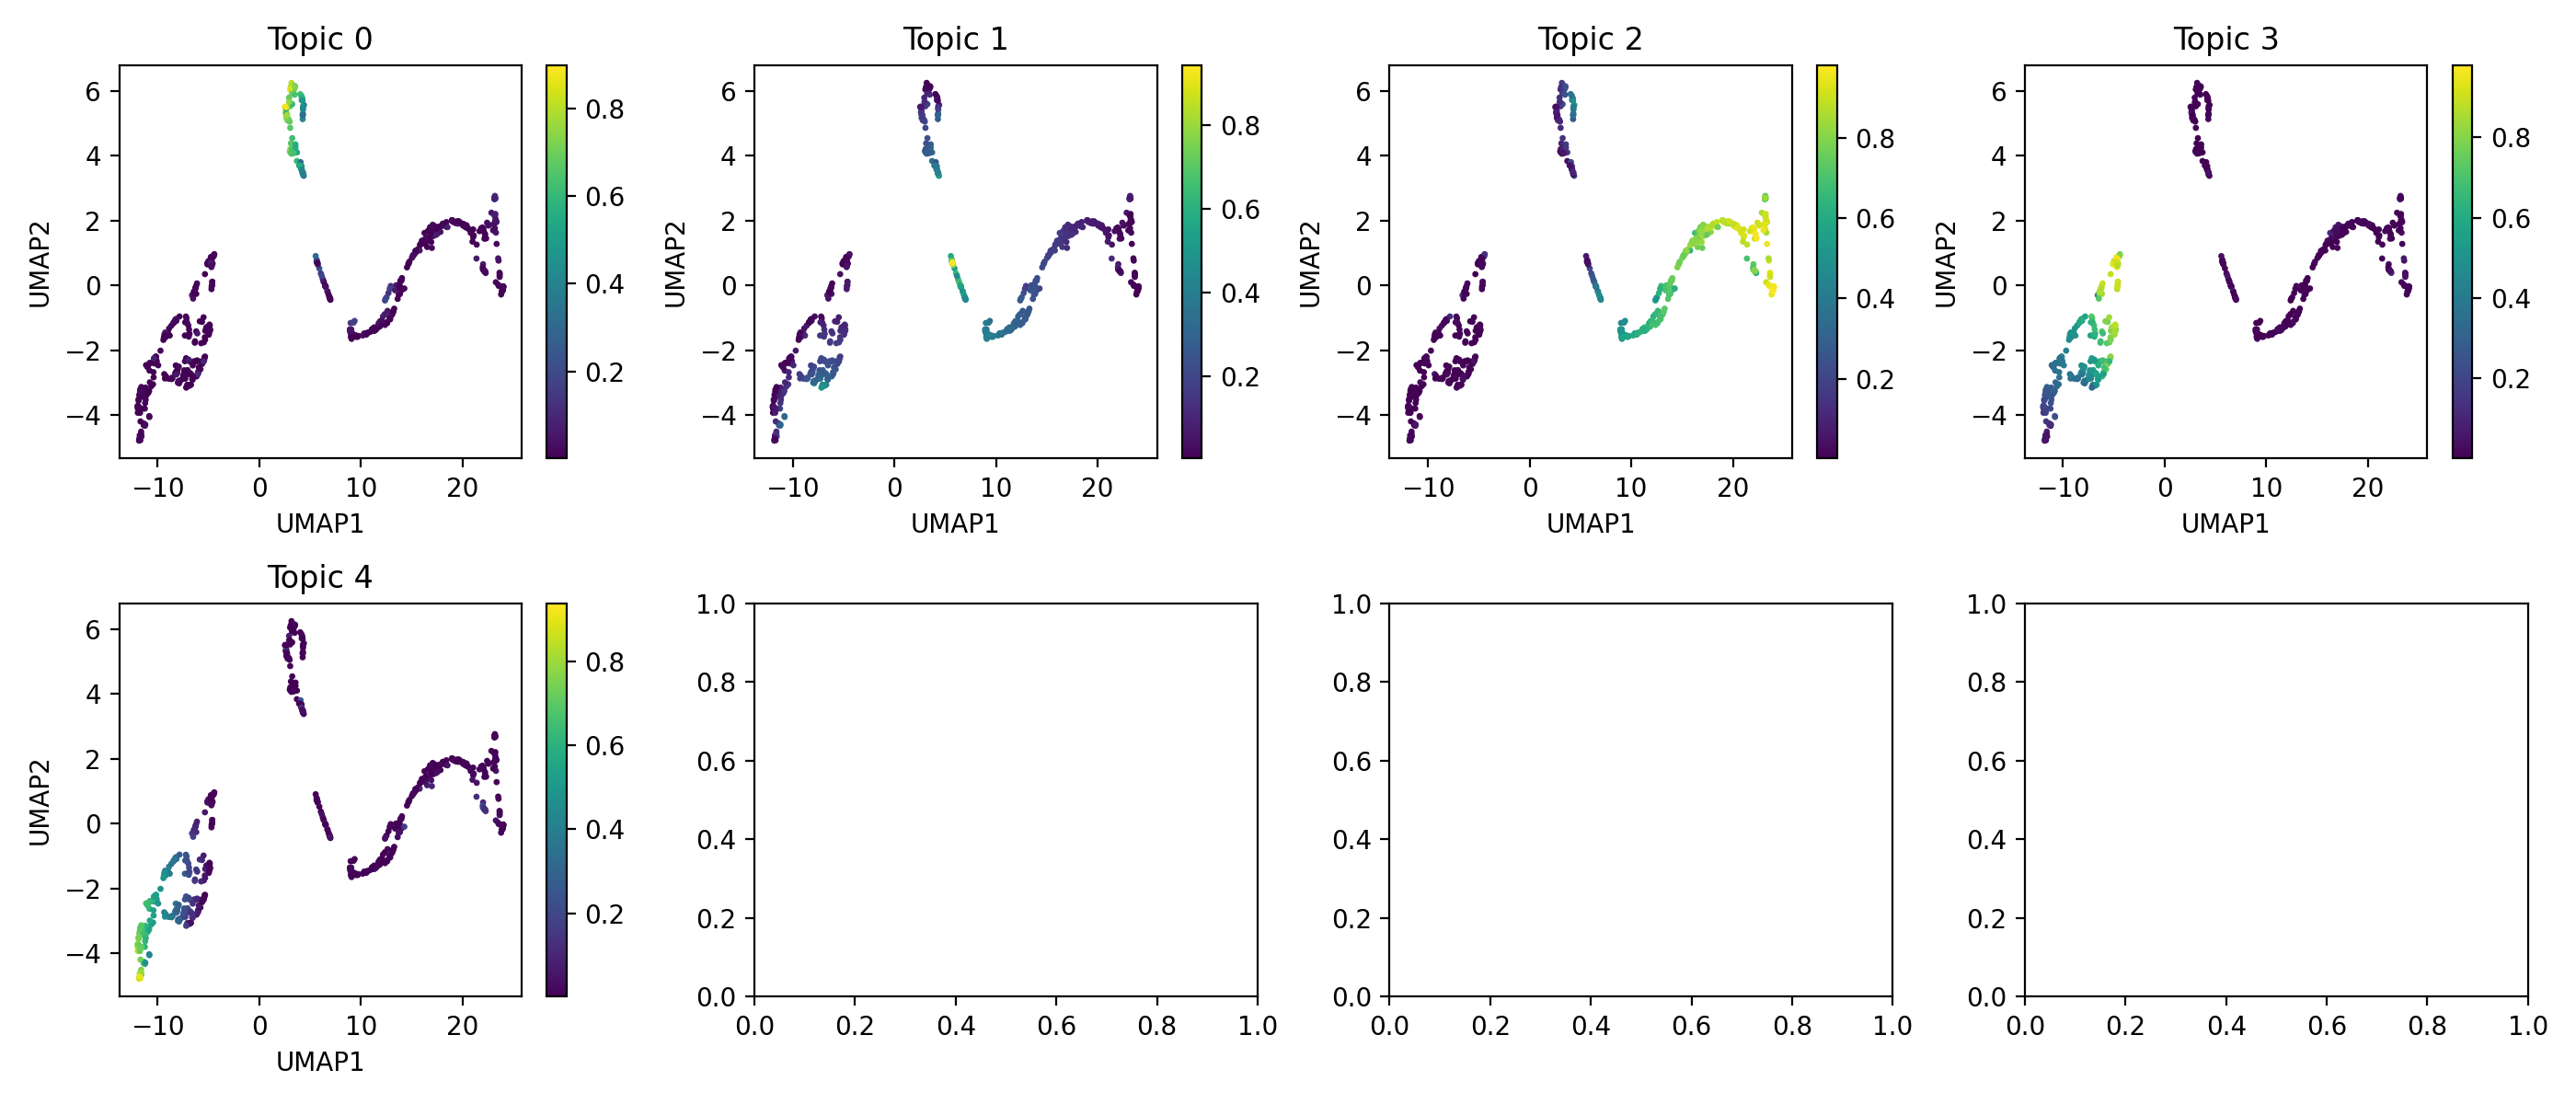

In [14]:
ncols=4
nrows = int(numpy.ceil(doctopic_peaks_frac.shape[1]/ncols))
fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols,3*nrows))
for idx, topic in enumerate(numpy.arange(doctopic_peaks_frac.shape[1])):
    row_idx, col_idx = int(idx/ncols), int(idx%ncols)
    if nrows > 1 and ncols > 1:
        ax = axes[row_idx, col_idx]
    elif nrows > 1 or ncols > 1:
        ax = axes[idx]
    else:
        ax = axes
    s = ax.scatter(doctopic_peaks_umap2_res[:,0], 
                   doctopic_peaks_umap2_res[:,1],
                   cmap='viridis',
                   c=doctopic_peaks_frac[:,topic],
                   s=2)
    ax.set_ylabel('UMAP2')
    ax.set_xlabel('UMAP1')
    ax.set_title('Topic {!s}'.format(topic))
    cbar = fig.colorbar(s, ax=ax)
#cbar.ax.set_yticklabels(gene_names, fontsize=10)
fig.tight_layout()

In [15]:
topic3_sort_idx = numpy.argsort(peaktopic_frac[:,3])[::-1]
print('Topic 3 most-specific peaks')
print('\n'.join(['{!s}\t{!s}\t{!s}'.format(*peak_row_headers[idx][:3]) for idx in topic3_sort_idx[:10]]))
print()

topic6_sort_idx = numpy.argsort(peaktopic_frac[:,6])[::-1]
print('Topic 6 most-specific peaks')
print('\n'.join(['{!s}\t{!s}\t{!s}'.format(*peak_row_headers[idx][:3]) for idx in topic6_sort_idx[:10]]))

Topic 3 most-specific peaks
chrII	11901783	11902780
chrIV	9611587	9612503
chrI	2842012	2842536
chrIV	6493346	6493626
chrIV	8333191	8335213
chrX	9940894	9941176
chrIV	16394573	16394914
chrX	2884606	2885162
chrIV	8252293	8252750
chrI	7192030	7192975

Topic 6 most-specific peaks
chrII	5190453	5191043
chrV	3776182	3776541
chrV	12137976	12138395
chrV	10505612	10505987
chrI	5780695	5781295
chrIV	13255794	13256196
chrV	10507864	10508373
chrI	12432959	12433235
chrV	6547959	6548525
chrIV	11909822	11910251


<IPython.core.display.Javascript object>


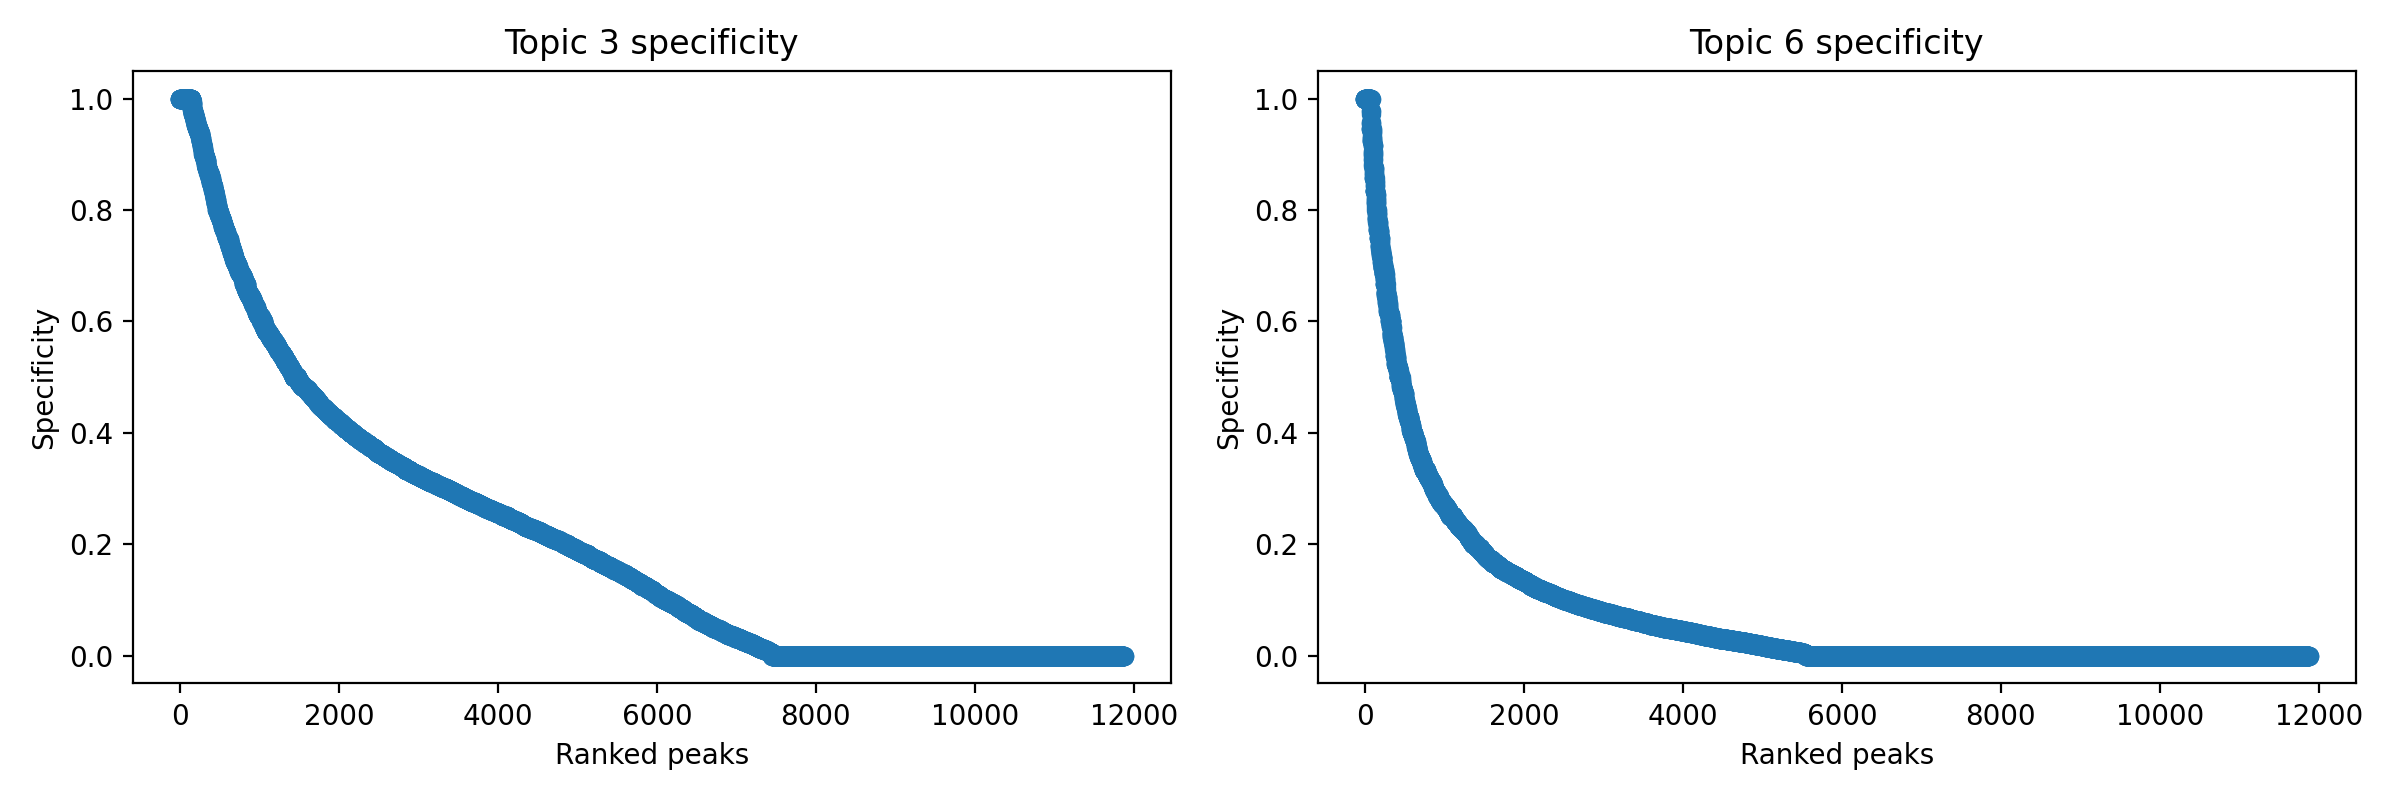

In [16]:
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].scatter(numpy.arange(peaktopic_frac.shape[0]), peaktopic_frac[topic3_sort_idx,3])
axes[0].set_title('Topic 3 specificity')
axes[0].set_xlabel('Ranked peaks')
axes[0].set_ylabel('Specificity')

axes[1].scatter(numpy.arange(peaktopic_frac.shape[0]), peaktopic_frac[topic6_sort_idx,6])
axes[1].set_title('Topic 6 specificity')
axes[1].set_xlabel('Ranked peaks')
axes[1].set_ylabel('Specificity')

fig.tight_layout()

In [72]:
print(numpy.sum(peaktopic_frac[:,3] > 0.9))
print(numpy.sum(peaktopic_frac[:,6] > 0.9))

296
101


In [81]:
peak_str = '\n'.join(['{!s}\t{!s}\t{!s}'.format(*peak_row_headers[idx][:3]) 
                      for idx in numpy.where(peaktopic_frac[:,3] > 0.9)[0]]) + '\n'
cmd = (local['bedtools']['closest', '-a', 'stdin', '-b', refseq_exon_bed] << peak_str
       | local['awk']['BEGIN{FS="\t"; OFS="\t";}{print($7);}'])
topic3_genes = sorted(set(cmd().strip().split('\n')))
print(len(topic3_genes))

peak_str = '\n'.join(['{!s}\t{!s}\t{!s}'.format(*peak_row_headers[idx][:3]) 
                      for idx in numpy.where(peaktopic_frac[:,6] > 0.9)[0]]) + '\n'
cmd = (local['bedtools']['closest', '-a', 'stdin', '-b', refseq_exon_bed] << peak_str
       | local['awk']['BEGIN{FS="\t"; OFS="\t";}{print($7);}'])
topic6_genes = sorted(set(cmd().strip().split('\n')))
print(len(topic6_genes))

297
115


In [82]:
print(len(set(topic3_genes) & set(topic6_genes)))

4


In [85]:
print(', '.join(sorted(set(topic3_genes) & set(topic6_genes))))
print()
print(', '.join(sorted(set(topic3_genes) - set(topic6_genes))))
print()
print(', '.join(sorted(set(topic6_genes) - set(topic3_genes))))

K02D3.2, VZK822L.2, W09C2.12, rnt-1

21ur-10061, 21ur-11886, 21ur-11942, 21ur-12243, 21ur-12293, 21ur-12556, 21ur-13123, 21ur-15022, 21ur-15693, 21ur-3318, 21ur-3747, 21ur-7159, 21ur-7261, 21ur-7407, 21ur-8191, 21ur-9777, B0284.3, B0336.14, B0336.15, B0350.69, B0350.72, B0350.81, B0353.1, C05D12.11, C05D12.9, C06A8.13, C09B8.18, C09F5.1, C10G11.13, C13G5.2, C14B4.2, C14F11.19, C17E4.20, C17G1.5, C18E3.4, C25E10.15, C32D5.12, C32E12.7, C33E10.9, C34C12.10, C34C12.11, C36A4.10, C36A4.14, C36F7.23, C36F7.9, C47G2.16, E02C12.16, F01G4.4, F07C6.4, F07C6.8, F10D7.3, F10F2.14, F11C3.1, F15B10.3, F22B3.19, F25F2.6, F27D4.10, F28F9.8, F32D1.3, F38E11.8, F43G6.14, F43G6.4, F46H5.4, F53A10.2, F53B2.14, F53B2.15, F53B2.5, F53B3.11, F54D5.20, F54D5.21, F54D5.23, F54D5.5, F55A8.5, F55A8.6, F55C9.12, F55C9.3, F56D3.1, F57G12.13, F57G12.t2, H09I01.4, H30A04.6, K02C4.10, K02C4.9, K07H8.8, K08A2.2, K10B2.t1, K12H4.11, M03A8.3, M03D4.78, M163.t1, M79.9, R05D7.7, R09F10.5, R10E12.2, R12H7.4, T01C1.9, T01C

<IPython.core.display.Javascript object>


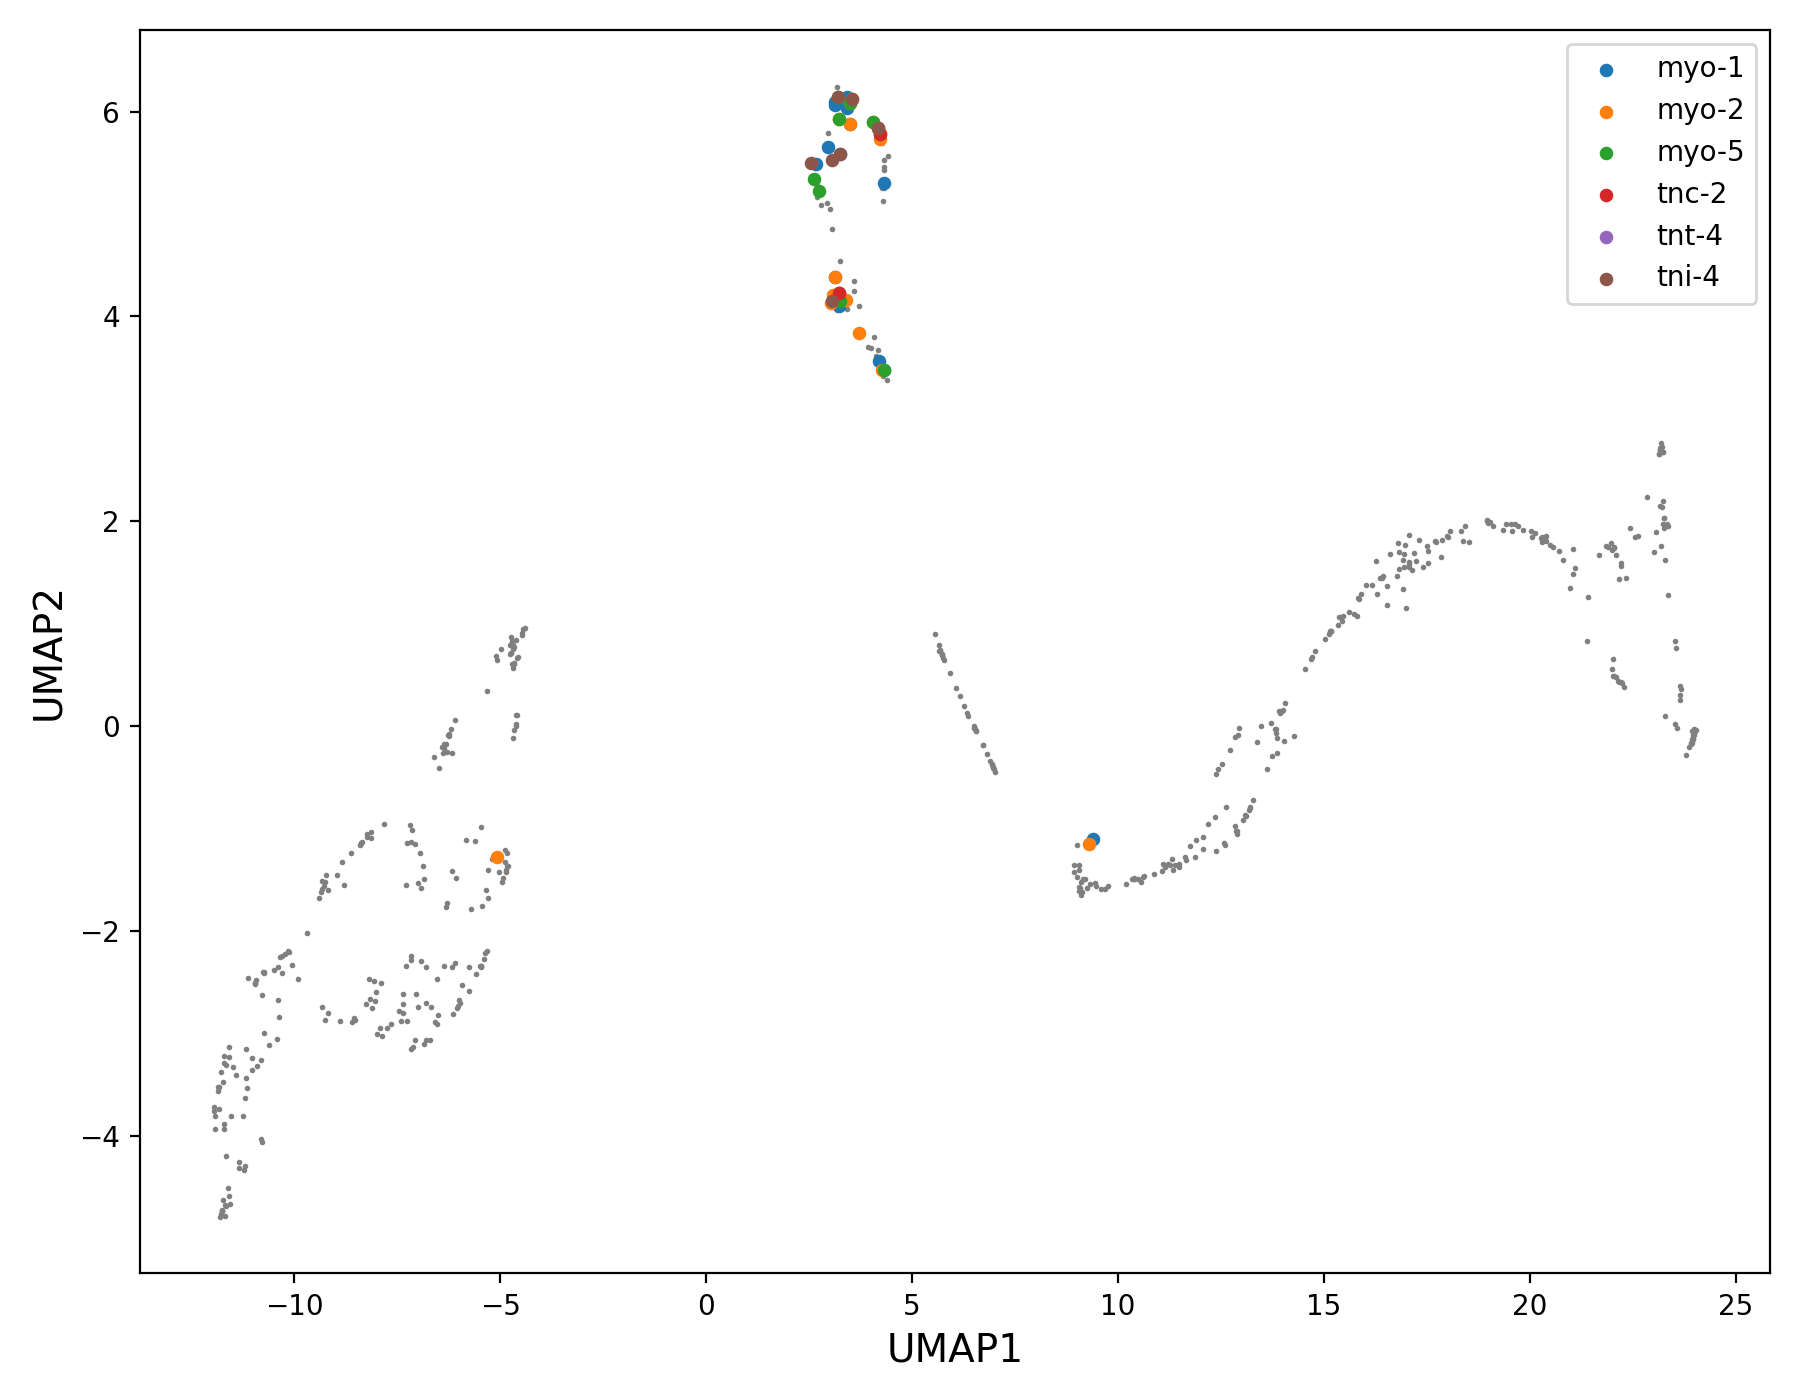

['chrI', 7258914, 7267117, 'myo-1', '0', '-']
[['chrI' '7266804' '7267519' 'name']
 ['chrI' '7267676' '7267876' 'name']
 ['chrI' '7268241' '7268610' 'name']]
[ 402  759 1493]
['chrX', 12468060, 12475348, 'myo-2', '0', '+']
[['chrX' '12467426' '12468100' 'name']
 ['chrX' '12469381' '12469820' 'name']
 ['chrX' '12472236' '12472436' 'name']
 ['chrX' '12474115' '12474315' 'name']]
[  634 -1321 -4176 -6055]
['chrV', 8108969, 8118131, 'myo-5', '0', '+']
[['chrV' '8107782' '8108259' 'name']
 ['chrV' '8108647' '8109367' 'name']]
[1187  322]
['chrII', 10466851, 10468344, 'tnc-2', '0', '+']
[['chrII' '10466587' '10466830' 'name']]
[264]
['chrV', 1989475, 1992918, 'tnt-4', '0', '-']
[]
[]
['chrIV', 5204590, 5207138, 'tni-4', '0', '+']
[['chrIV' '5204060' '5204577' 'name']
 ['chrIV' '5206945' '5207277' 'name']]
[  530 -2355]


In [15]:
#pm3_pm4_pm5
gene_names = ['myo-1', 'myo-2', 'myo-5', 'tnc-2', 'tnt-4', 'tni-4']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


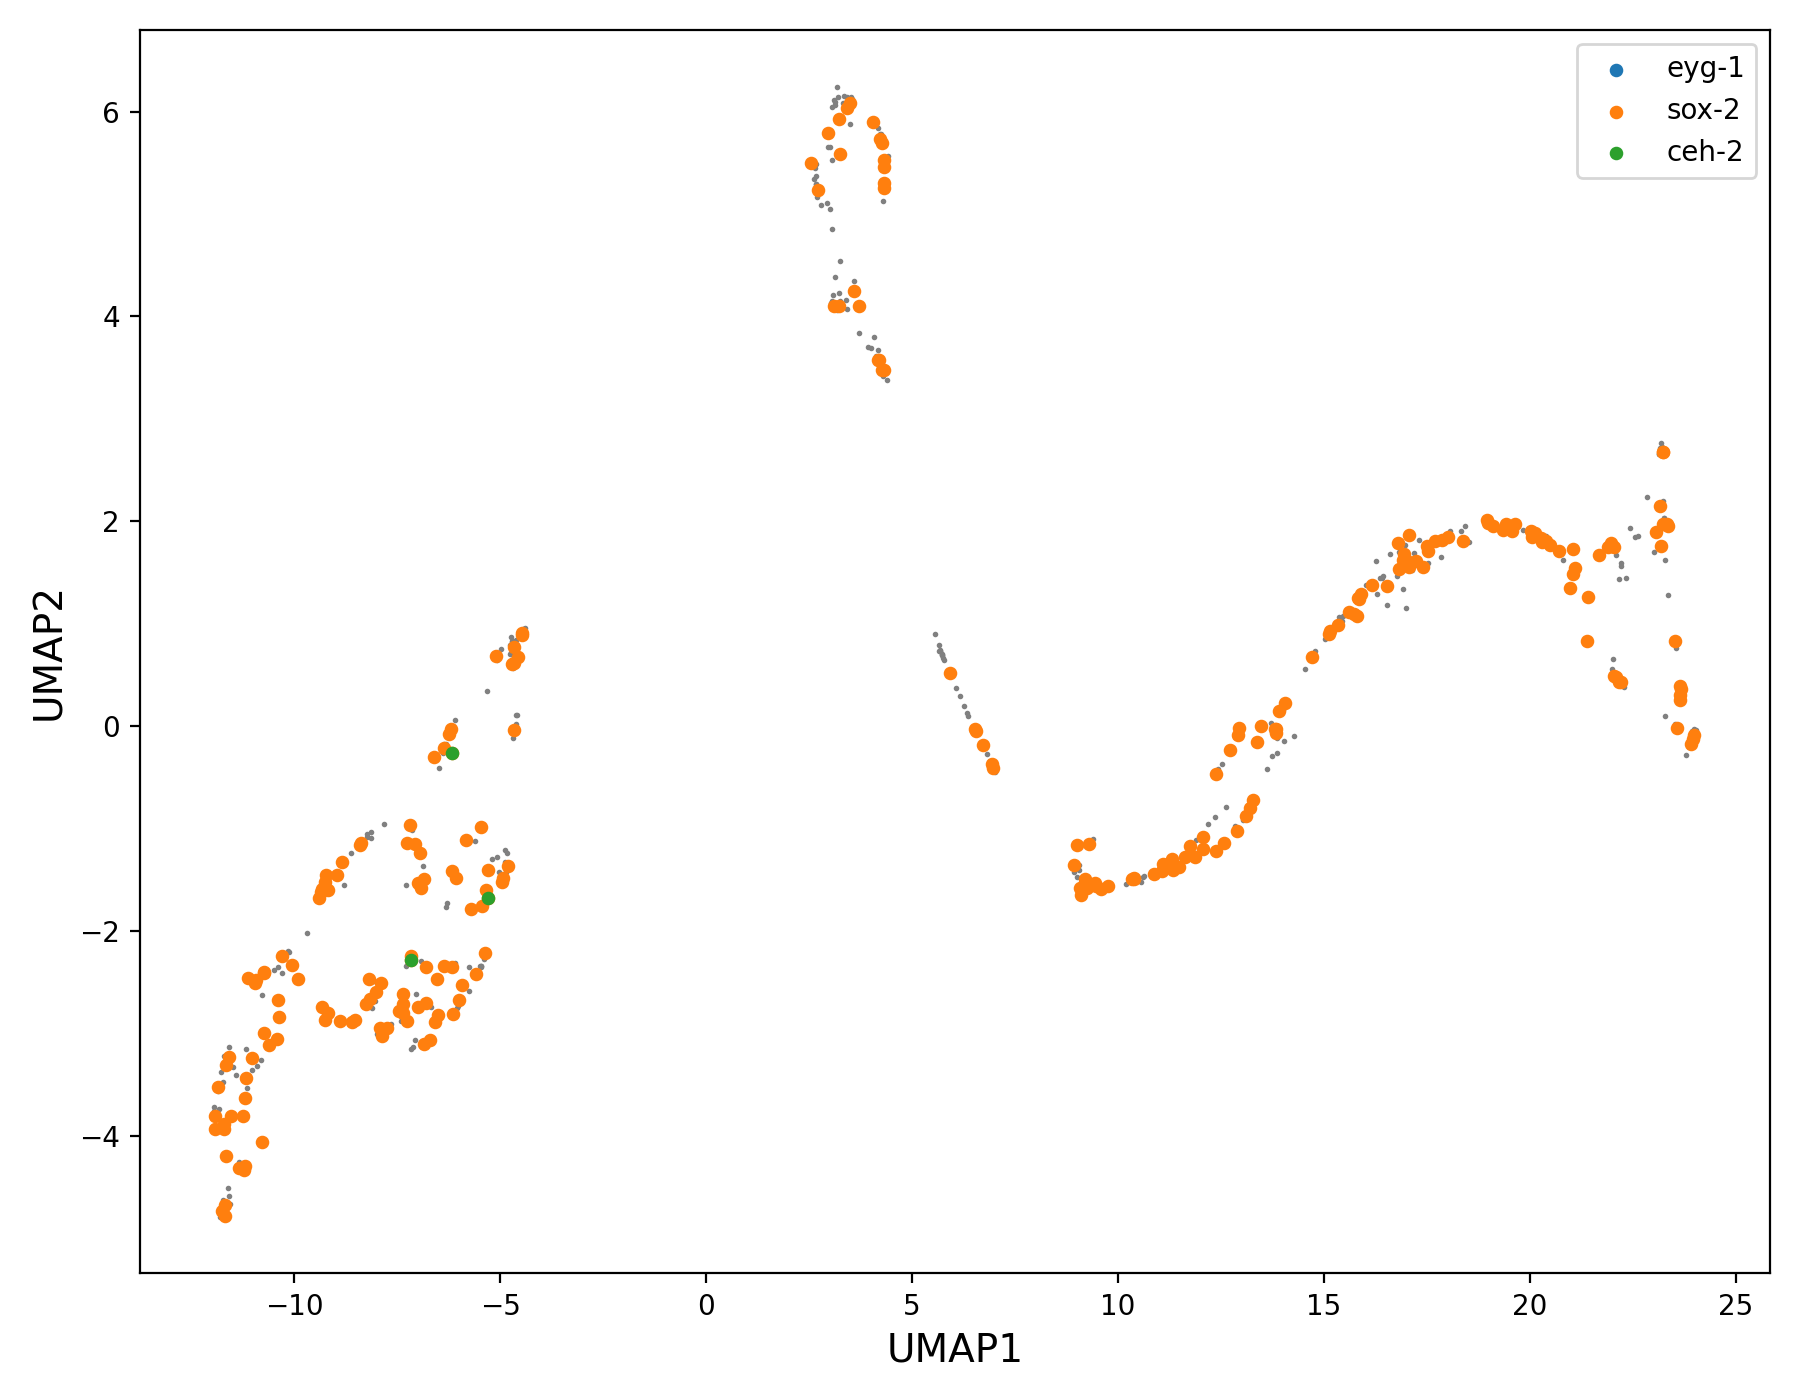

['chrII', 9826512, 9827926, 'eyg-1', '0', '-']
[]
[]
['chrX', 7458292, 7463736, 'sox-2', '0', '-']
[['chrX' '7455993' '7458889' 'name']
 ['chrX' '7459668' '7459873' 'name']
 ['chrX' '7460115' '7461215' 'name']
 ['chrX' '7461982' '7462433' 'name']
 ['chrX' '7463492' '7465112' 'name']]
[-4847 -3863 -2521 -1303  1376]
['chrI', 6046831, 6050462, 'ceh-2', '0', '-']
[['chrI' '6051160' '6051401' 'name']]
[939]


In [16]:
#pm1_pm2 (plus the markers in pm3_pm4_pm5)
gene_names = ['eyg-1', 'sox-2', 'ceh-2']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


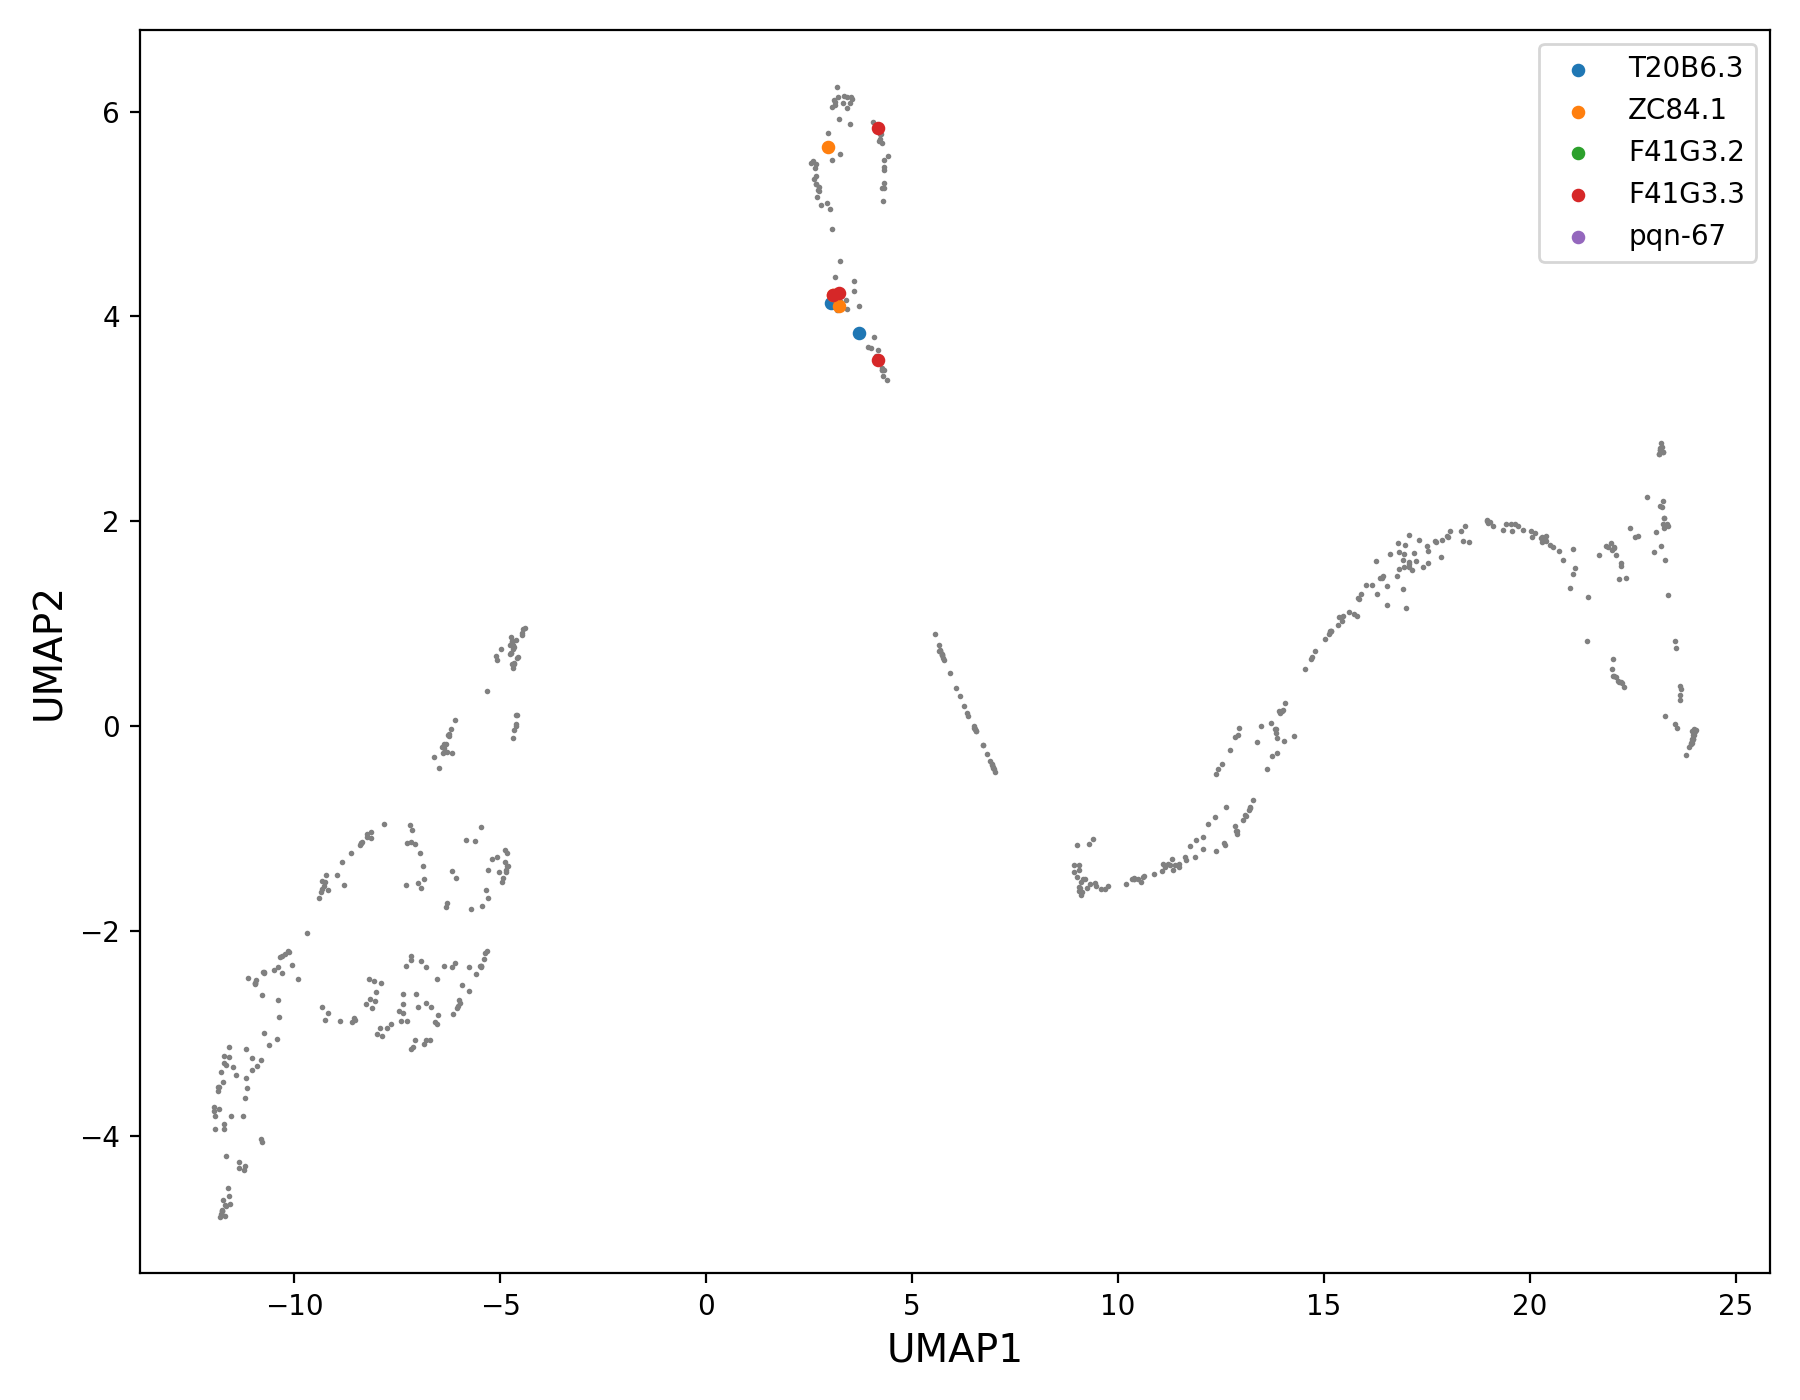

['chrIII', 2899440, 2900402, 'T20B6.3', '0', '-']
[['chrIII' '2901435' '2901649' 'name']]
[1247]
['chrIII', 9199449, 9206285, 'ZC84.1', '0', '-']
[['chrIII' '9199684' '9200022' 'name']]
[-6263]
['chrII', 6758884, 6760385, 'F41G3.2', '0', '+']
[]
[]
['chrII', 6756531, 6758934, 'F41G3.3', '0', '+']
[['chrII' '6756351' '6756742' 'name']]
[180]
['chrV', 12924440, 12928173, 'pqn-67', '0', '+']
[]
[]


In [17]:
#pm6_pm7
gene_names = ['T20B6.3', 'ZC84.1', 'F41G3.2', 'F41G3.3', 'pqn-67']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


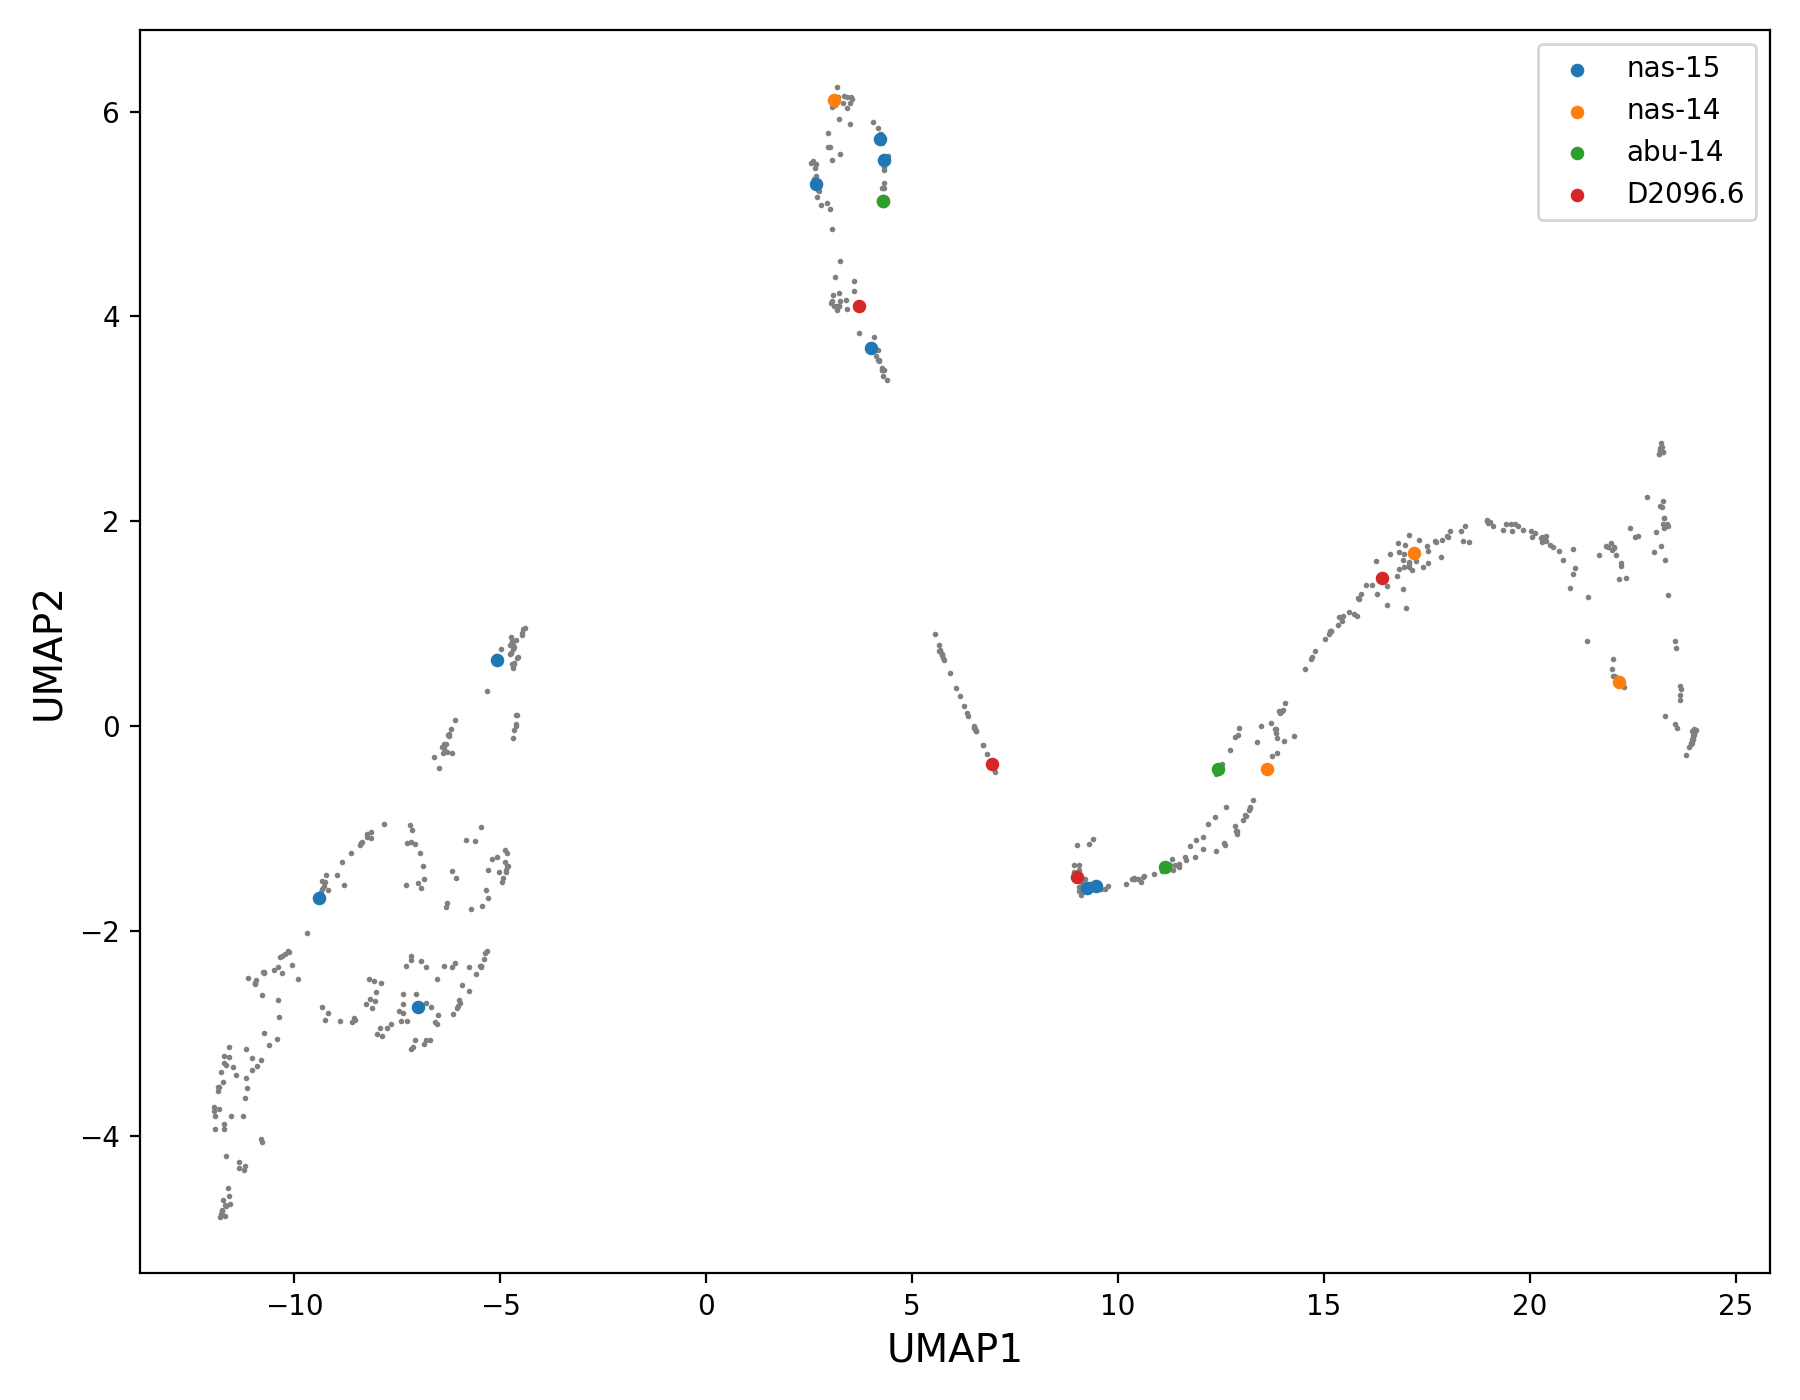

['chrX', 777720, 780514, 'nas-15', '0', '+']
[['chrX' '776955' '777510' 'name']]
[765]
['chrIV', 13170543, 13173694, 'nas-14', '0', '+']
[['chrIV' '13169575' '13169834' 'name']]
[968]
['chrII', 9225185, 9227261, 'abu-14', '0', '-']
[['chrII' '9227105' '9227305' 'name']]
[44]
['chrIV', 8368343, 8369235, 'D2096.6', '0', '-']
[['chrIV' '8369555' '8369795' 'name']]
[560]


In [18]:
#Marginal_cell_bin_1_mid_to_late_L2
gene_names = ['nas-15', 'nas-14', 'abu-14', 'D2096.6']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


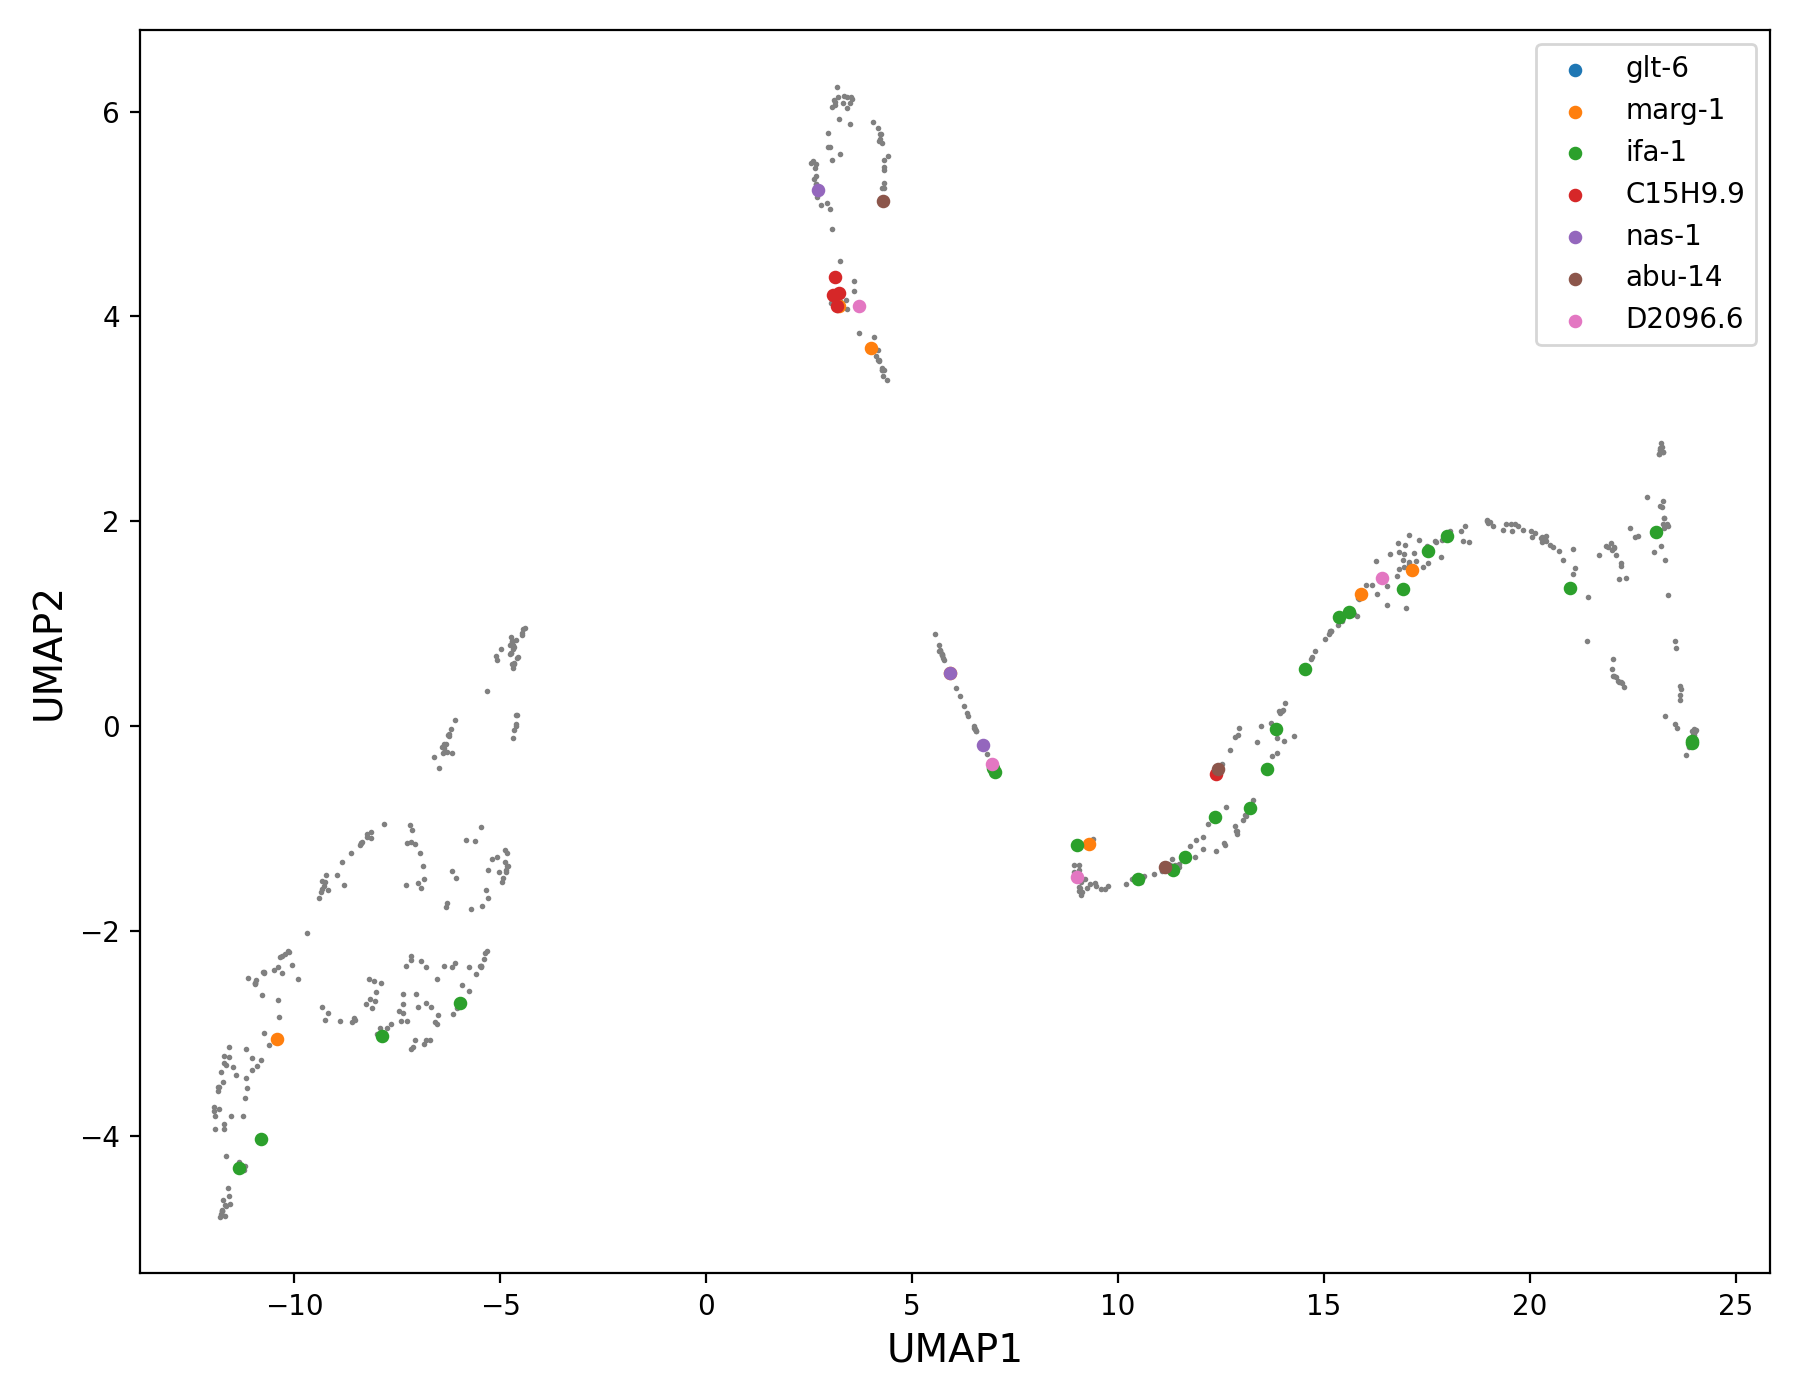

['chrIV', 7503621, 7506447, 'glt-6', '0', '+']
[]
[]
['chrX', 3778090, 3781118, 'marg-1', '0', '-']
[['chrX' '3781123' '3781506' 'name']]
[388]
['chrX', 11271183, 11275482, 'ifa-1', '0', '+']
[['chrX' '11269578' '11270207' 'name']
 ['chrX' '11272383' '11272583' 'name']]
[ 1605 -1200]
['chrX', 6127456, 6128326, 'C15H9.9', '0', '-']
[['chrX' '6128899' '6129465' 'name']]
[1139]
['chrIII', 13405964, 13409292, 'nas-1', '0', '+']
[['chrIII' '13405746' '13406094' 'name']]
[218]
['chrII', 9225185, 9227261, 'abu-14', '0', '-']
[['chrII' '9227105' '9227305' 'name']]
[44]
['chrIV', 8368343, 8369235, 'D2096.6', '0', '-']
[['chrIV' '8369555' '8369795' 'name']]
[560]


In [19]:
#Marginal_cell_bin_2_around_L2_molt_to_early_L3
gene_names = ['glt-6', 'marg-1', 'ifa-1', 'C15H9.9', 'nas-1', 'abu-14', 'D2096.6']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


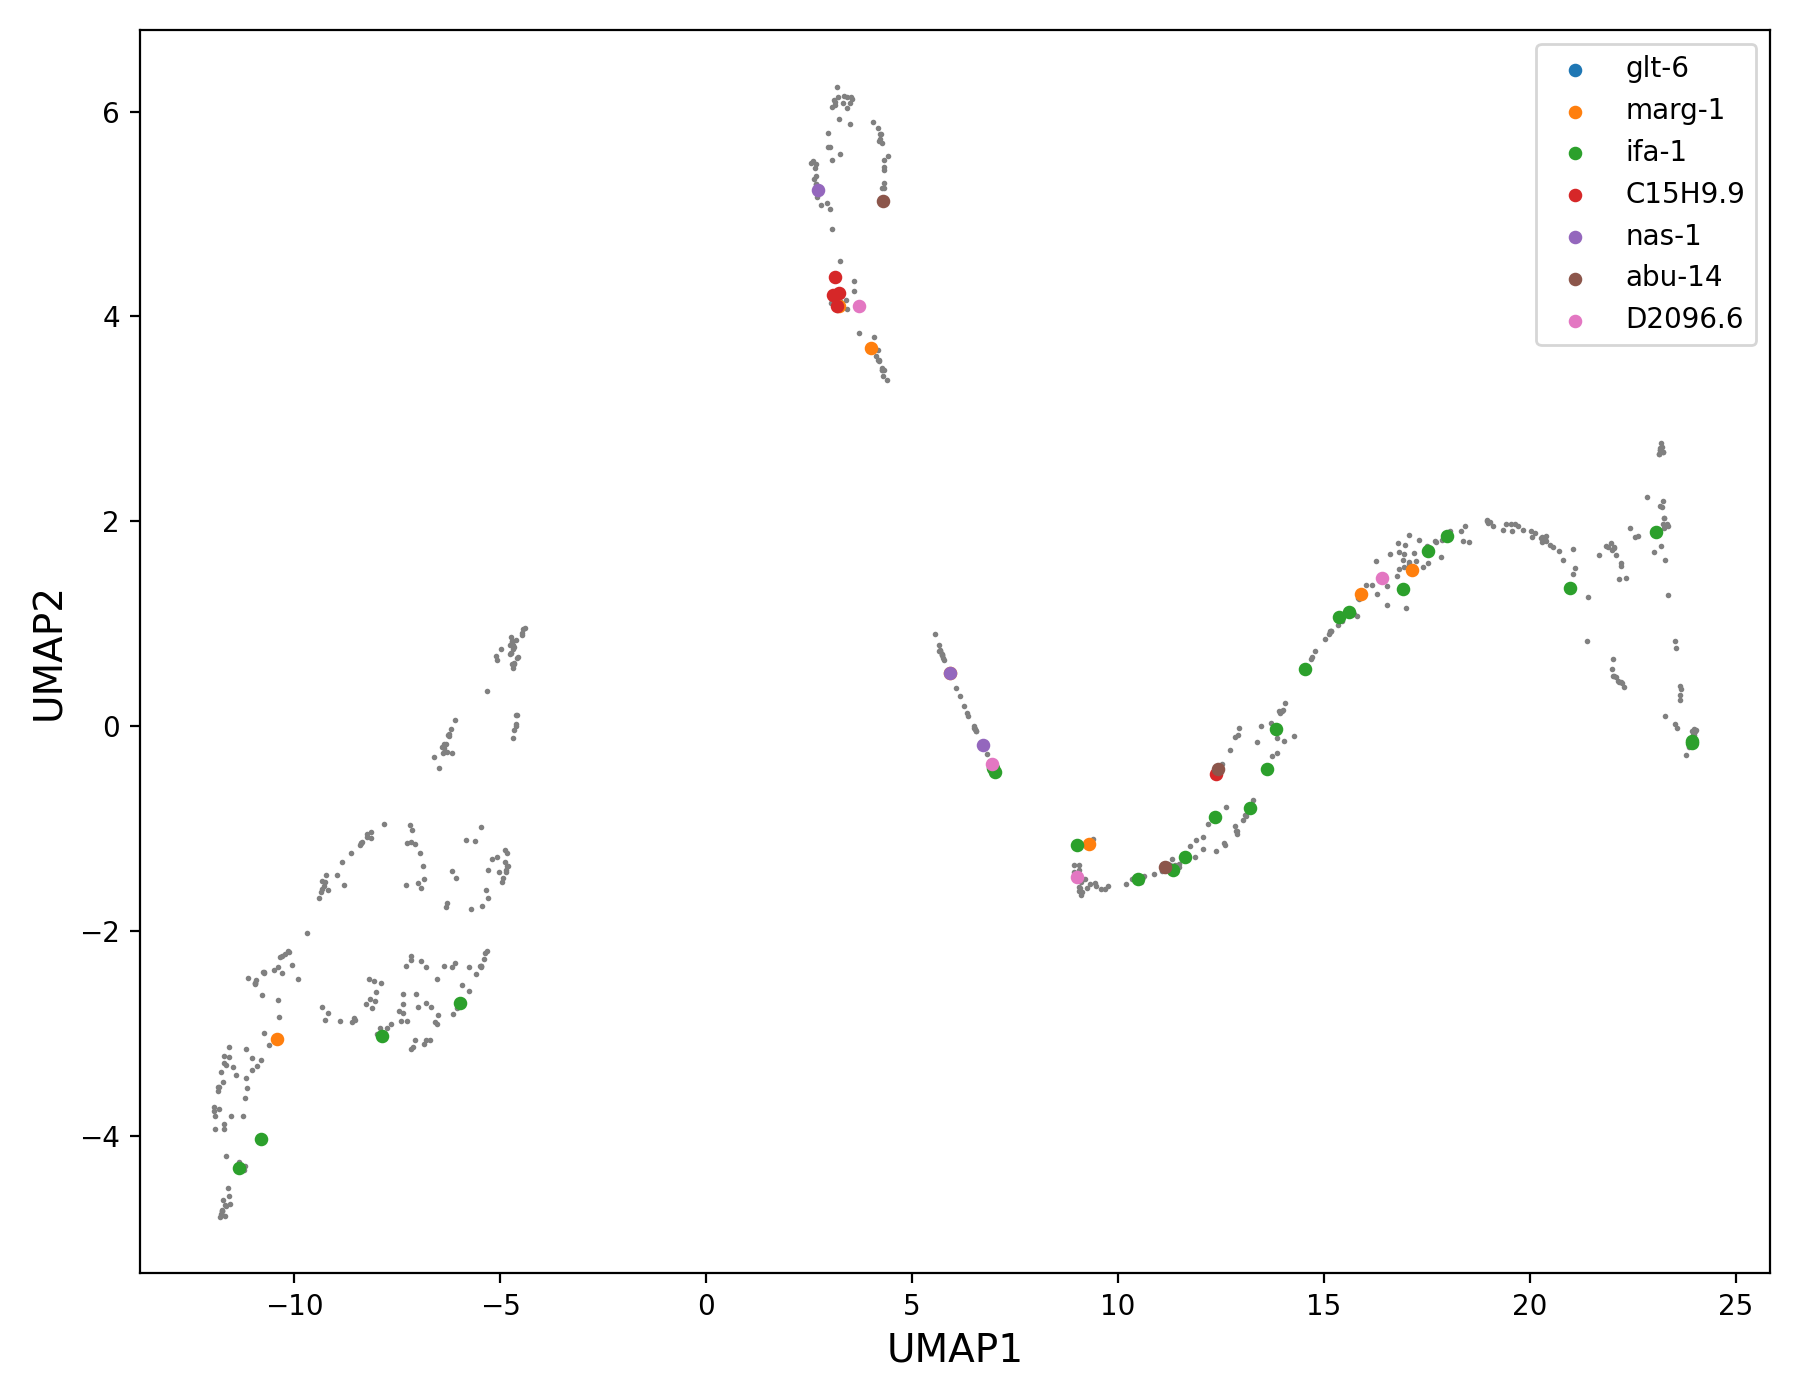

['chrIV', 7503621, 7506447, 'glt-6', '0', '+']
[]
[]
['chrX', 3778090, 3781118, 'marg-1', '0', '-']
[['chrX' '3781123' '3781506' 'name']]
[388]
['chrX', 11271183, 11275482, 'ifa-1', '0', '+']
[['chrX' '11269578' '11270207' 'name']
 ['chrX' '11272383' '11272583' 'name']]
[ 1605 -1200]
['chrX', 6127456, 6128326, 'C15H9.9', '0', '-']
[['chrX' '6128899' '6129465' 'name']]
[1139]
['chrIII', 13405964, 13409292, 'nas-1', '0', '+']
[['chrIII' '13405746' '13406094' 'name']]
[218]
['chrII', 9225185, 9227261, 'abu-14', '0', '-']
[['chrII' '9227105' '9227305' 'name']]
[44]
['chrIV', 8368343, 8369235, 'D2096.6', '0', '-']
[['chrIV' '8369555' '8369795' 'name']]
[560]


In [19]:
#Marginal_cell_bin_2_around_L2_molt_to_early_L3
gene_names = ['glt-6', 'marg-1', 'ifa-1', 'C15H9.9', 'nas-1', 'abu-14', 'D2096.6']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


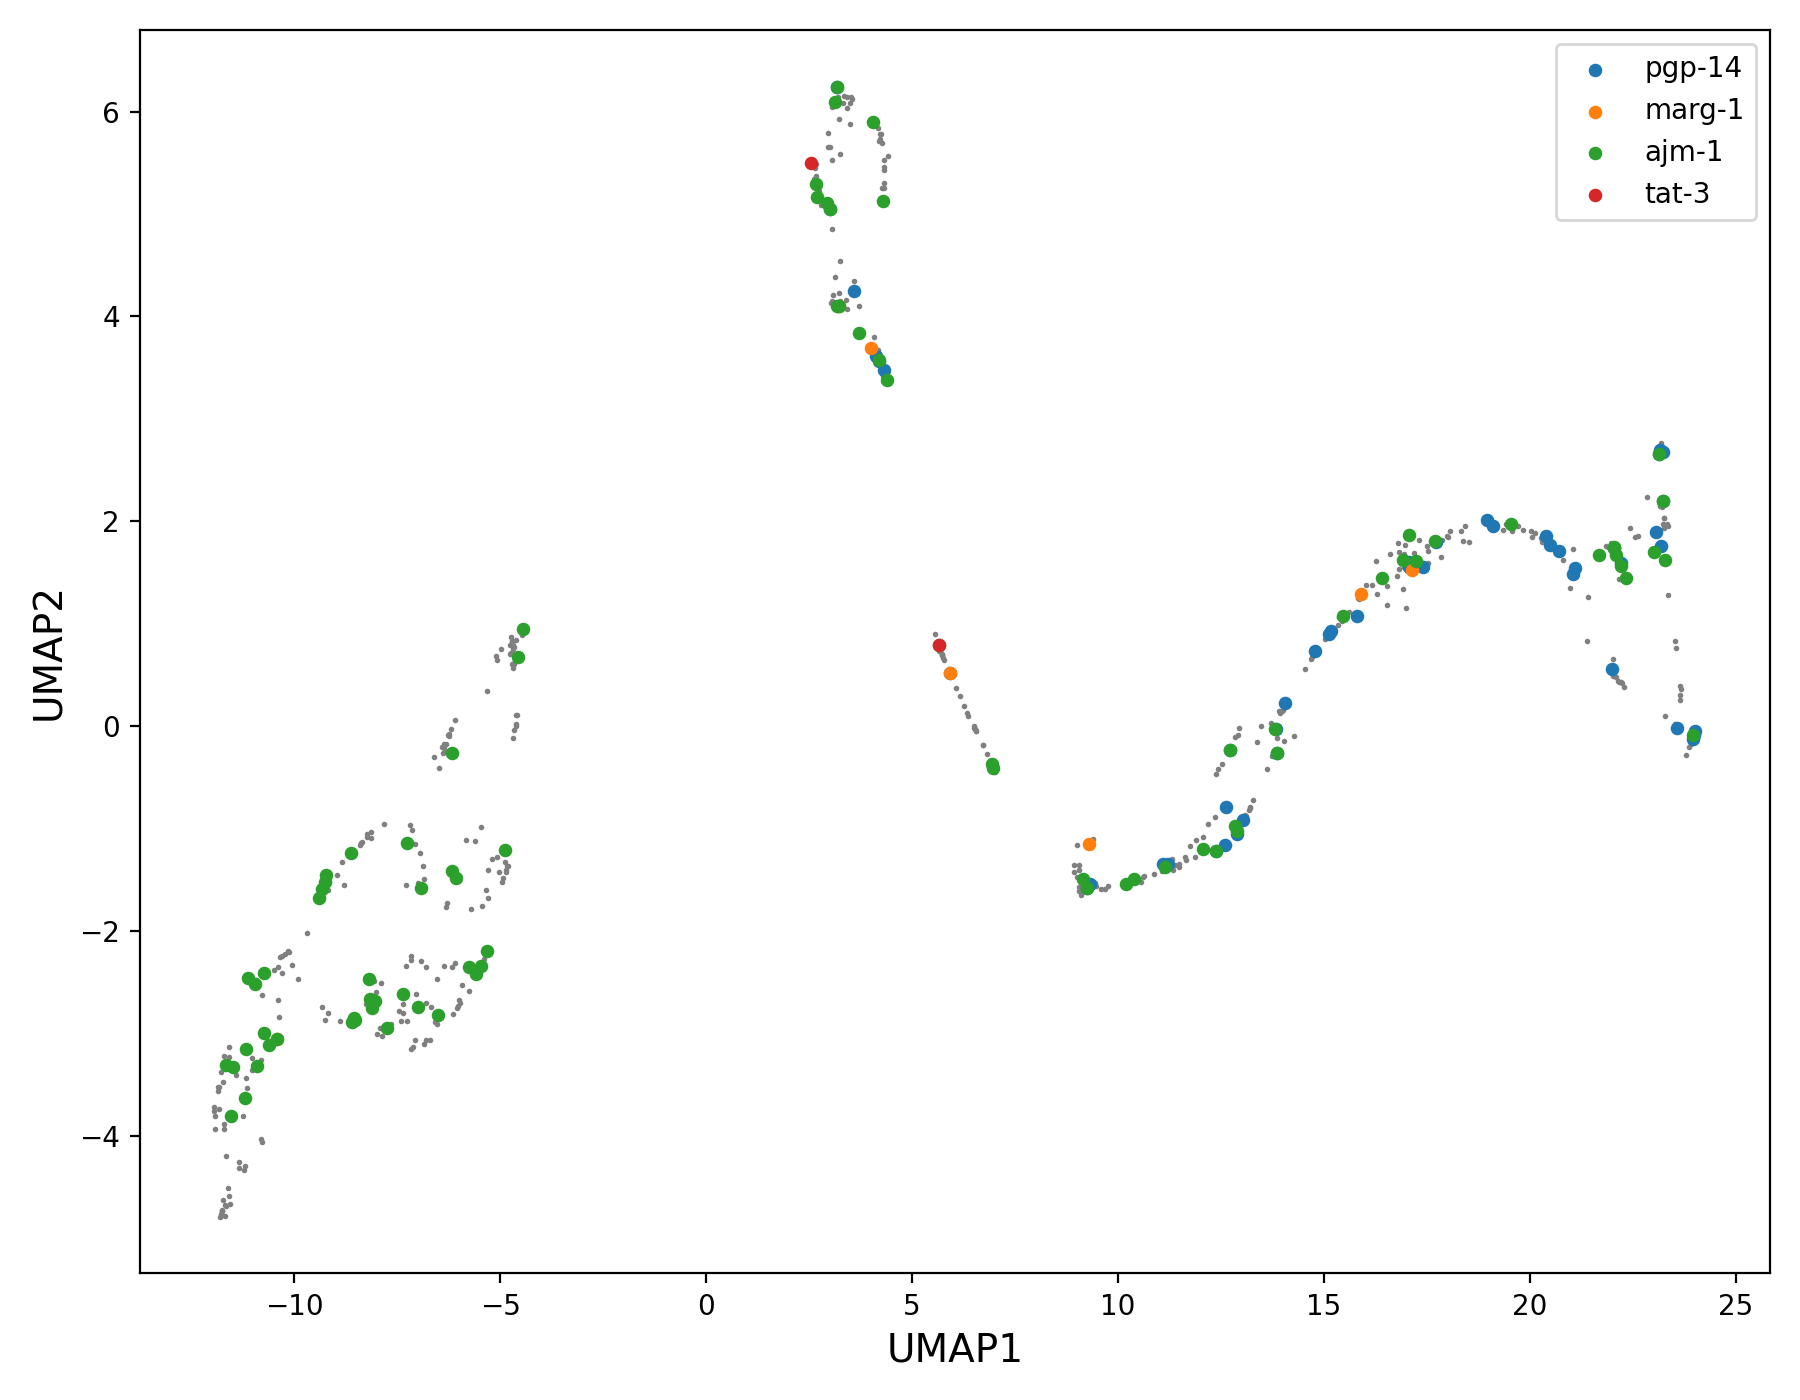

['chrX', 12744722, 12749580, 'pgp-14', '0', '-']
[['chrX' '12745375' '12745575' 'name']
 ['chrX' '12746724' '12747134' 'name']
 ['chrX' '12747211' '12747441' 'name']
 ['chrX' '12748621' '12749376' 'name']
 ['chrX' '12749715' '12750468' 'name']]
[-4005 -2446 -2139  -204   888]
['chrX', 3778090, 3781118, 'marg-1', '0', '-']
[['chrX' '3781123' '3781506' 'name']]
[388]
['chrX', 9078944, 9113613, 'ajm-1', '0', '+']
[['chrX' '9078205' '9078490' 'name']
 ['chrX' '9082792' '9082992' 'name']
 ['chrX' '9083301' '9084046' 'name']
 ['chrX' '9085751' '9086152' 'name']
 ['chrX' '9090577' '9090823' 'name']
 ['chrX' '9091486' '9091798' 'name']
 ['chrX' '9091859' '9092059' 'name']
 ['chrX' '9095078' '9095585' 'name']
 ['chrX' '9101317' '9101517' 'name']
 ['chrX' '9101745' '9101945' 'name']
 ['chrX' '9102176' '9102592' 'name']
 ['chrX' '9102679' '9103293' 'name']
 ['chrX' '9104108' '9104928' 'name']]
[   739  -3848  -4357  -6807 -11633 -12542 -12915 -16134 -22373 -22801
 -23232 -23735 -25164]
['chrIII',

In [20]:
#Pharyngeal_epithelial_cell_tentative (process of elimination, so these markers might not be definitive)
gene_names = ['pgp-14', 'marg-1', 'ajm-1', 'tat-3']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


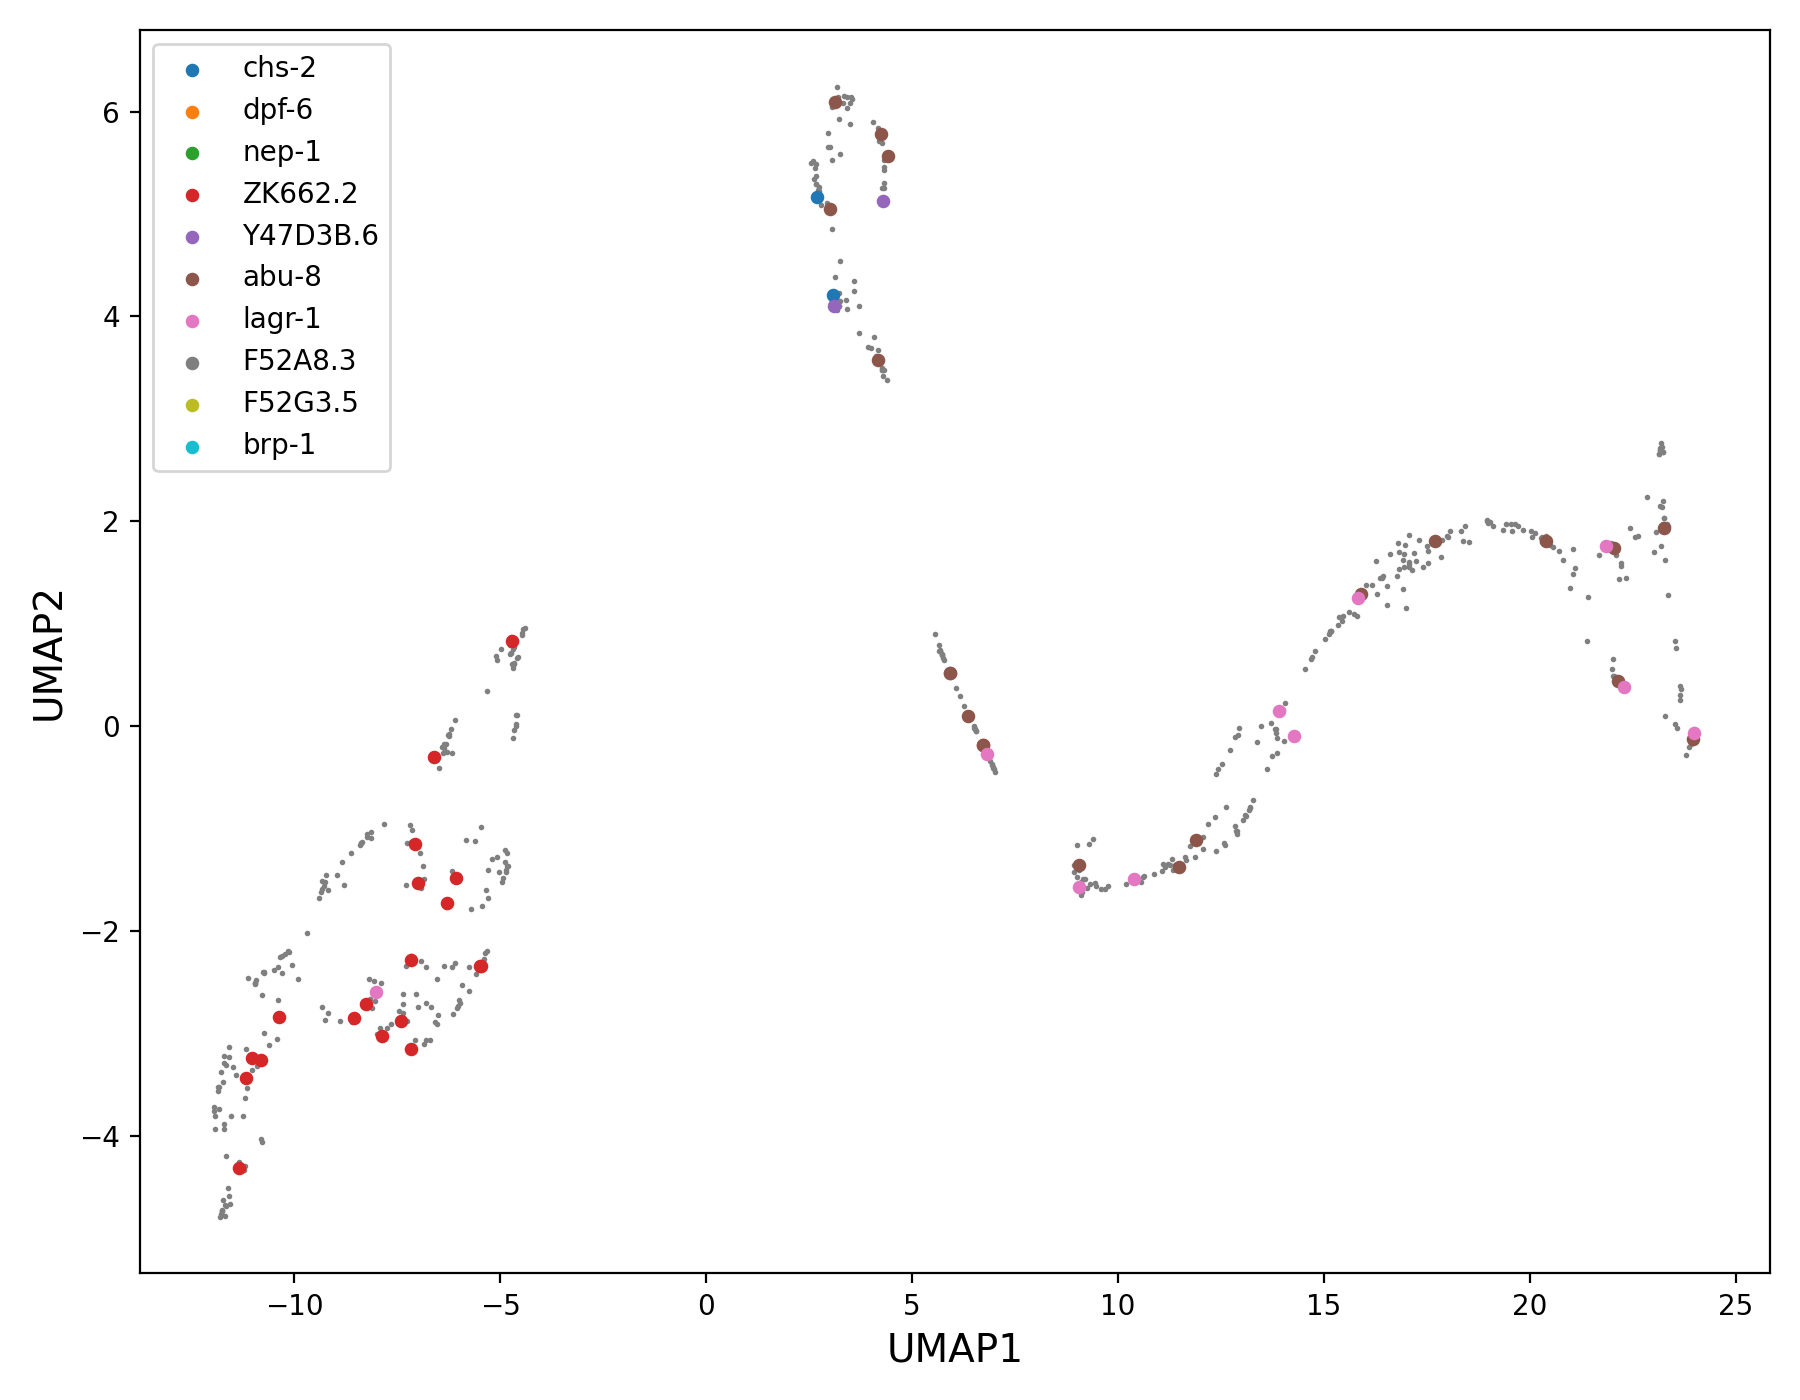

['chrII', 196984, 211941, 'chs-2', '0', '+']
[['chrII' '204919' '205119' 'name']]
[-7935]
['chrIII', 8038240, 8041374, 'dpf-6', '0', '+']
[]
[]
['chrII', 11654213, 11657172, 'nep-1', '0', '-']
[]
[]
['chrX', 15696699, 15698062, 'ZK662.2', '0', '+']
[['chrX' '15696205' '15696875' 'name']]
[494]
['chrIII', 11427134, 11428414, 'Y47D3B.6', '0', '+']
[['chrIII' '11428410' '11429040' 'name']]
[-1276]
['chrV', 5163268, 5194608, 'abu-8', '0', '-']
[['chrV' '5192746' '5193220' 'name']
 ['chrV' '5194407' '5195200' 'name']]
[-1388   592]
['chrI', 13724576, 13732046, 'lagr-1', '0', '-']
[['chrI' '13731863' '13732359' 'name']]
[313]
['chrI', 7322269, 7324415, 'F52A8.3', '0', '-']
[]
[]
['chrX', 16973226, 16976130, 'F52G3.5', '0', '-']
[]
[]
['chrIII', 12020551, 12025325, 'brp-1', '0', '+']
[]
[]


In [22]:
#Anterior_arcade_bin_1_mid_to_late_L2
gene_names = ['chs-2', 'dpf-6', 'nep-1', 'ZK662.2', 'Y47D3B.6', 'abu-8', 'lagr-1', 'F52A8.3', 'F52G3.5', 'brp-1']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


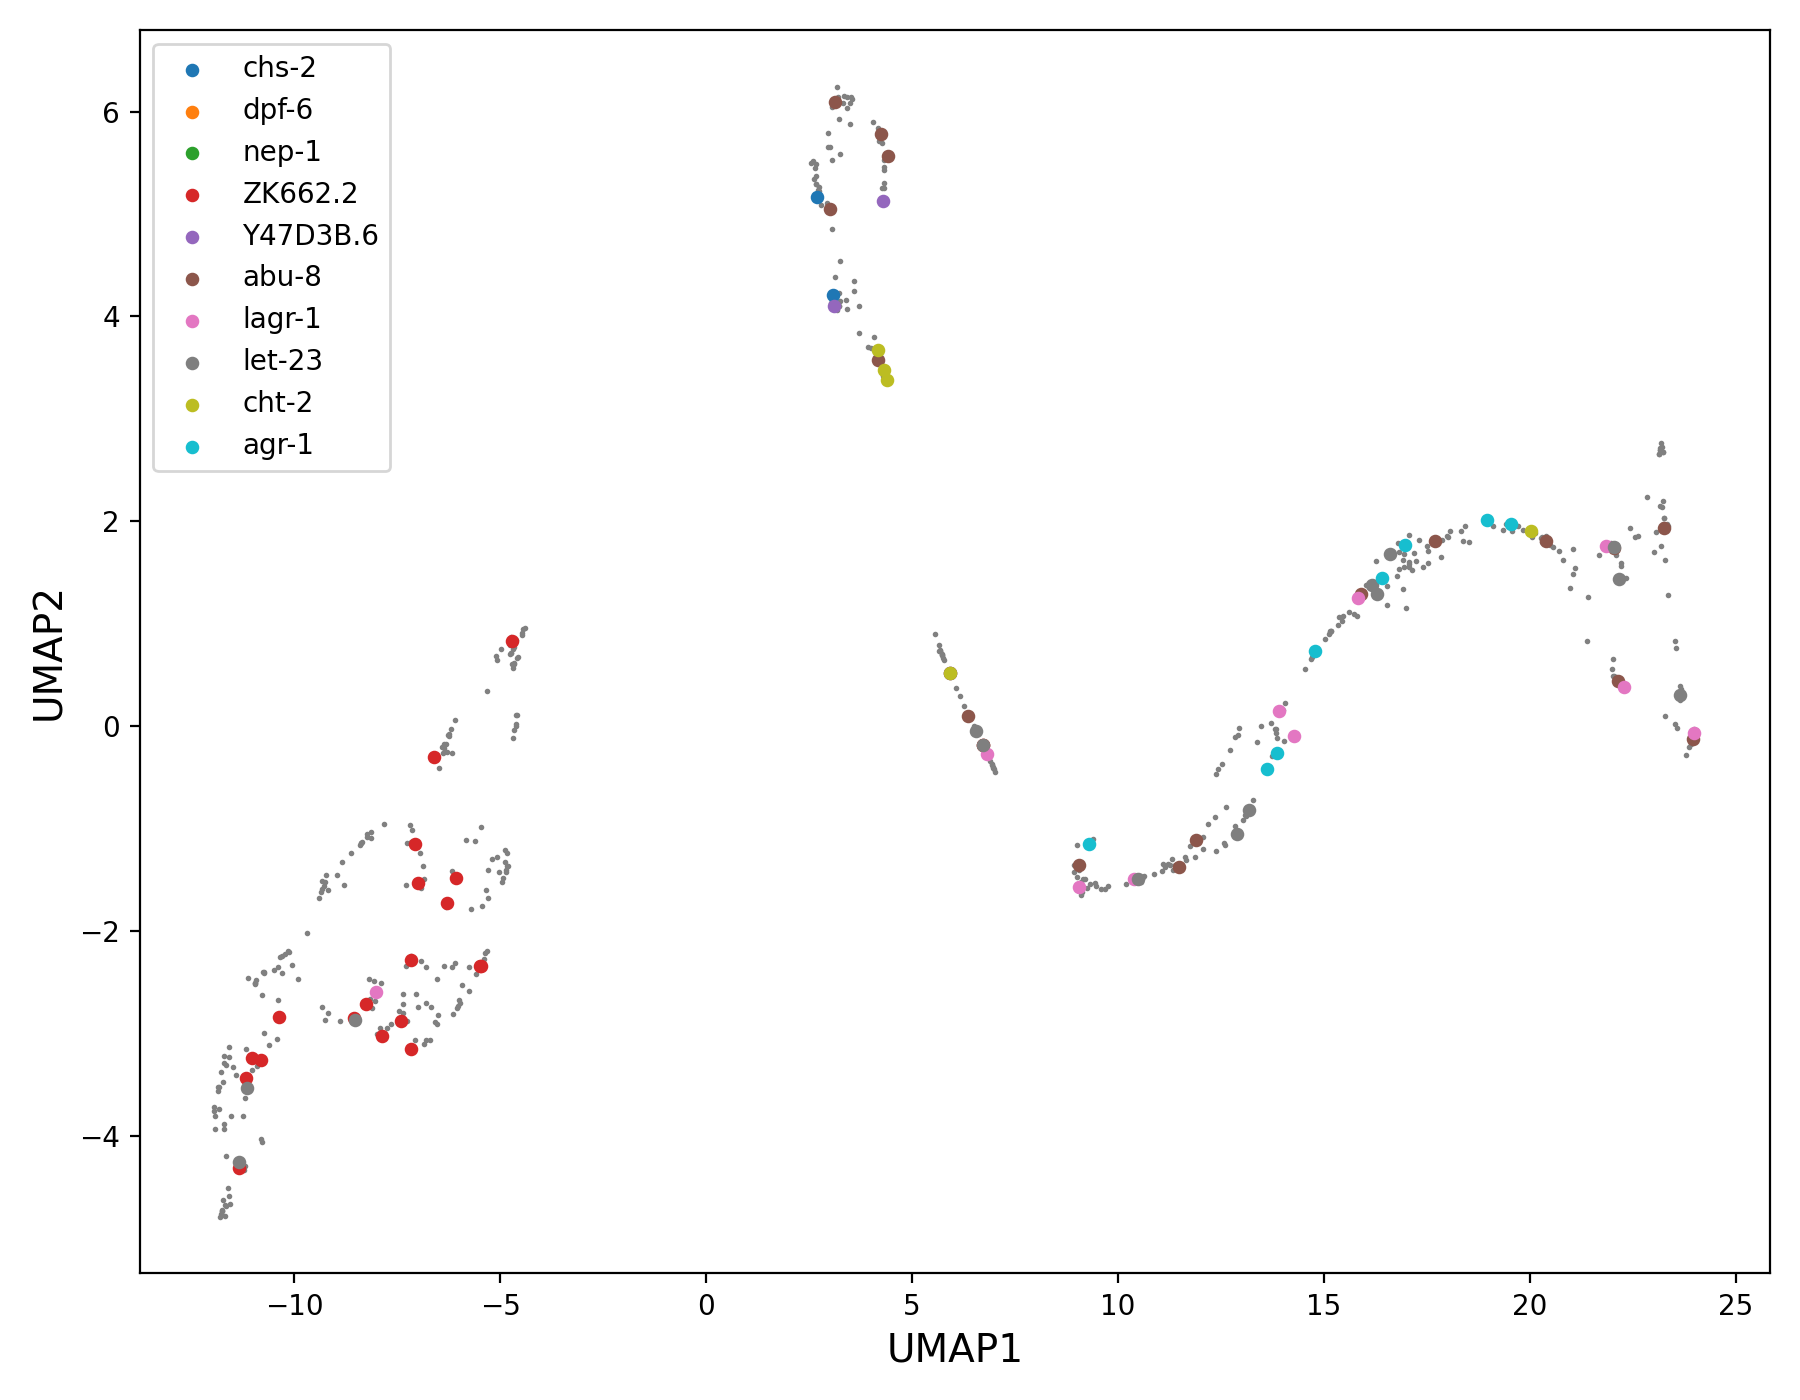

['chrII', 196984, 211941, 'chs-2', '0', '+']
[['chrII' '204919' '205119' 'name']]
[-7935]
['chrIII', 8038240, 8041374, 'dpf-6', '0', '+']
[]
[]
['chrII', 11654213, 11657172, 'nep-1', '0', '-']
[]
[]
['chrX', 15696699, 15698062, 'ZK662.2', '0', '+']
[['chrX' '15696205' '15696875' 'name']]
[494]
['chrIII', 11427134, 11428414, 'Y47D3B.6', '0', '+']
[['chrIII' '11428410' '11429040' 'name']]
[-1276]
['chrV', 5163268, 5194608, 'abu-8', '0', '-']
[['chrV' '5192746' '5193220' 'name']
 ['chrV' '5194407' '5195200' 'name']]
[-1388   592]
['chrI', 13724576, 13732046, 'lagr-1', '0', '-']
[['chrI' '13731863' '13732359' 'name']]
[313]
['chrII', 9197517, 9207210, 'let-23', '0', '+']
[['chrII' '9202492' '9202692' 'name']
 ['chrII' '9205404' '9206563' 'name']
 ['chrII' '9207072' '9207274' 'name']]
[-4975 -7887 -9555]
['chrII', 8520904, 8523490, 'cht-2', '0', '+']
[['chrII' '8520631' '8521009' 'name']]
[273]
['chrII', 6760683, 6775176, 'agr-1', '0', '-']
[['chrII' '6774939' '6775348' 'name']]
[172]


In [23]:
#Posterior_arcade_bin_1_mid_to_late_L2
gene_names = ['chs-2', 'dpf-6', 'nep-1', 'ZK662.2', 'Y47D3B.6', 'abu-8', 'lagr-1', 'let-23', 'cht-2', 'agr-1']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


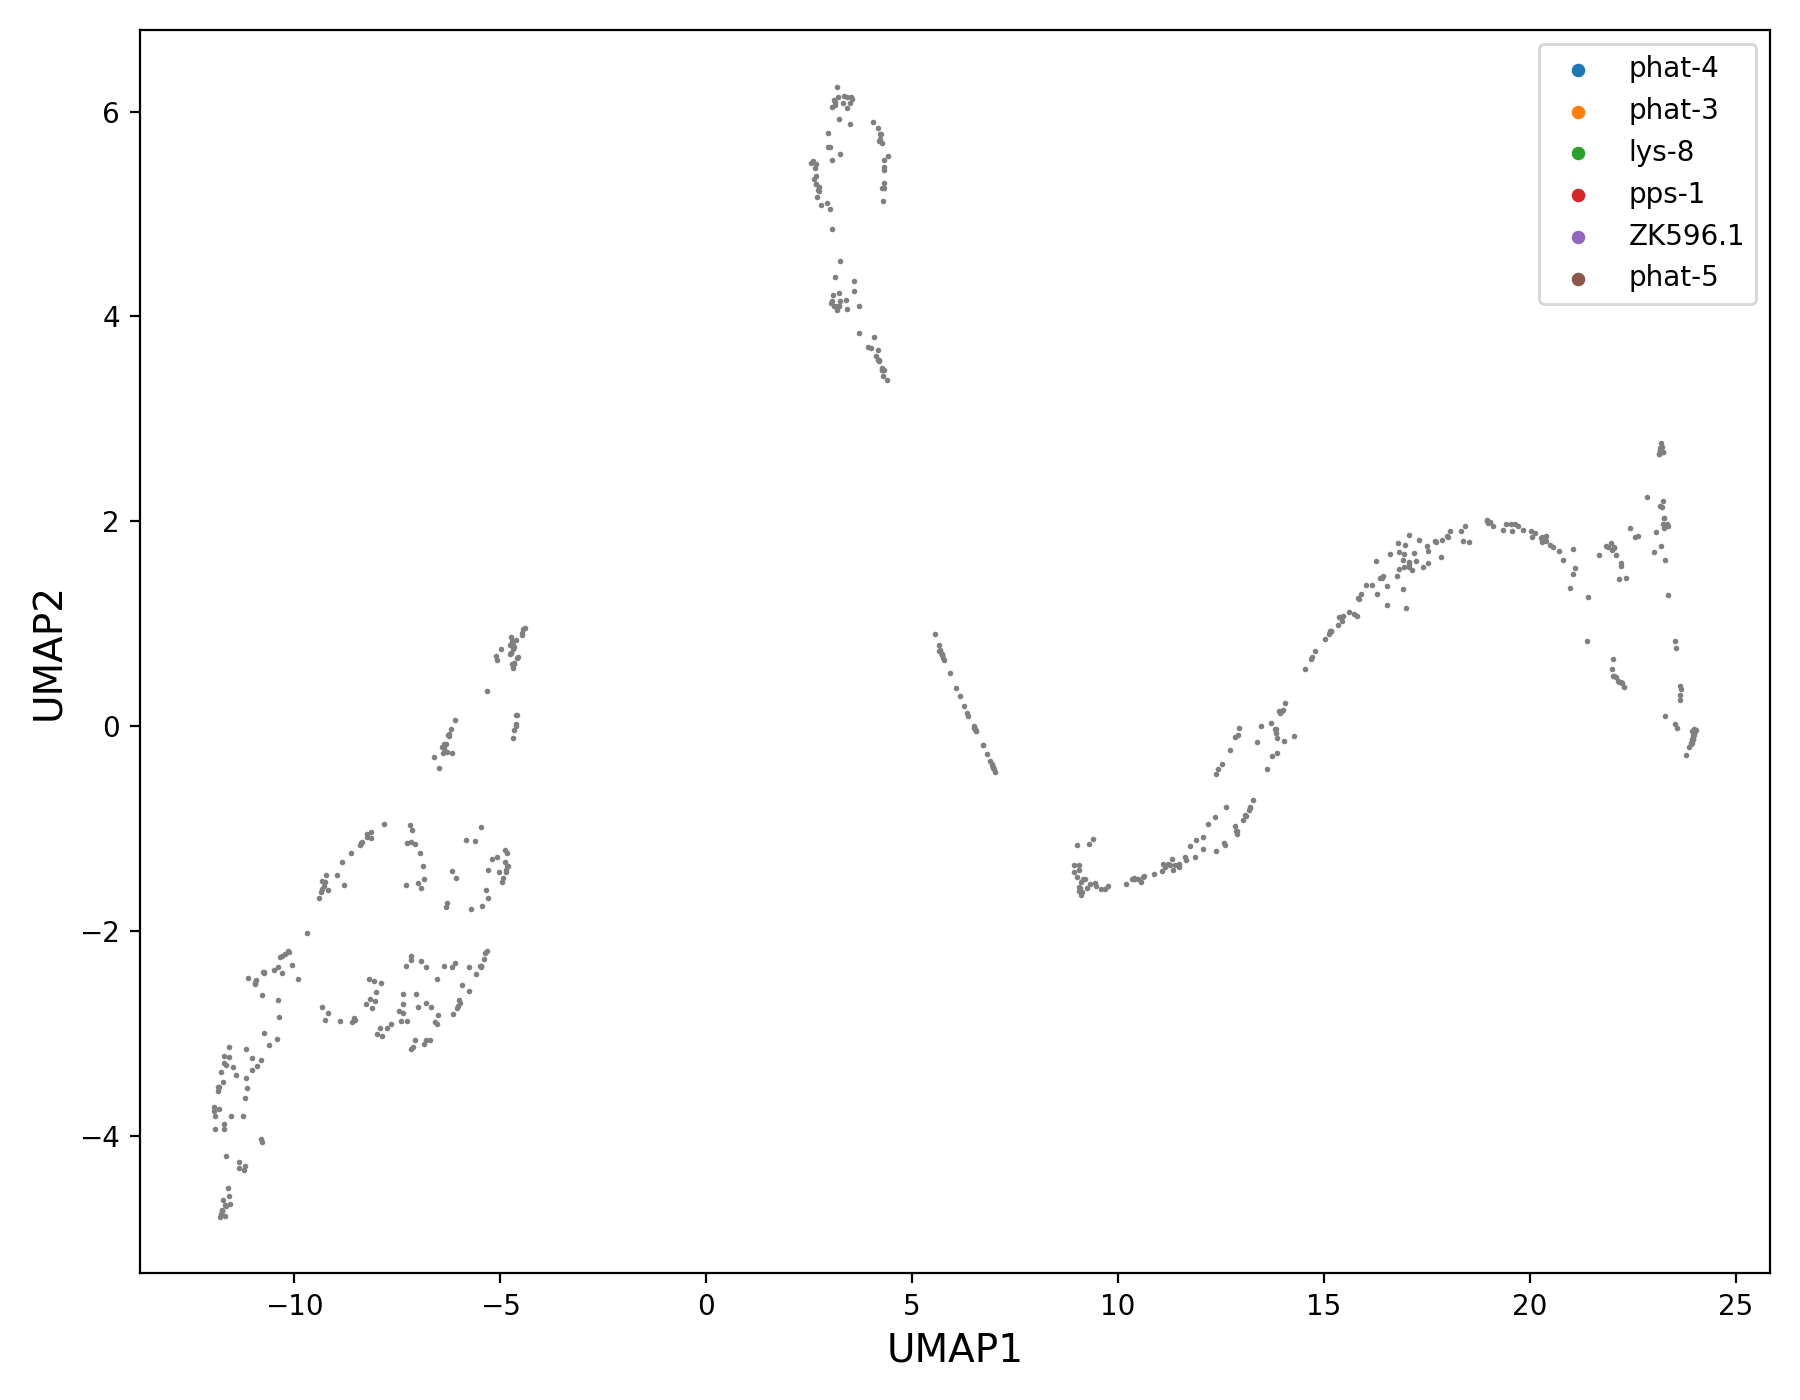

['chrV', 4129903, 4130909, 'phat-4', '0', '+']
[]
[]
['chrV', 4043915, 4044951, 'phat-3', '0', '+']
[]
[]
['chrII', 5586164, 5587651, 'lys-8', '0', '+']
[]
[]
['chrIV', 10162007, 10164390, 'pps-1', '0', '+']
[]
[]
['chrIV', 10900369, 10901386, 'ZK596.1', '0', '+']
[]
[]
['chrV', 4121488, 4122517, 'phat-5', '0', '-']
[]
[]


In [25]:
#g1A
gene_names = ['phat-4', 'phat-3', 'lys-8', 'pps-1', 'ZK596.1', 'phat-5']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


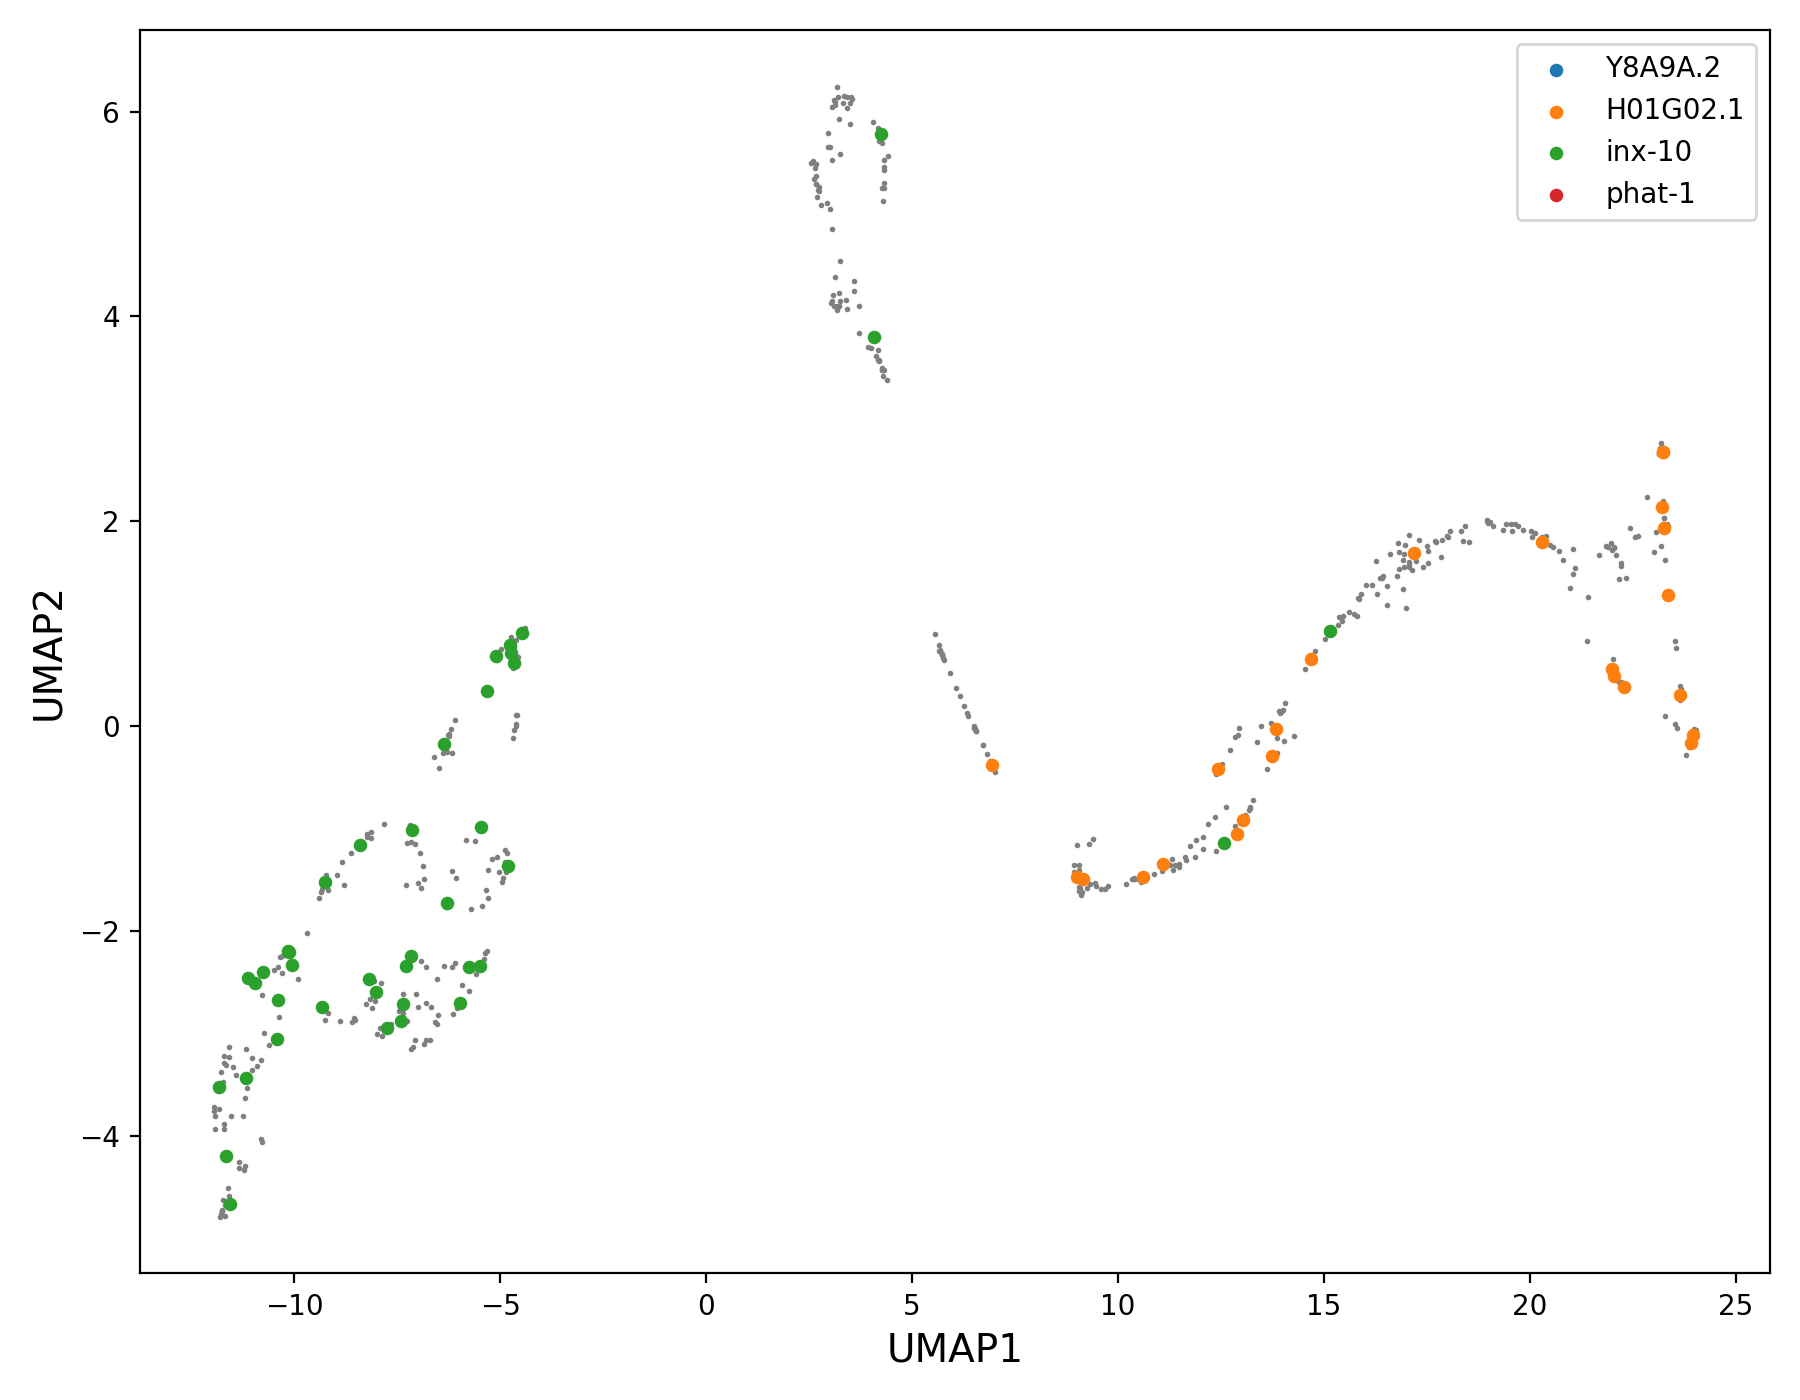

['chrII', 3795622, 3800608, 'Y8A9A.2', '0', '+']
[]
[]
['chrIV', 11803272, 11804152, 'H01G02.1', '0', '-']
[['chrIV' '11803309' '11803509' 'name']
 ['chrIV' '11804136' '11804336' 'name']
 ['chrIV' '11804622' '11805605' 'name']]
[-643  184 1453]
['chrV', 9204660, 9207467, 'inx-10', '0', '-']
[['chrV' '9205885' '9206221' 'name']
 ['chrV' '9206438' '9206638' 'name']
 ['chrV' '9206672' '9207569' 'name']
 ['chrV' '9207776' '9207976' 'name']
 ['chrV' '9208661' '9209619' 'name']]
[-1246  -829   102   509  2152]
['chrI', 5044200, 5045720, 'phat-1', '0', '-']
[]
[]


In [26]:
#g1P (all from g1A above except for phat-5, plus the ones below)
gene_names = ['Y8A9A.2', 'H01G02.1', 'inx-10', 'phat-1']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


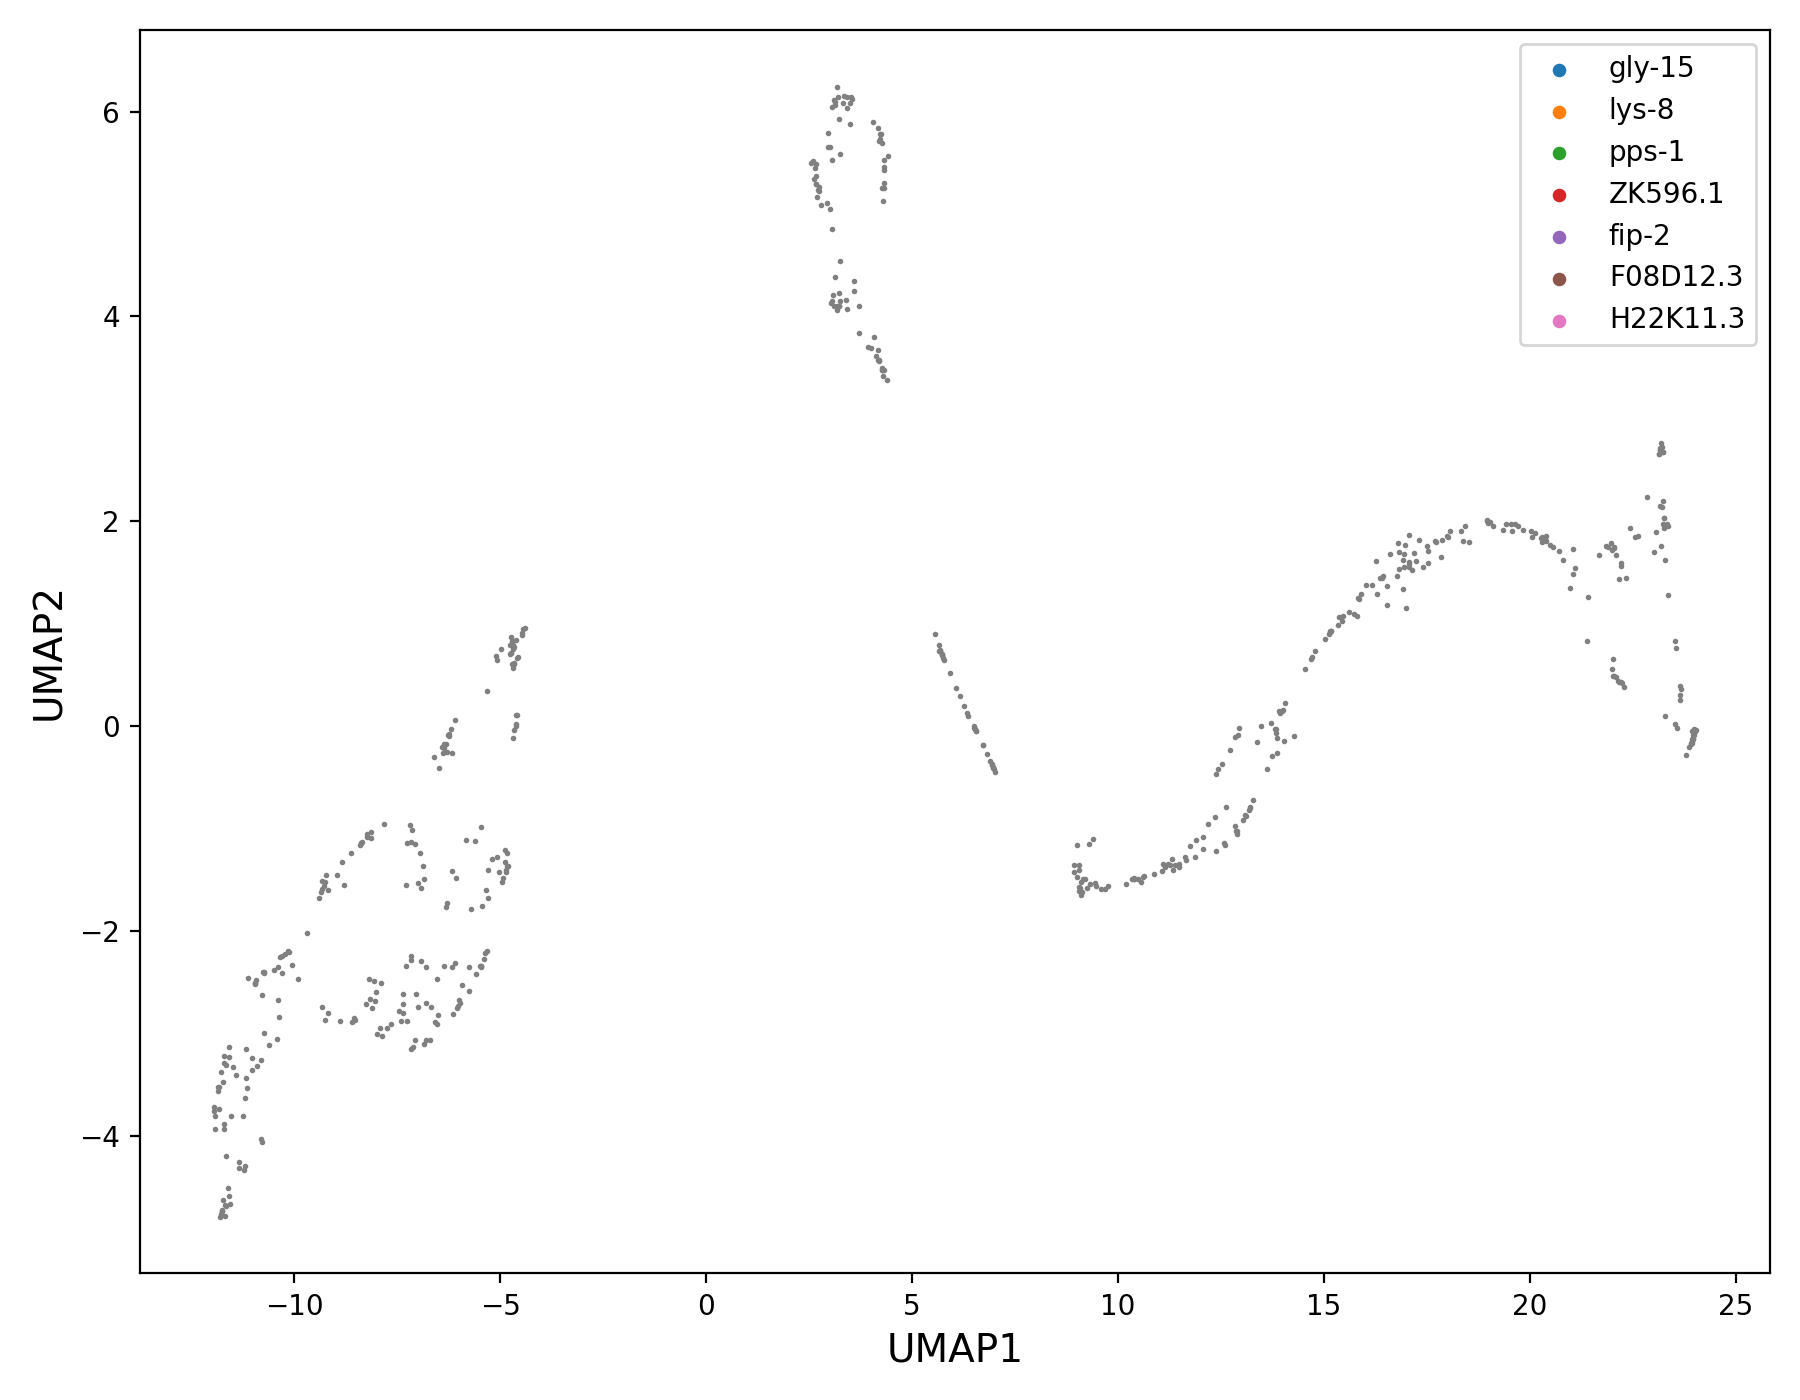

['chrI', 12462175, 12465831, 'gly-15', '0', '+']
[]
[]
['chrII', 5586164, 5587651, 'lys-8', '0', '+']
[]
[]
['chrIV', 10162007, 10164390, 'pps-1', '0', '+']
[]
[]
['chrIV', 10900369, 10901386, 'ZK596.1', '0', '+']
[]
[]
['chrV', 9067975, 9068390, 'fip-2', '0', '+']
[]
[]
['chrII', 2779543, 2780838, 'F08D12.3', '0', '+']
[]
[]
['chrX', 6783156, 6784197, 'H22K11.3', '0', '+']
[]
[]


In [27]:
#g2
gene_names = ['gly-15', 'lys-8', 'pps-1', 'ZK596.1', 'fip-2', 'F08D12.3', 'H22K11.3']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


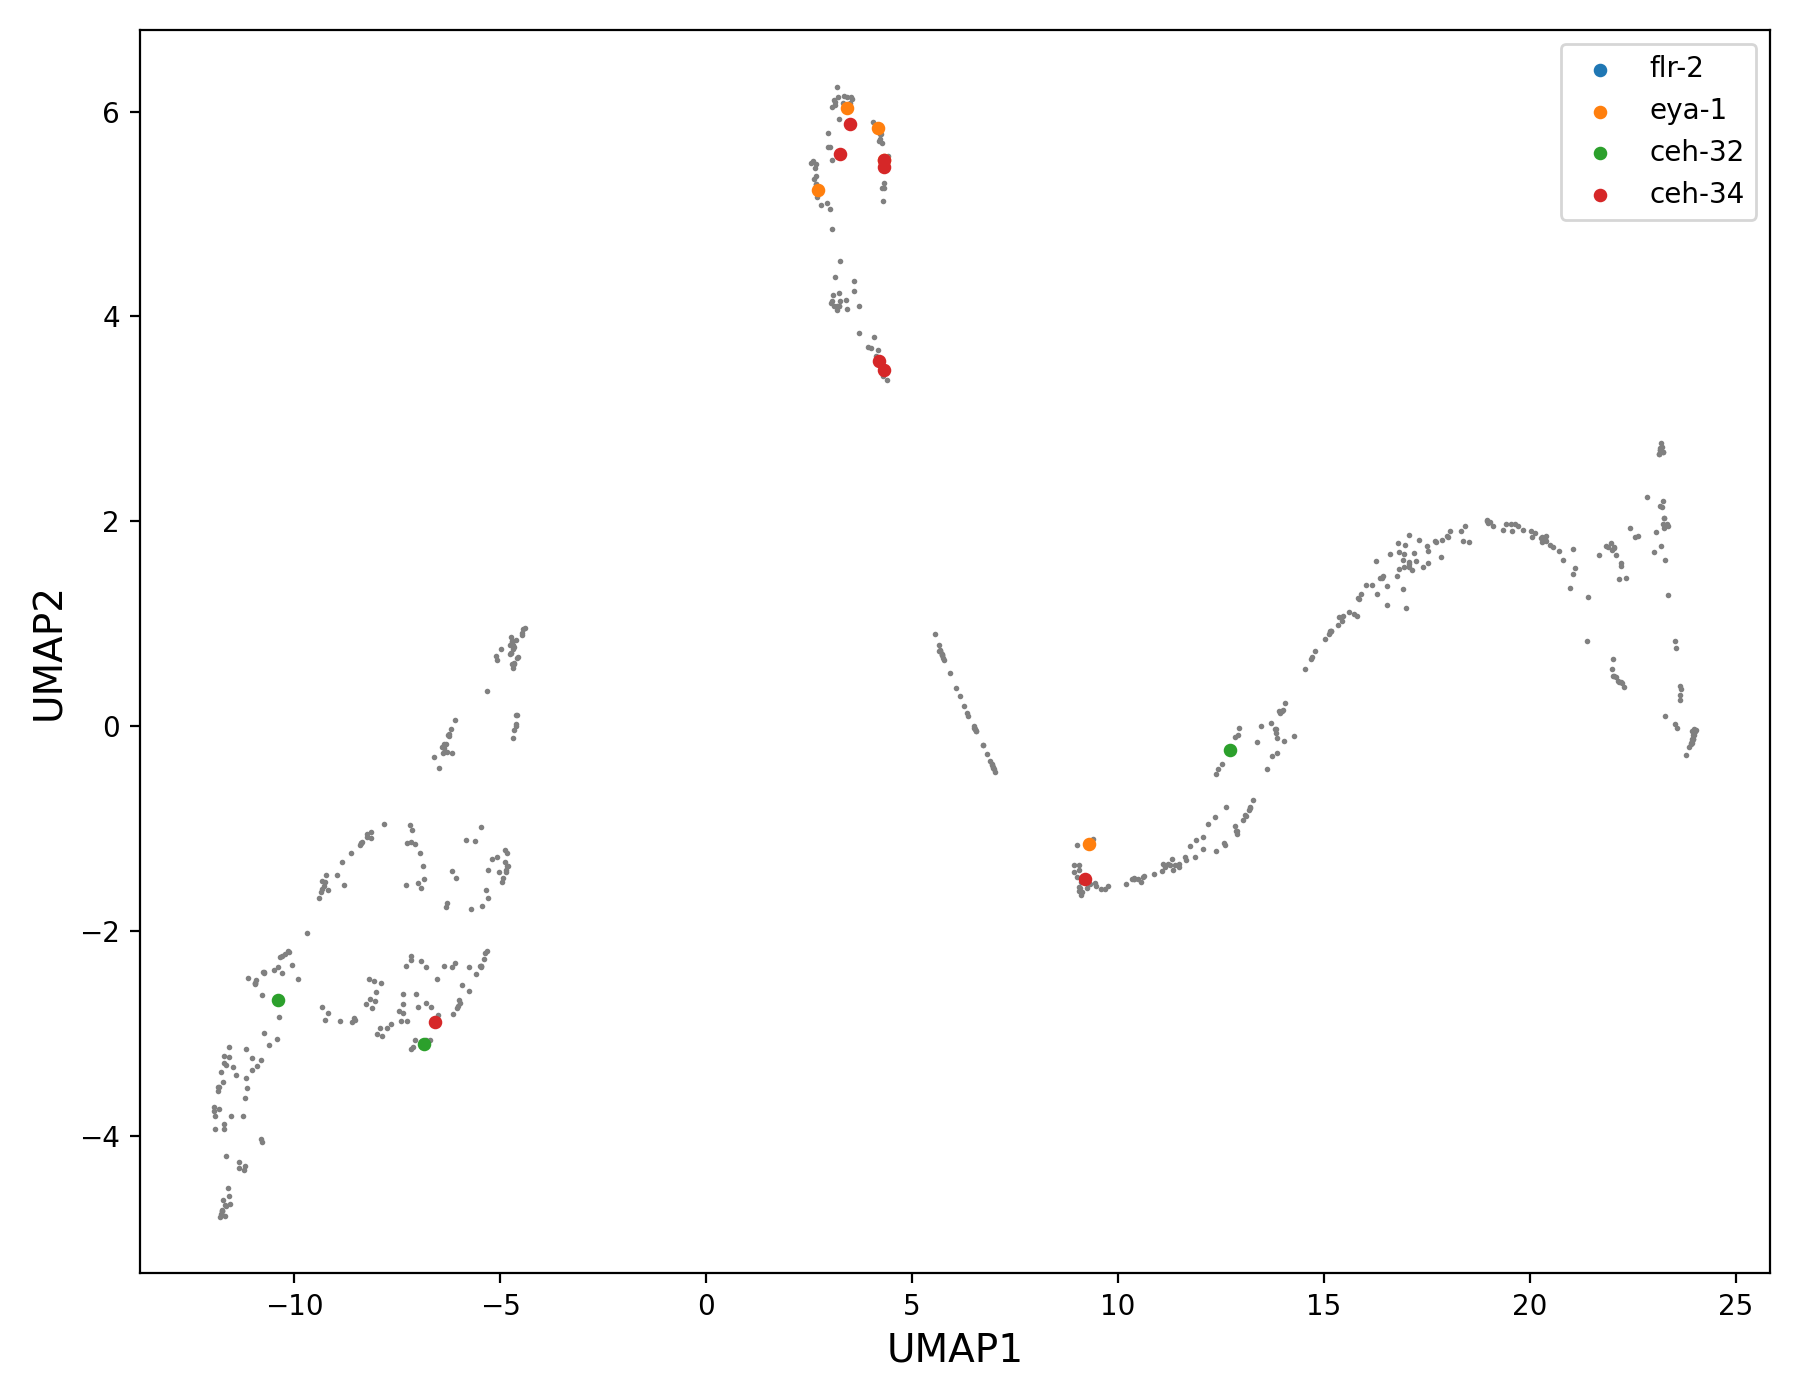

['chrV', 11936504, 11937794, 'flr-2', '0', '-']
[]
[]
['chrI', 14220782, 14231360, 'eya-1', '0', '-']
[['chrI' '14224241' '14224513' 'name']
 ['chrI' '14226274' '14226474' 'name']]
[-6847 -4886]
['chrV', 11701763, 11705400, 'ceh-32', '0', '-']
[['chrV' '11705554' '11705852' 'name']]
[452]
['chrV', 5315512, 5319577, 'ceh-34', '0', '-']
[['chrV' '5318245' '5318445' 'name']
 ['chrV' '5319243' '5320125' 'name']]
[-1132   548]


In [28]:
#pharyngeal neurons #1
gene_names = ['flr-2', 'eya-1', 'ceh-32', 'ceh-34']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


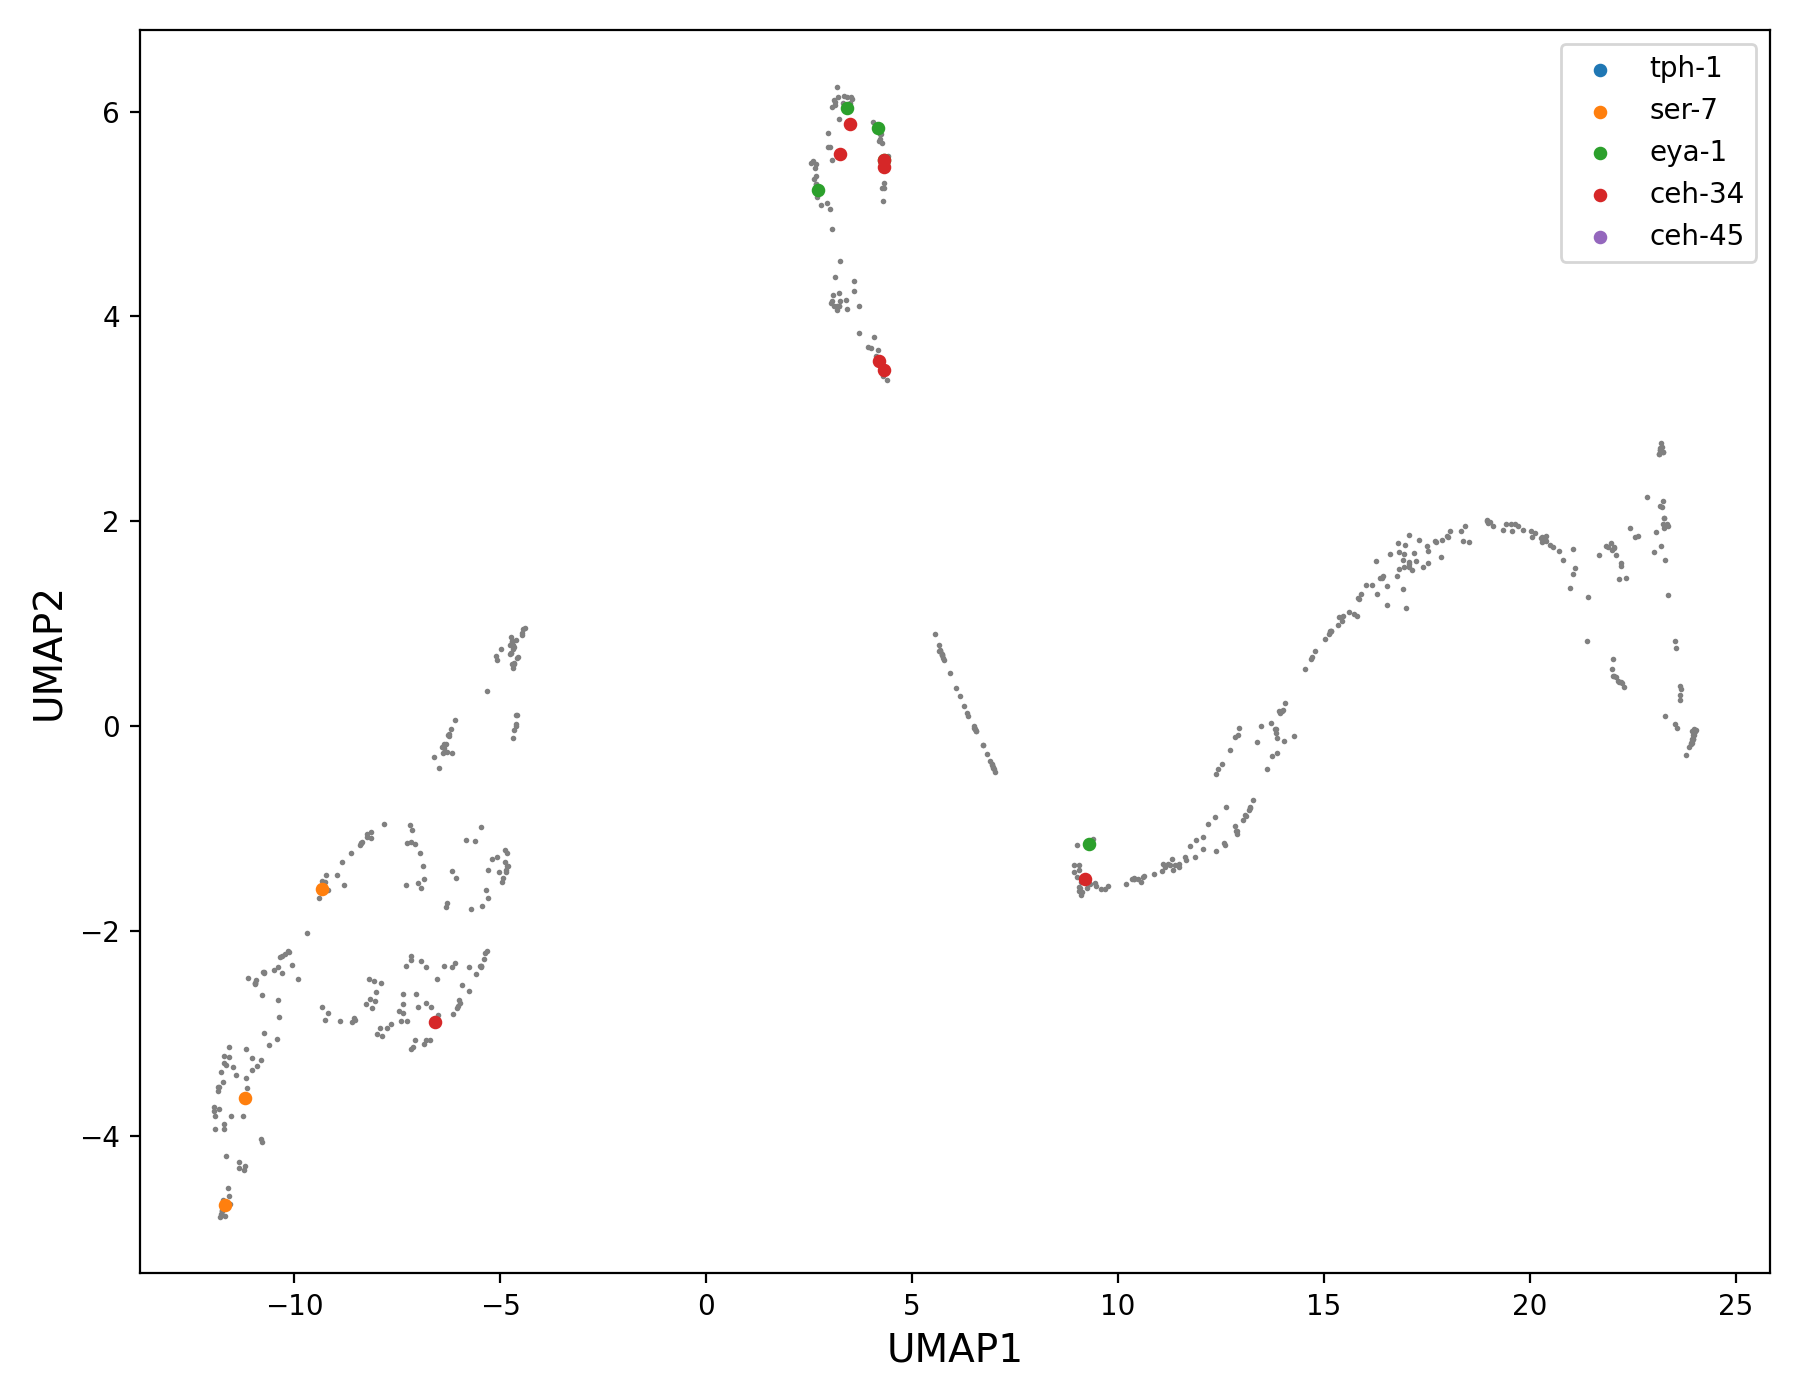

['chrII', 7549334, 7551977, 'tph-1', '0', '+']
[]
[]
['chrX', 2673470, 2682379, 'ser-7', '0', '+']
[['chrX' '2673611' '2673811' 'name']
 ['chrX' '2679470' '2679695' 'name']]
[ -141 -6000]
['chrI', 14220782, 14231360, 'eya-1', '0', '-']
[['chrI' '14224241' '14224513' 'name']
 ['chrI' '14226274' '14226474' 'name']]
[-6847 -4886]
['chrV', 5315512, 5319577, 'ceh-34', '0', '-']
[['chrV' '5318245' '5318445' 'name']
 ['chrV' '5319243' '5320125' 'name']]
[-1132   548]
['chrI', 1128323, 1131737, 'ceh-45', '0', '+']
[]
[]


In [29]:
#pharyngeal neurons #2
gene_names = ['tph-1', 'ser-7', 'eya-1', 'ceh-34', 'ceh-45']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


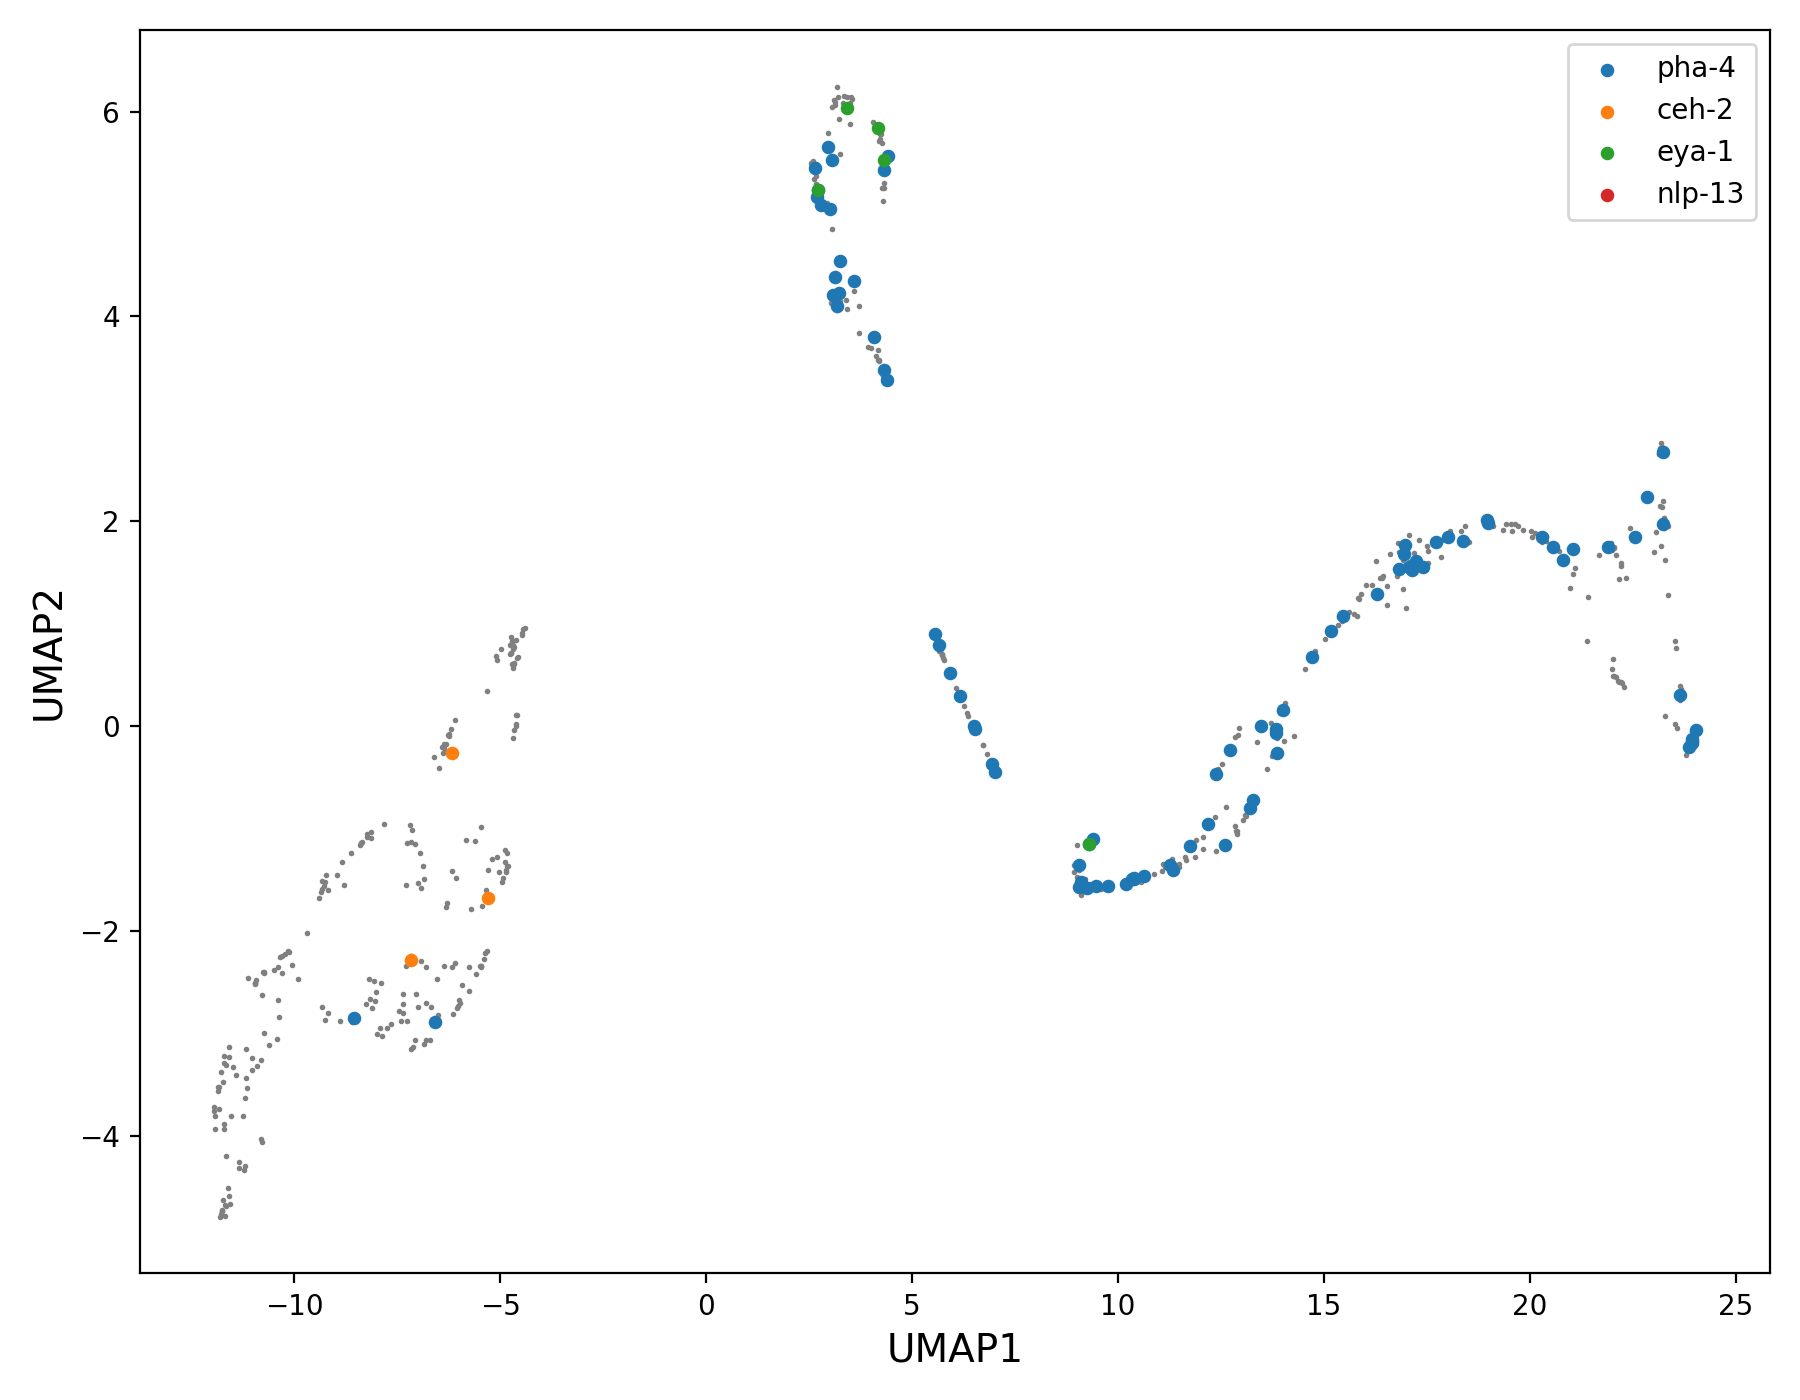

['chrV', 20753051, 20760303, 'pha-4', '0', '+']
[['chrV' '20751709' '20751909' 'name']
 ['chrV' '20752095' '20752999' 'name']
 ['chrV' '20753203' '20753403' 'name']
 ['chrV' '20754004' '20754252' 'name']
 ['chrV' '20755201' '20755682' 'name']
 ['chrV' '20756319' '20757485' 'name']
 ['chrV' '20758450' '20758900' 'name']
 ['chrV' '20758951' '20759732' 'name']
 ['chrV' '20759750' '20761448' 'name']]
[ 1342   956  -152  -953 -2150 -3268 -5399 -5900 -6699]
['chrI', 6046831, 6050462, 'ceh-2', '0', '-']
[['chrI' '6051160' '6051401' 'name']]
[939]
['chrI', 14220782, 14231360, 'eya-1', '0', '-']
[['chrI' '14224241' '14224513' 'name']
 ['chrI' '14226274' '14226474' 'name']]
[-6847 -4886]
['chrV', 4236417, 4238056, 'nlp-13', '0', '+']
[]
[]


In [30]:
#pharyngeal neurons #3
gene_names = ['pha-4', 'ceh-2', 'eya-1', 'nlp-13']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=15)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


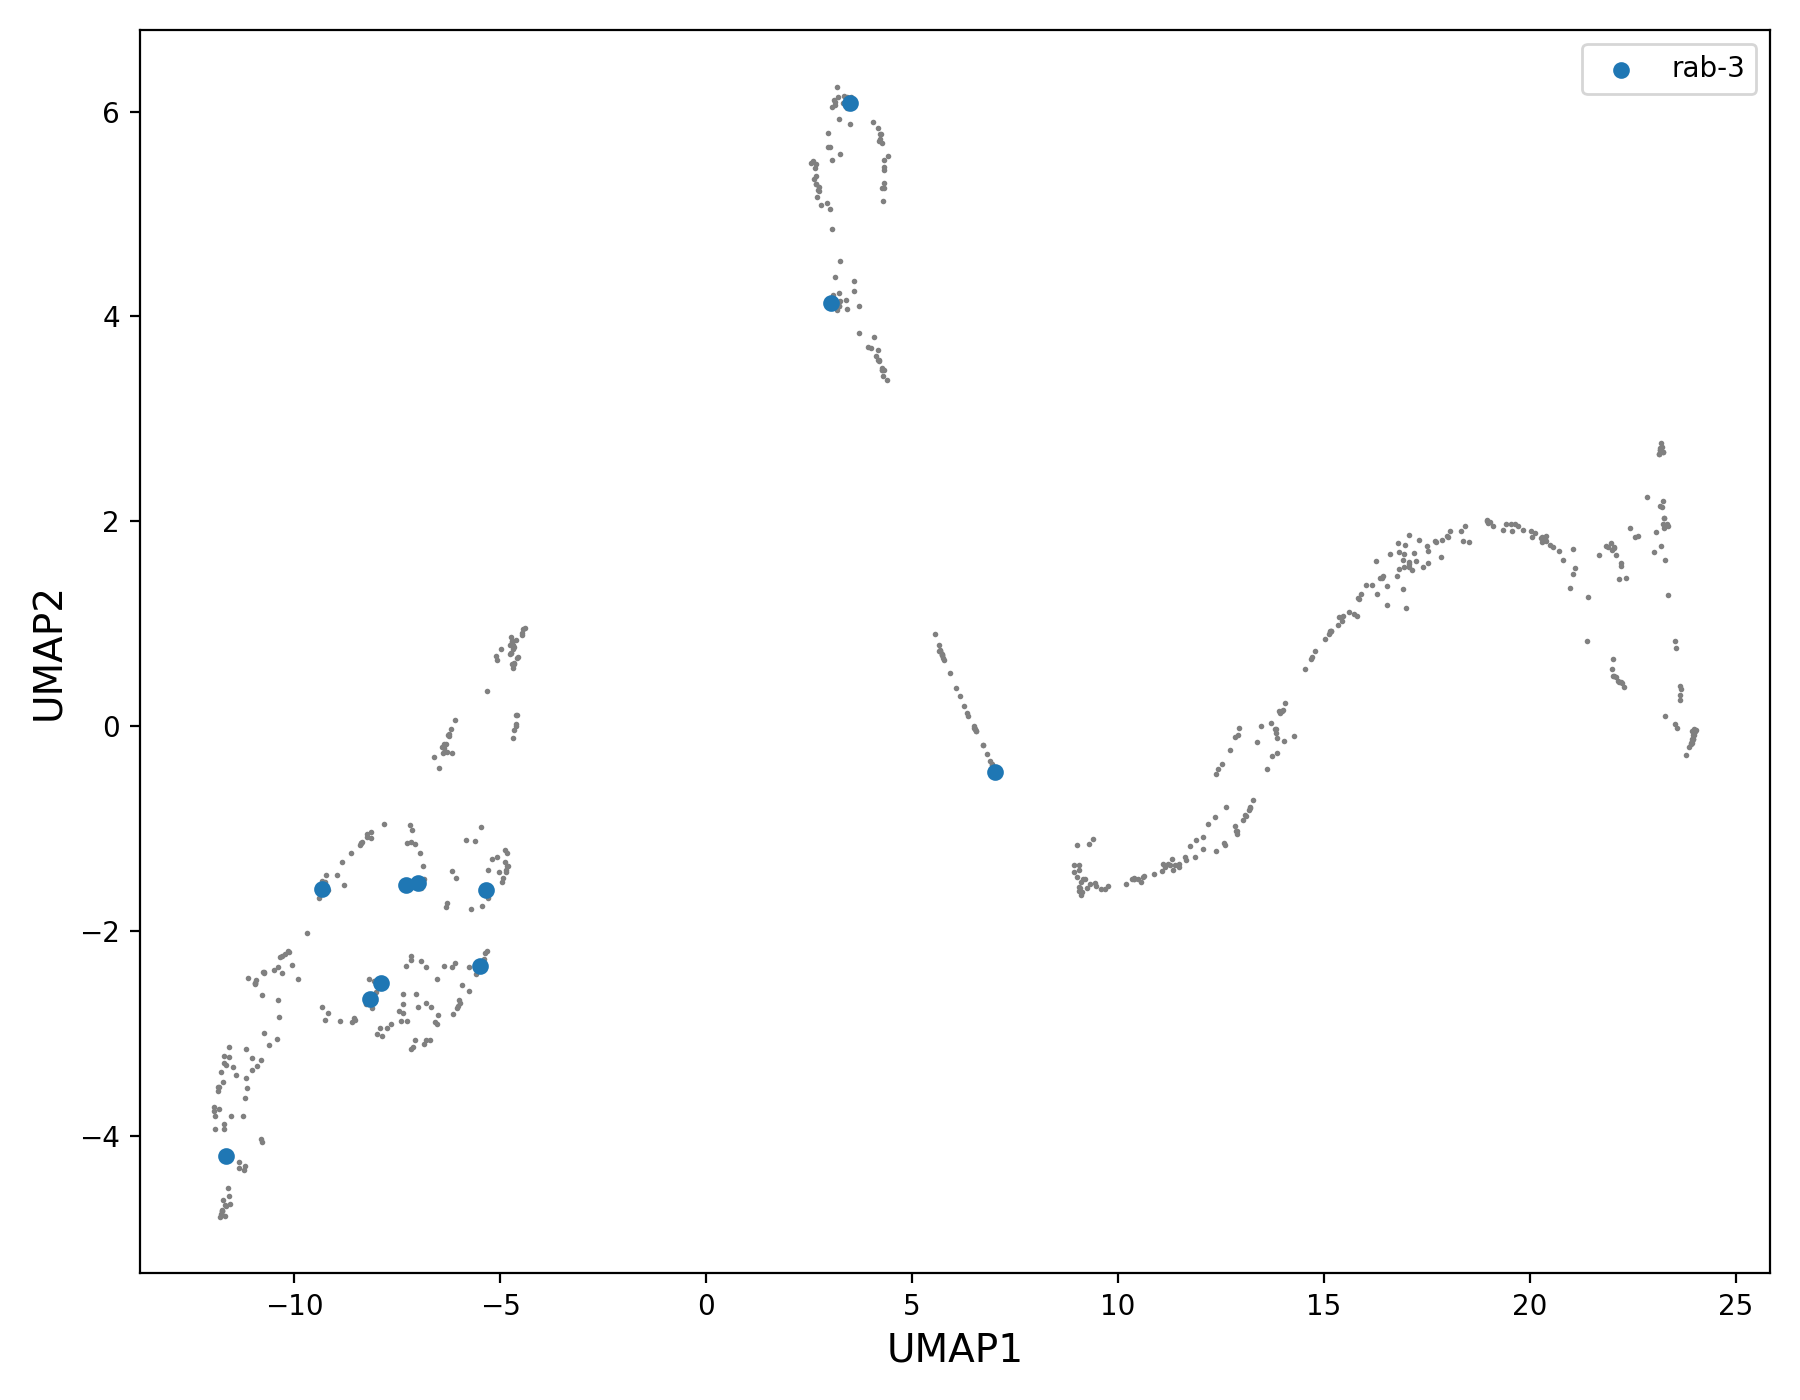

['chrII', 5721790, 5727651, 'rab-3', '0', '-']
[['chrII' '5723825' '5724025' 'name']
 ['chrII' '5725067' '5725415' 'name']]
[-3626 -2236]


In [31]:
#neurons
gene_names = ['rab-3']

not_in_clust_idx = numpy.ones(doctopic_peaks_umap2_res.shape[0])
in_clust_idx = []
in_clust_colors = []
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,7))
for idx, gname in enumerate(gene_names):
    have_gene = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True)
    have_gene_idx = list(numpy.where(have_gene)[0])
    not_in_clust_idx = numpy.logical_and(not_in_clust_idx, ~have_gene)
    s = axes.scatter(doctopic_peaks_umap2_res[have_gene_idx,0], 
                     doctopic_peaks_umap2_res[have_gene_idx,1],
                     label=gname,
                     zorder=1,
                     s=25)
axes.scatter(doctopic_peaks_umap2_res[not_in_clust_idx,0], 
             doctopic_peaks_umap2_res[not_in_clust_idx,1], 
             c='grey',
             zorder=0,
             s=1)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(loc='best')
fig.tight_layout()

['chrIII', 4189379, 4190341, 'R74.10', '0', '-']
[['chrIII' '4188972' '4189754' 'name']
 ['chrIII' '4189818' '4190154' 'name']
 ['chrIII' '4190227' '4190921' 'name']
 ['chrIII' '4191251' '4191724' 'name']]
[-587 -187  580 1383]
['chrX', 7029135, 7029638, 'flp-26', '0', '+']
[]
[]
['chrI', 12218432, 12222298, 'F14B6.2', '0', '-']
[['chrI' '12223141' '12223391' 'name']]
[1093]
['chrIII', 2561709, 2566589, 'nhr-239', '0', '+']
[]
[]
['chrIV', 7696931, 7698420, 'flp-13', '0', '-']
[]
[]
['chrV', 20547260, 20551164, 'Y38H6C.20', '0', '-']
[]
[]
['chrV', 11833628, 11835708, 'pho-8', '0', '+']
[]
[]
['chrV', 14033949, 14034393, 'ins-10', '0', '+']
[]
[]
['chrX', 10087313, 10087958, 'flp-28', '0', '-']
[['chrX' '10086759' '10087477' 'name']
 ['chrX' '10088210' '10088573' 'name']]
[-481  615]
['chrI', 4589379, 4589899, 'D1007.19', '0', '-']
[]
[]
['chrIV', 10637059, 10639213, 'F56C4.1', '0', '+']
[]
[]
['chrIII', 3249366, 3250538, 'Y53G8AL.4', '0', '-']
[['chrIII' '3248720' '3249003' 'name']
 [

<IPython.core.display.Javascript object>


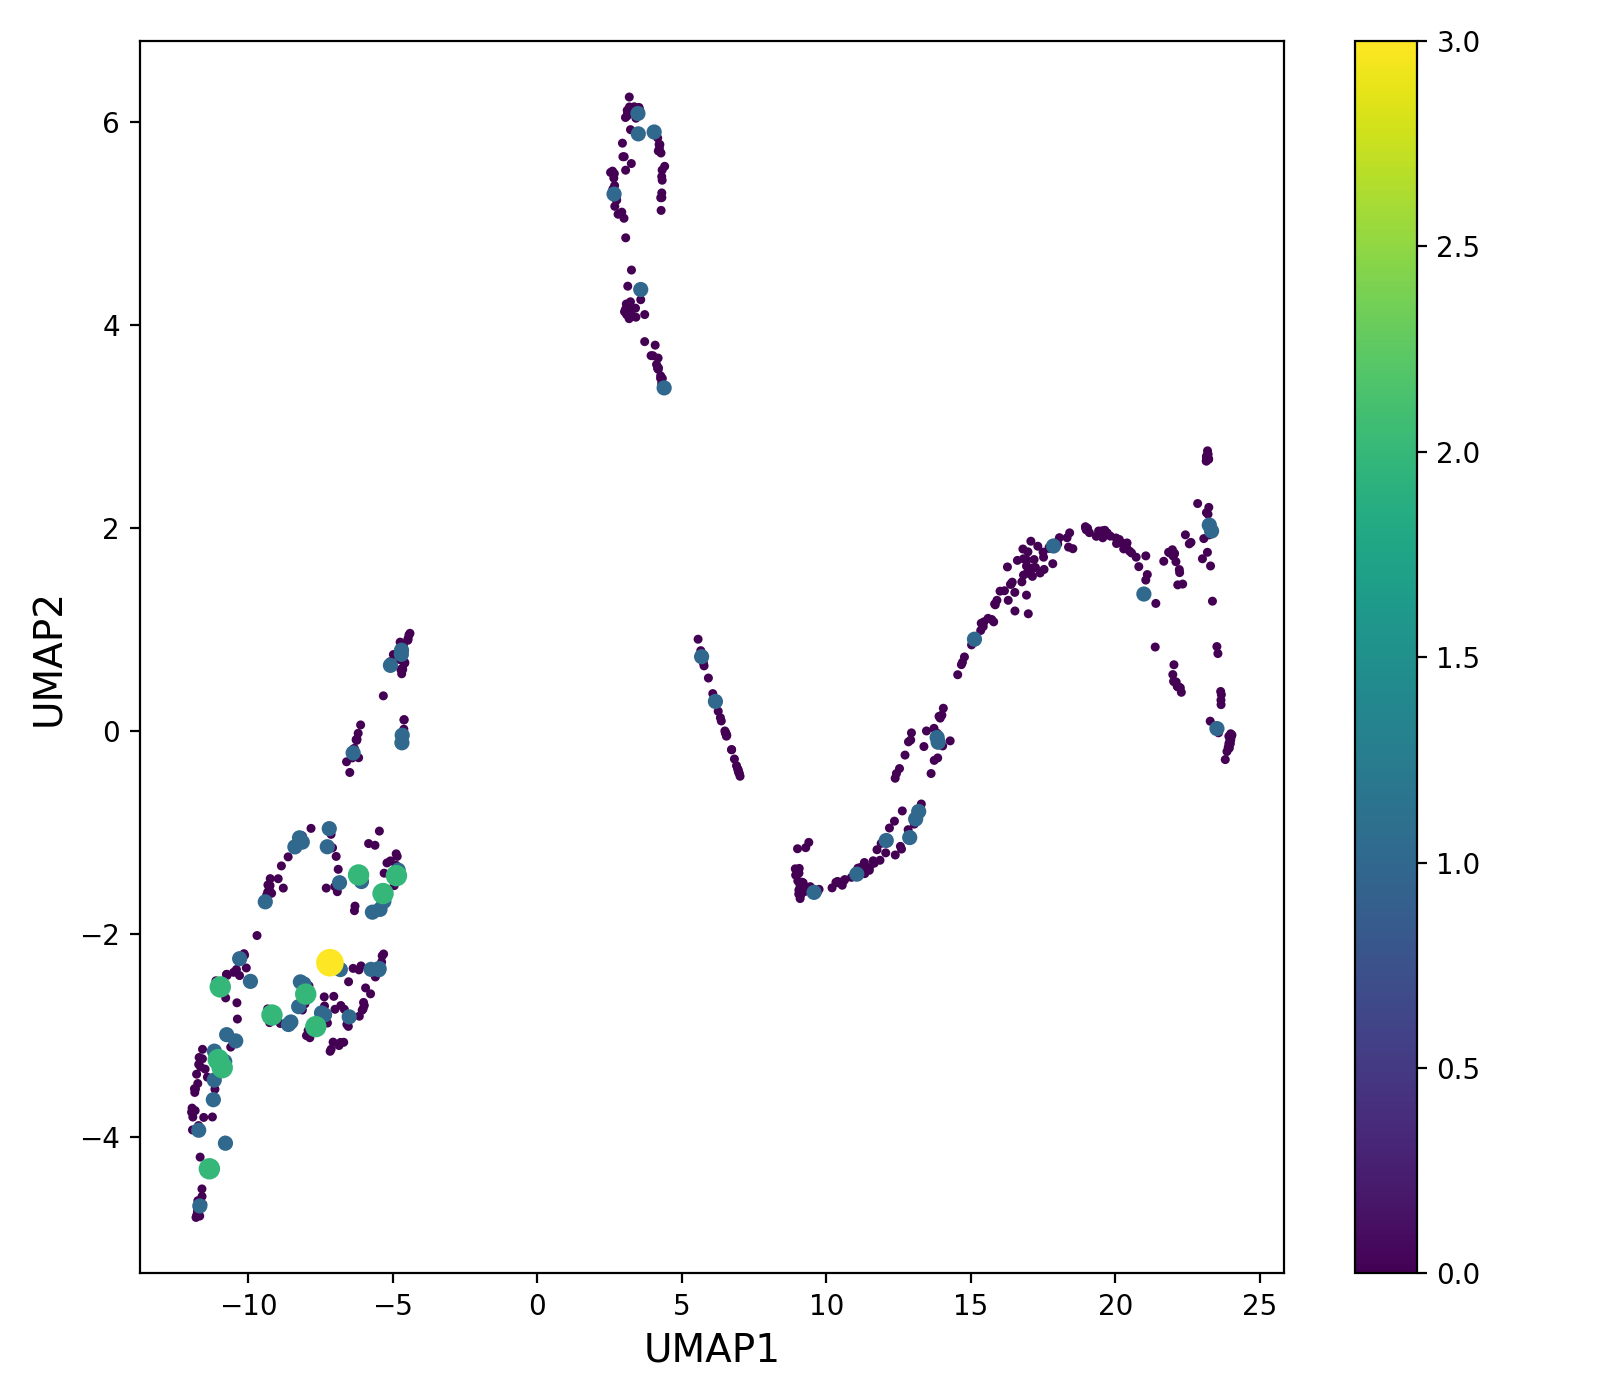

In [33]:
#pharyngeal neurons (gexplore)
gene_names = ['R74.10', 'flp-26', 'F14B6.2', 'F56A11.7', 'nhr-239', 'flp-13', 'Y38H6C.20', 'pho-8', 'ins-10',
              'T21C12.3', 'flp-28', 'D1007.19', 'F56C4.1', 'nlp-54', 'Y53G8AL.4', 'degt-1', 'del-3', 'aqp-5',
              'srsx-17', 'K07H8.11', 'flr-2', 'C46C2.3', 'F33D11.8', 'Y75B8A.44', 'irk-1', 'Y75B8A.11', 'cnp-2',
              'nlp-6', 'tph-1', 'flp-22', 'C25G6.4']

#have_gene_arr = []
have_gene_sum = numpy.zeros(peak_data_array.shape[0])
for idx, gname in enumerate(gene_names):
    try:
        have_gene_idx = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True, 
                                       dist_threshold=1200, gene_end_threshold=600)
    except KeyError:
        continue
    have_gene_sum[have_gene_idx] += 1

plot_order = numpy.argsort(have_gene_sum)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,7))
s = axes.scatter(doctopic_peaks_umap2_res[plot_order, 0], 
                 doctopic_peaks_umap2_res[plot_order, 1], 
                 c=have_gene_sum[plot_order],
                 cmap='viridis',
                 s=5*(have_gene_sum[plot_order] + 1)**2)

axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
cbar = fig.colorbar(s)
#cbar.ax.set_yticklabels(gene_names, fontsize=10)
fig.tight_layout()

['chrI', 5042101, 5043453, 'C46H11.7', '0', '-']
[]
[]
['chrX', 10967301, 10967798, 'K09C8.9', '0', '-']
[]
[]
['chrV', 4126318, 4127535, 'T05B4.13', '0', '-']
[]
[]
['chrV', 6590582, 6593634, 'ZK1055.2', '0', '+']
[['chrV' '6589473' '6590038' 'name']
 ['chrV' '6593838' '6594038' 'name']]
[ 1109 -3256]
['chrIV', 15533166, 15539959, 'Y73F8A.35', '0', '-']
[['chrIV' '15539902' '15540131' 'name']]
[172]
['chrIV', 4342356, 4346558, 'oac-52', '0', '-']
[['chrIV' '4347211' '4347657' 'name']]
[1099]
['chrII', 6748631, 6749522, 'F41G3.10', '0', '-']
[['chrII' '6748850' '6749159' 'name']]
[-363]
['chrV', 7626849, 7627780, 'F07C4.6', '0', '+']
[]
[]
['chrIV', 14511883, 14512505, 'Y57G11A.5', '0', '-']
[]
[]
['chrIV', 15167799, 15175536, 'Y40H7A.4', '0', '-']
[]
[]
['chrX', 3531840, 3532811, 'F56B6.6', '0', '-']
[]
[]
['chrI', 5050039, 5052523, 'C46H11.2', '0', '+']
[]
[]
['chrIV', 12925865, 12926805, 'C32H11.6', '0', '-']
[]
[]
['chrII', 3795622, 3800608, 'Y8A9A.2', '0', '+']
[]
[]
['chrIV', 751

<IPython.core.display.Javascript object>


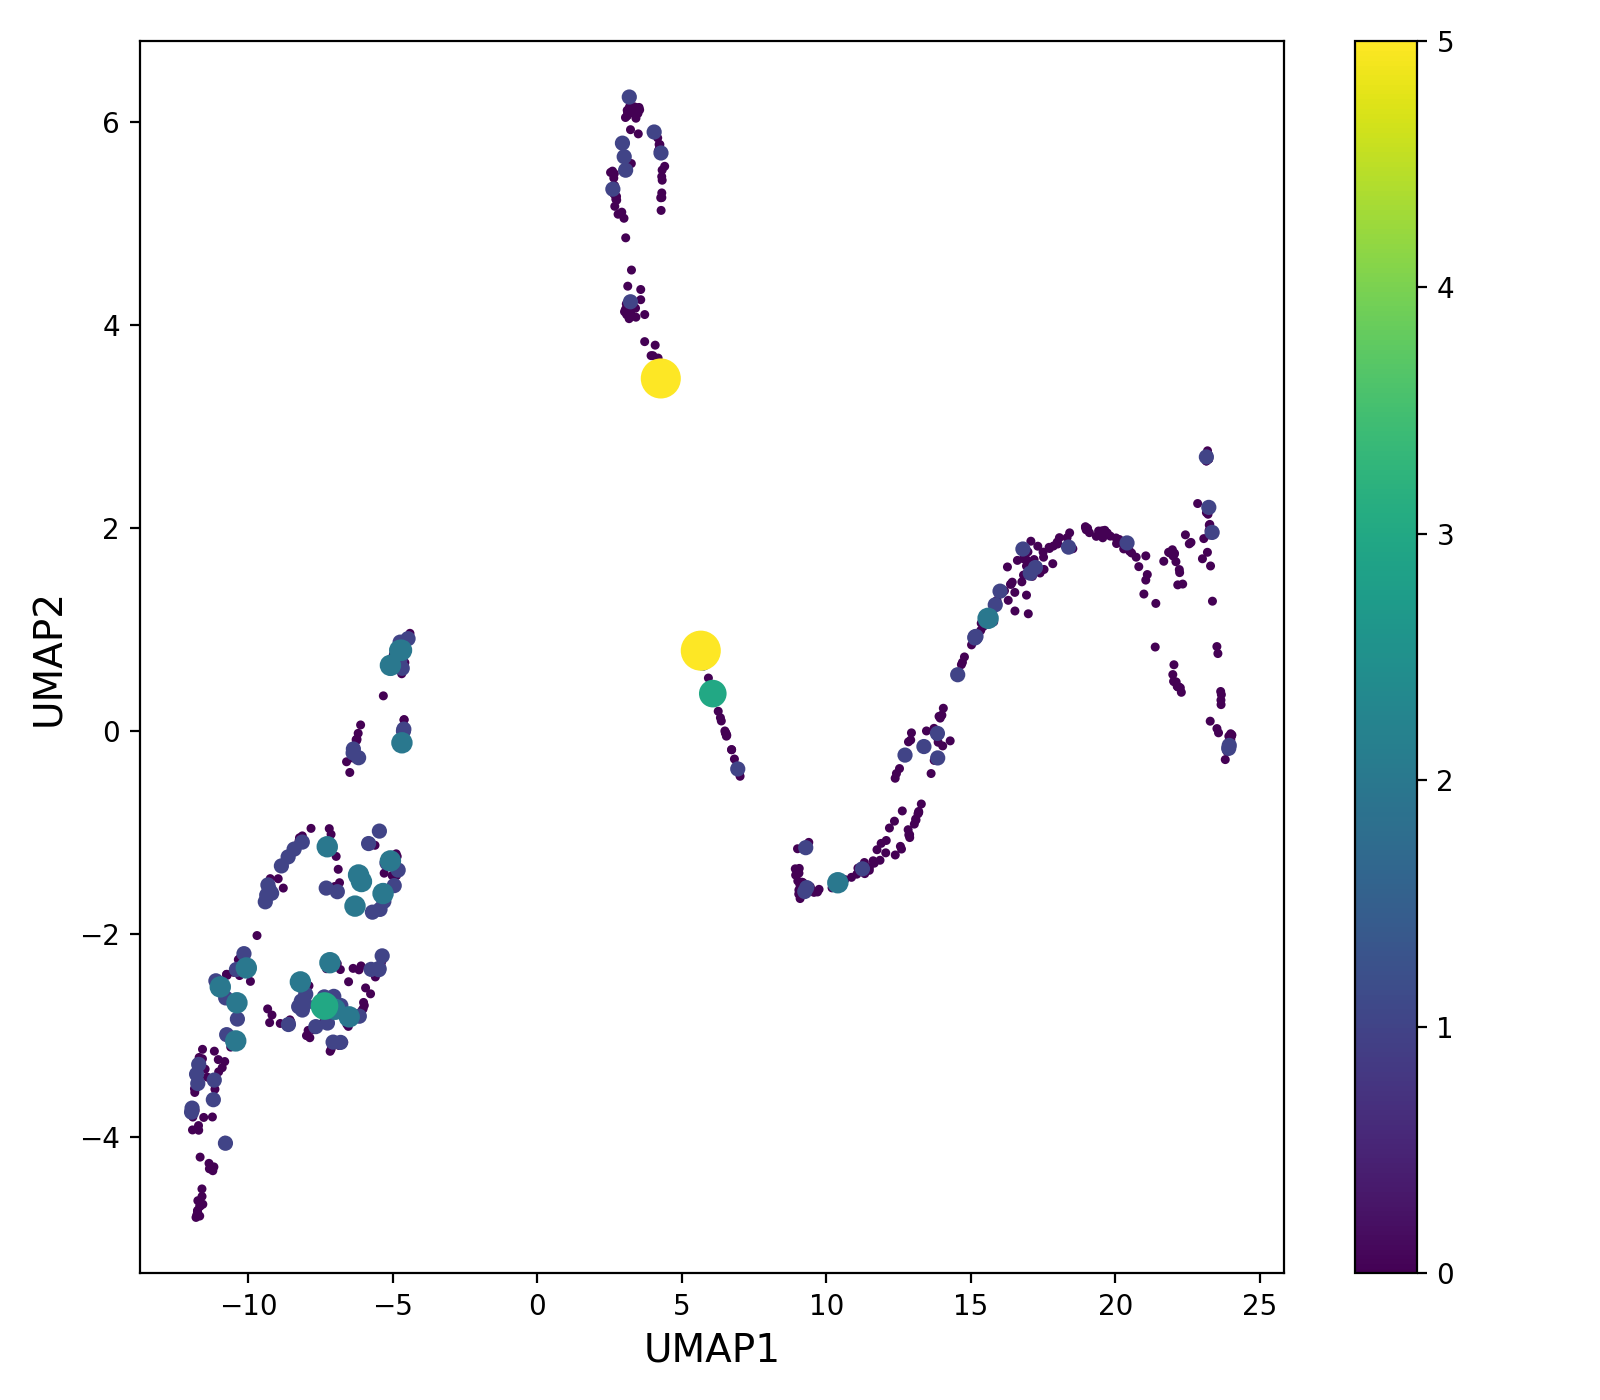

In [35]:
#pharyngeal gland (gexplore)
gene_names = ['C46H11.7', 'K09C8.9', 'scl=6', 'R06F6.7', 'T05B4.13', 'ZK1055.2', 'Y73F8A.35', 'oac-52',
              'F41G3.10', 'F07C4.6', 'Y57G11A.5', 'Y40H7A.4', 'F56B6.6', 'C46H11.2', 'C32H11.6', 'Y8A9A.2',
              'R05G6.9', 'C50F2.7', 'rsef-1', 'C43F9.5', 'Y41D4A.1', 'F23H11.7', 'F08D12.3', 'F15A4.6', 'phat-4',
              'T25D3.3', 'nhr-222', 'tag-293', 'B0310.6', 'R09H10.2', 'phat=1', 'B0507.1', 'T05A10.6',
              'R12E2.8', 'F08D12.2', 'fip-2', 'R06F6.14', 'B0280.7', 'oac-49', 'ZK596.1', 'F41G3.21', 'F35A5.2',
              'Y9D1A.1', 'phat-5', 'C43F9.4', 'F08A8.5', 'F54F11.1', 'pqn-8', 'ceh-6', 'Y62F5A.9', 'C39D10.6',
              'F07C4.11', 'F58D5.3', 'F48E3.8', 'phat-3', 'zeel-1', 'clec-21', 'F28H7.7', 'nhr-199', 'C54D10.3',
              'nas-5', 'Y40H7A.3', 'C49G7.3', 'phat-6', 'dod-6', 'M04G7.1', 'F38B6.3', 'Y37F4.8', 'pqn-75',
              'abf-2', 'scl-5', 'T11F8.12', 'phat-2', 'D1044.7', 'cpg-8', 'F15D4.4', 'H22K11.3', 'Y45F3A.8',
              'lmd-5', 'pqn-88', 'Y71G12B.26', 'lys-8', 'ZK1053.3', 'hlh-6', 'C32H11.5', 'phy-4', 'M163.8',
              'nas-12', 'T20G5.8', 'oac-48', 'pqn-25', 'tpst-2', 'F23H11.6']

#have_gene_arr = []
have_gene_sum = numpy.zeros(peak_data_array.shape[0])
for idx, gname in enumerate(gene_names):
    try:
        have_gene_idx = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True, 
                                       dist_threshold=1200, gene_end_threshold=600)
    except KeyError:
        continue
    have_gene_sum[have_gene_idx] += 1

plot_order = numpy.argsort(have_gene_sum)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,7))
s = axes.scatter(doctopic_peaks_umap2_res[plot_order, 0], 
                 doctopic_peaks_umap2_res[plot_order, 1], 
                 c=have_gene_sum[plot_order],
                 cmap='viridis',
                 s=5*(have_gene_sum[plot_order] + 1)**2)

axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
cbar = fig.colorbar(s)
#cbar.ax.set_yticklabels(gene_names, fontsize=10)
fig.tight_layout()

['chrV', 8622613, 8623563, 'F41E6.1', '0', '+']
[['chrV' '8621239' '8621439' 'name']]
[1374]
['chrIII', 505240, 512217, 'F30H5.3', '0', '-']
[['chrIII' '507786' '507986' 'name']
 ['chrIII' '508899' '509099' 'name']
 ['chrIII' '512048' '512405' 'name']
 ['chrIII' '513360' '513588' 'name']]
[-4231 -3118   188  1371]
['chrI', 7308602, 7311939, 'eat-5', '0', '-']
[]
[]
['chrX', 16973226, 16976130, 'F52G3.5', '0', '-']
[]
[]
['chrII', 10321459, 10324850, 'M02G9.2', '0', '+']
[]
[]
['chrII', 10318227, 10319970, 'M02G9.3', '0', '+']
[]
[]
['chrIV', 1726144, 1727980, 'K08D12.8', '0', '+']
[]
[]
['chrII', 8520904, 8523490, 'cht-2', '0', '+']
[['chrII' '8520631' '8521009' 'name']]
[273]
['chrX', 12142868, 12143819, 'M153.3', '0', '+']
[['chrX' '12142430' '12142630' 'name']]
[438]
['chrX', 2865959, 2871060, 'F53B3.3', '0', '-']
[]
[]
['chrI', 4566494, 4568385, 'D1007.13', '0', '+']
[]
[]
['chrV', 18414350, 18416861, 'ZK262.3', '0', '+']
[['chrV' '18412947' '18413259' 'name']
 ['chrV' '18414088' '

<IPython.core.display.Javascript object>


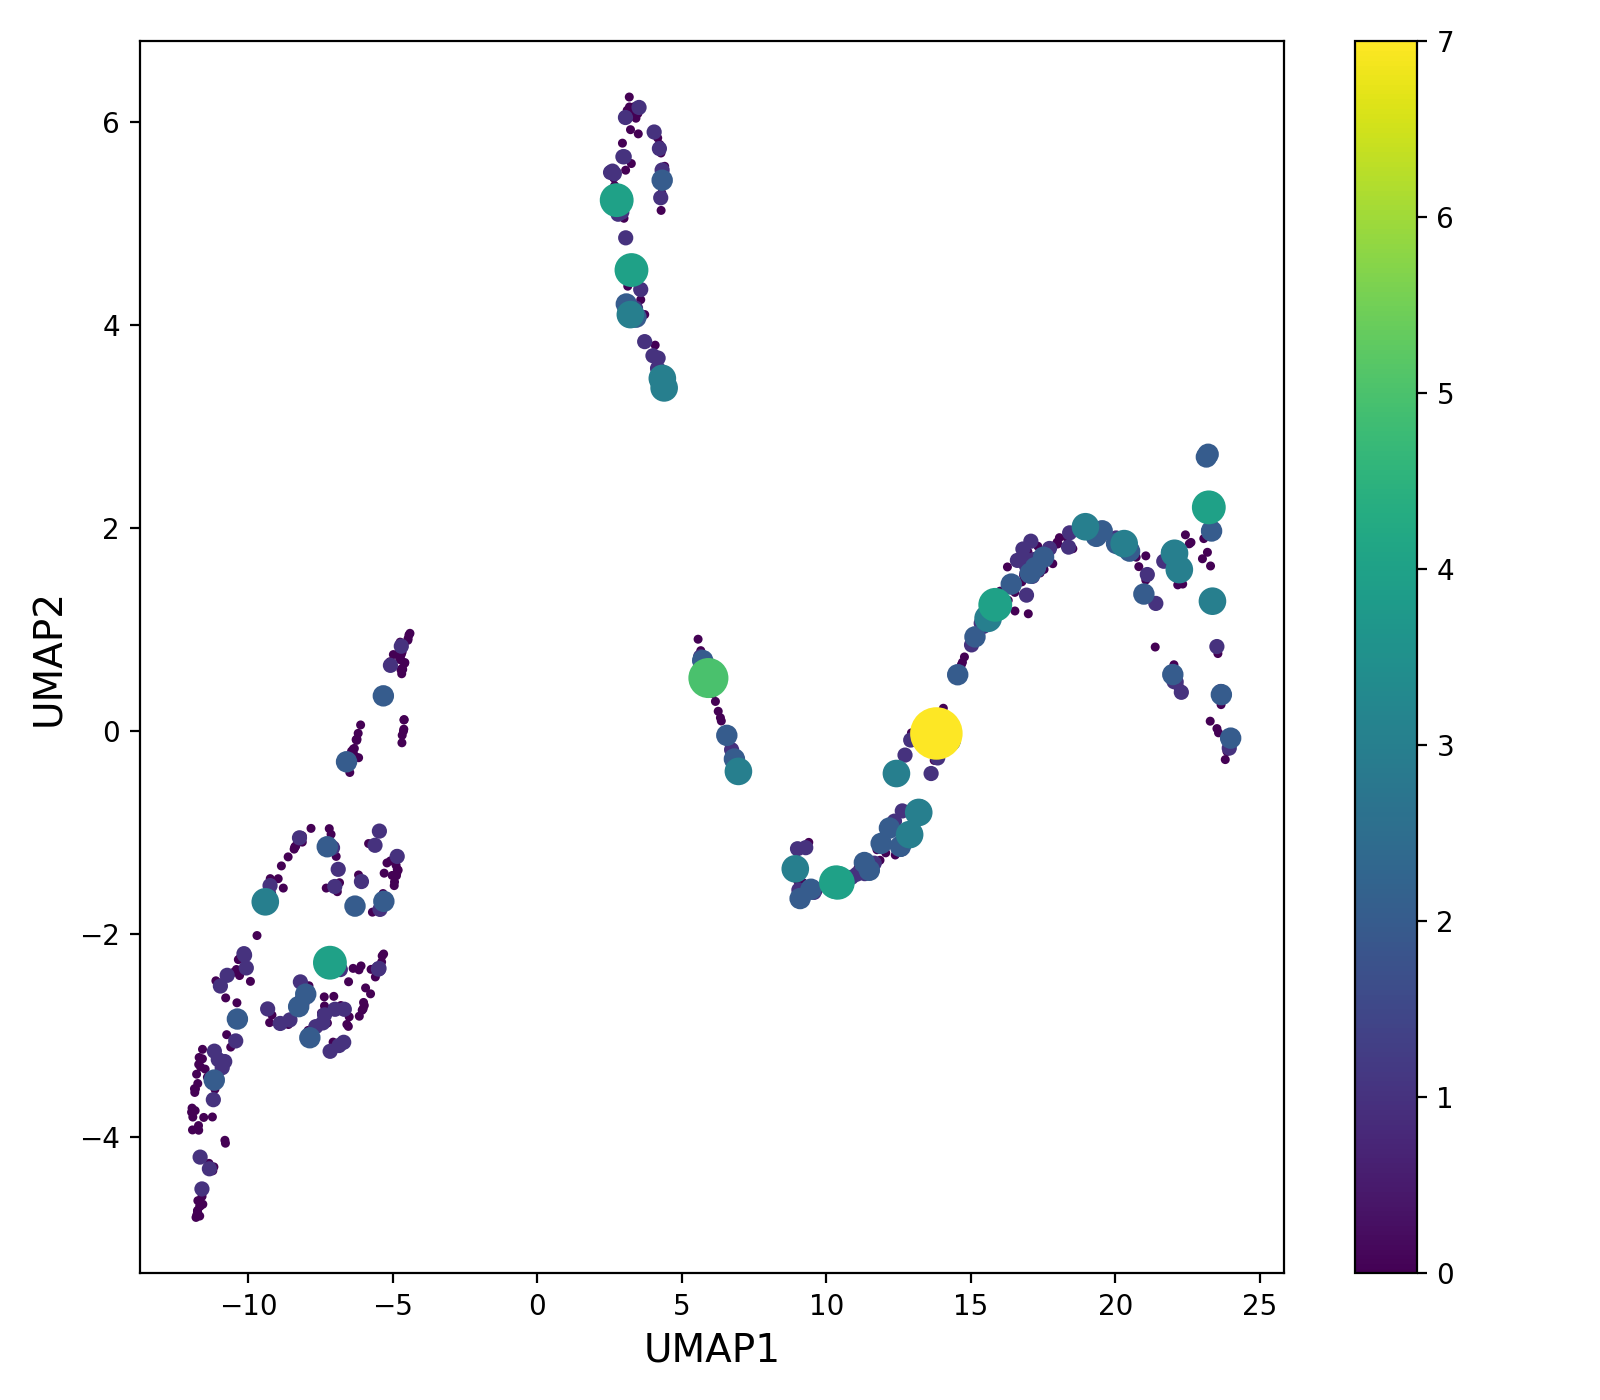

In [37]:
#pharyngeal epithelia (gexplore)
gene_names = ['F41E6.1', 'F30H5.3', 'eat-5', 'F52G3.5', 'M02G9.2', 'M02G9.3', 'K08D12.8', 'cht-2', 'M153.3',
              'F53B3.3', 'D1007.13', 'ZK262.3', 'pqn-2', 'chs-2', 'hpo-26', 'best-1', 'abu-1', 'C30A5.10',
              'nas-15', 'R11G1.2', 'delm-1', 'ttr-22', 'T24C12.4', 'scl-10', 'R11G11.6', 'T28C12.6', 'pqn-10',
              'C34B7.1', 'lagr-1', 'C03F11.2', 'C08B6.4', 'F01G10.6', 'F31D4.8', 'T23G5.3', 'T05H4.7', 'ZK662.2',
              'F07H5.6', 'nsbp-10', 'otpl-7', 'ZK262.2', 'C17B7.14', 'F49E10.2', 'gon-2', 'delm-2', 'ttr-28',
              'T14E8.4', 'ora-1', 'F52A8.3']

#have_gene_arr = []
have_gene_sum = numpy.zeros(peak_data_array.shape[0])
for idx, gname in enumerate(gene_names):
    try:
        have_gene_idx = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True, 
                                       dist_threshold=1200, gene_end_threshold=600)
    except KeyError:
        continue
    have_gene_sum[have_gene_idx] += 1

plot_order = numpy.argsort(have_gene_sum)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,7))
s = axes.scatter(doctopic_peaks_umap2_res[plot_order, 0], 
                 doctopic_peaks_umap2_res[plot_order, 1], 
                 c=have_gene_sum[plot_order],
                 cmap='viridis',
                 s=5*(have_gene_sum[plot_order] + 1)**2)

axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
cbar = fig.colorbar(s)
#cbar.ax.set_yticklabels(gene_names, fontsize=10)
fig.tight_layout()

['chrII', 6758884, 6760385, 'F41G3.2', '0', '+']
[]
[]
['chrII', 8736725, 8737556, 'T01B7.8', '0', '-']
[]
[]
['chrII', 11558714, 11564227, 'F54D5.15', '0', '-']
[['chrII' '11561796' '11562196' 'name']]
[-2031]
['chrX', 7503822, 7506633, 'lgc-11', '0', '-']
[['chrX' '7506428' '7506928' 'name']]
[295]
['chrII', 3727689, 3729835, 'C46E10.9', '0', '-']
[]
[]
['chrII', 5100411, 5101801, 'C04G6.7', '0', '-']
[]
[]
['chrV', 1989475, 1992918, 'tnt-4', '0', '-']
[]
[]
['chrIV', 5567019, 5574133, 'T12E12.6', '0', '-']
[]
[]
['chrI', 14331084, 14339831, 'F49B2.6', '0', '+']
[['chrI' '14339633' '14339834' 'name']
 ['chrI' '14340126' '14340709' 'name']]
[-8549 -9042]
['chrI', 13508784, 13512026, 'Y87G2A.19', '0', '+']
[['chrI' '13508195' '13508416' 'name']
 ['chrI' '13508523' '13509033' 'name']
 ['chrI' '13509613' '13510015' 'name']]
[ 589  261 -829]
['chrIII', 378003, 381298, 'gsto-3', '0', '-']
[['chrIII' '382203' '382486' 'name']]
[1188]
['chrX', 12468060, 12475348, 'myo-2', '0', '+']
[['chrX' 

<IPython.core.display.Javascript object>


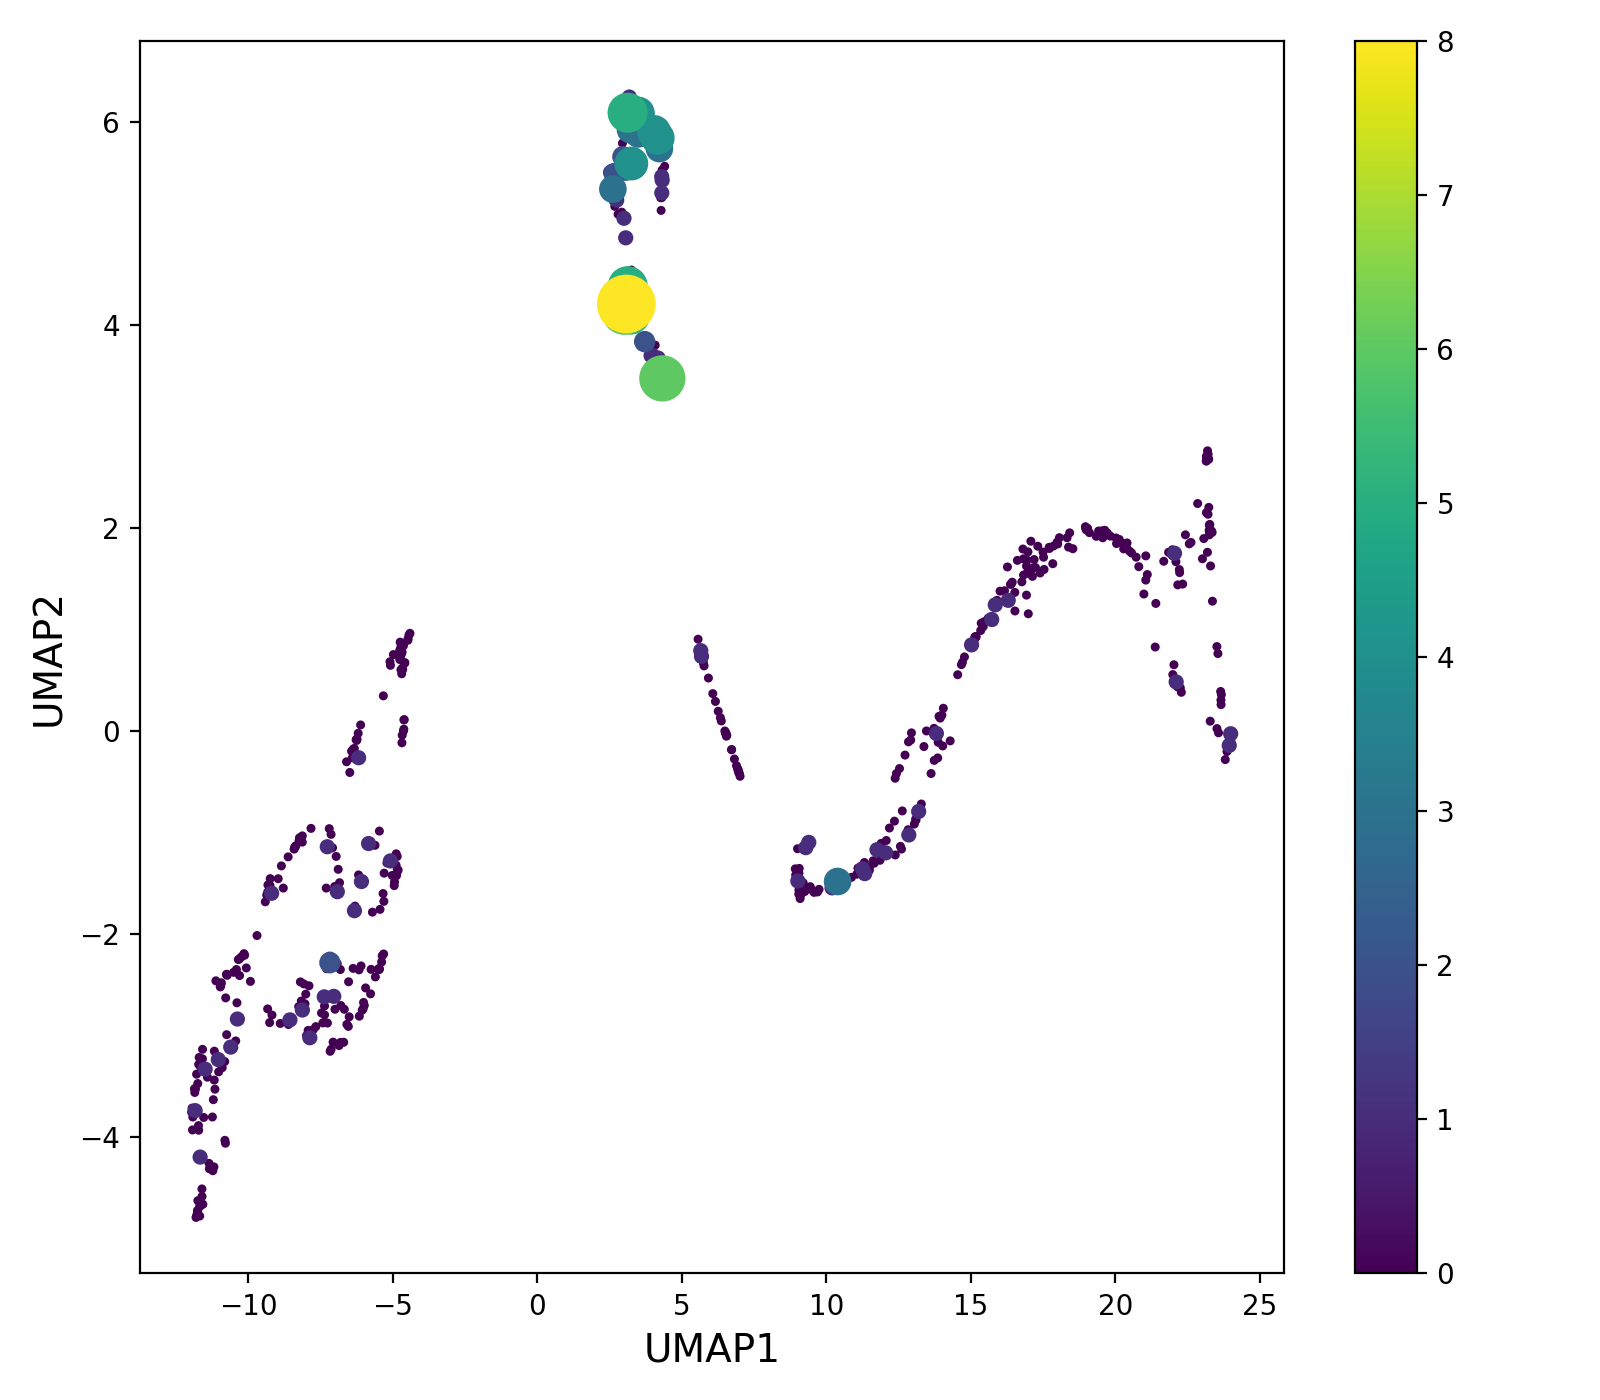

In [38]:
#pharyngeal muscle (gexplore)
gene_names = ['F41G3.2', 'T01B7.8', 'F54D5.15', 'lgc-11', 'C46E10.9', 'C04G6.7', 'tnt-4', 'T12E12.6', 'F49B2.6',
              'Y87G2A.19', 'gsto-3', 'myo-2', 'math-50', 'F14H12.3', 'ceh-22', 'math-49', 'ZC84.6', 'W10C8.4',
              'R13H4.8', 'tnc-2', 'tni-4', 'eyg-1', 'C53C9.2', 'K07G5.4', 'F13H10.5', 'T28B8.3', 'C27A2.5',
              'hsp-12.2', 'pqn-54', 'pqn-29', 'myo-1', 'cpn-4', 'F45B8.3', 'F41G3.3', 'T20B6.3', 'myo-5']

#have_gene_arr = []
have_gene_sum = numpy.zeros(peak_data_array.shape[0])
for idx, gname in enumerate(gene_names):
    try:
        have_gene_idx = get_gene_cells(gname, orig_peak_row_headers, orig_peak_data_array_filtered, verbose=True, 
                                       dist_threshold=1200, gene_end_threshold=600)
    except KeyError:
        continue
    have_gene_sum[have_gene_idx] += 1

plot_order = numpy.argsort(have_gene_sum)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,7))
s = axes.scatter(doctopic_peaks_umap2_res[plot_order, 0], 
                 doctopic_peaks_umap2_res[plot_order, 1], 
                 c=have_gene_sum[plot_order],
                 cmap='viridis',
                 s=5*(have_gene_sum[plot_order] + 1)**2)

axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
cbar = fig.colorbar(s)
#cbar.ax.set_yticklabels(gene_names, fontsize=10)
fig.tight_layout()

## Construct an AnnData object and save it in loom format

In [14]:
def add_lda_result_to_anndata_obj(anndata_obj, lda_base, lda_cellnames, lda_peak_bed):

    filt_cellnames = numpy.loadtxt(lda_cellnames, dtype=object)[:,0]
    filt_cellnames_set = set(filt_cellnames)
    filt_cellnames_map = [(True, idx, numpy.where(filt_cellnames == elt)[0][0])
                          if elt in filt_cellnames_set else (False, idx, numpy.nan)
                          for idx, elt in enumerate(anndata_obj.obs.index.values)]
    unfilt_cellnames_idx, filt_cellnames_idx = [list(idx_tuple) for idx_tuple in zip(*[(elt[1], elt[2]) for elt in filt_cellnames_map if elt[0] is True])]
    anndata_obj.obs['lda_cell'] = [elt[0] for elt in filt_cellnames_map]

    theta = numpy.loadtxt(lda_base + '.theta', delimiter=',', dtype=float)
    unfiltered_theta = numpy.ones((len(filt_cellnames_map), theta.shape[1])) * numpy.nan
    unfiltered_theta[unfilt_cellnames_idx] = theta[filt_cellnames_idx]
    anndata_obj.obsm['lda_theta'] = unfiltered_theta

    col_means = numpy.mean(theta.T, axis=0)
    theta_norm = theta.T - col_means
    l2_for_norm = (theta_norm ** 2).sum(axis=0).flatten() ** 0.5
    theta_norm /= l2_for_norm
    theta_norm = theta_norm.T
    unfiltered_theta_norm = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_theta_norm[unfilt_cellnames_idx] = theta_norm[filt_cellnames_idx]
    anndata_obj.obsm['lda_theta_norm'] = unfiltered_theta_norm

    doctopic = numpy.loadtxt(lda_base + '.docTopic', delimiter=',', dtype=float)
    unfiltered_doctopic = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_doctopic[unfilt_cellnames_idx] = doctopic[filt_cellnames_idx]
    anndata_obj.obsm['lda_doctopic'] = unfiltered_doctopic

    doctopic_frac = (doctopic.T/doctopic.sum(axis=1)).T
    unfiltered_doctopic_frac = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_doctopic_frac[unfilt_cellnames_idx] = doctopic_frac[filt_cellnames_idx]
    anndata_obj.obsm['lda_doctopic_frac'] = unfiltered_doctopic_frac

    filt_peaks = numpy.loadtxt(lda_peak_bed, dtype=object)
    filt_peaks_str = ['{!s}\t{!s}\t{!s}'.format(*filt_peaks[idx,:3])
                      for idx in range(filt_peaks.shape[0])]
    filt_peaks_set = set(filt_peaks_str)
    unfilt_peaks_str = ['{!s}\t{!s}\t{!s}'.format(anndata_obj.var['chr'][idx],
                                                  anndata_obj.var['start'][idx],
                                                  anndata_obj.var['stop'][idx])
                        for idx in range(anndata_obj.var.shape[0])]
    filt_peaks_map = [(True, idx, filt_peaks_str.index(elt))
                      if elt in filt_peaks_set else (False, idx, numpy.nan)
                      for idx, elt in enumerate(unfilt_peaks_str)]
    unfilt_peaks_idx, filt_peaks_idx = [list(idx_tuple) for idx_tuple in zip(*[(elt[1], elt[2]) for elt in filt_peaks_map if elt[0] is True])]
    anndata_obj.var['lda_peak'] = [elt[0] for elt in filt_peaks_map]

    phi = numpy.loadtxt(lda_base + '.phi', delimiter=',', dtype=float).T
    unfiltered_phi = numpy.ones((anndata_obj.var.shape[0], phi.shape[1])) * numpy.nan
    unfiltered_phi[unfilt_peaks_idx] = phi[filt_peaks_idx]
    anndata_obj.varm['lda_phi'] = unfiltered_phi

    wordtopic = numpy.loadtxt(lda_base + '.wordTopic', delimiter=',', dtype=float)
    unfiltered_wordtopic = numpy.ones(unfiltered_phi.shape) * numpy.nan
    unfiltered_wordtopic[unfilt_peaks_idx] = wordtopic[filt_peaks_idx]
    anndata_obj.varm['lda_wordtopic'] = unfiltered_wordtopic

    wordtopic_frac = (wordtopic.T/wordtopic.sum(axis=1)).T
    unfiltered_wordtopic_frac = numpy.ones(unfiltered_phi.shape) * numpy.nan
    unfiltered_wordtopic_frac[unfilt_peaks_idx] = wordtopic_frac[filt_peaks_idx]
    anndata_obj.varm['lda_wordtopic_frac'] = unfiltered_wordtopic_frac

    return

def read_in_bow(bow_path, cell_names_path, feature_info_path, gene_name_map=None):
    try:
        bow_data_sparse = numpy.loadtxt(bow_path, dtype=int, skiprows=3)
    except StopIteration:
        #probably NFS lag; just wait a few seconds and try again
        time.sleep(10)
        bow_data_sparse = numpy.loadtxt(bow_path, dtype=int, skiprows=3)
    open_func, open_mode = (gzip.open, 'rb') if bow_path.endswith('.gz') else (open, 'rb')
    with open_func(bow_path, open_mode) as lines_in:
        cellnum = int(lines_in.readline().decode().strip())
        featnum = int(lines_in.readline().decode().strip())
    bow_data = sps.csr_matrix((bow_data_sparse[:,2],
                               (bow_data_sparse[:,0] - 1,
                                bow_data_sparse[:,1] - 1)),
                              shape=(cellnum, featnum))

    try:
        cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]
    except StopIteration:
        time.sleep(10)
        cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]

    try:
        feature_info_bed = numpy.loadtxt(feature_info_path, dtype=object)
    except StopIteration:
        time.sleep(10)
        feature_info_bed = numpy.loadtxt(feature_info_path, dtype=object)
    col_names = ['chr', 'start', 'stop', 'name', 'score', 'strand']
    num_cols = feature_info_bed.shape[1]
    if num_cols <= 6:
        col_names = col_names[:num_cols]
    else:
        col_names = col_names + list(numpy.arange(6, num_cols).astype(str))

    anndata_obj = anndata.AnnData(X=bow_data,
                                  obs=pandas.DataFrame(index=cell_names),
                                  var=pandas.DataFrame(data=feature_info_bed,
                                                       columns=col_names))
    if gene_name_map is not None:
        gene_name_map = numpy.loadtxt(gene_name_map, delimiter='\t', dtype=object)
        gene_name_map = dict([gene_name_map[idx] for idx in range(gene_name_map.shape[0])])
        anndata_obj.var['common_name'] = [gene_name_map.get(elt, elt) for elt in anndata_obj.var.name]

    return anndata_obj

In [15]:
#make and save anndata object
import anndata
import pandas

#first, read in the original BOW data (the unfiltered data)
orig_peaktable_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.bow'
orig_cell_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.zeros_filtered.indextable.txt'
orig_peak_names_path = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/../all_peaks.merged.allcells.zeros_filtered.bed'

anndata_obj = read_in_bow(orig_peaktable_path, orig_cell_names_path, orig_peak_names_path)

#next, add the LDA results, taking into account that some of the cells/peaks were filtered out before running LDA
lda_base = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/0000_topics5_alpha3.000_beta2000.000/topic_mode'
lda_cellnames = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/filtered_peaks_iqr4.0_low_cells.indextable.txt'
lda_peak_bed = '../tissue_analysis/pharynx/topic_analysis/rank_peaks/filtered_peaks_iqr4.0_low_cells.extra_cols.bed'
add_lda_result_to_anndata_obj(anndata_obj, lda_base, lda_cellnames, lda_peak_bed)

print(anndata_obj)

src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Transforming to str index.


AnnData object with n_obs × n_vars = 616 × 10946 
    obs: 'lda_cell'
    var: 'chr', 'start', 'stop', 'lda_peak'
    obsm: 'lda_theta', 'lda_theta_norm', 'lda_doctopic', 'lda_doctopic_frac'
    varm: 'lda_phi', 'lda_wordtopic', 'lda_wordtopic_frac'


In [16]:
umap_to_add = numpy.zeros((anndata_obj.shape[0], doctopic_peaks_umap2_res.shape[1])) * numpy.nan
anndata_idx = numpy.where(anndata_obj.obs.lda_cell)[0]
umap_idx = [numpy.where(cell_names == elt)[0][0] for elt in anndata_obj.obs[anndata_obj.obs.lda_cell].index.values]
umap_to_add[anndata_idx] = doctopic_peaks_umap2_res[umap_idx]
print(umap_to_add.shape)
anndata_obj.obsm['umap2'] = umap_to_add

umap_to_add = numpy.zeros((anndata_obj.shape[0], doctopic_peaks_umap3_res.shape[1])) * numpy.nan
anndata_idx = numpy.where(anndata_obj.obs.lda_cell)[0]
umap_idx = [numpy.where(cell_names == elt)[0][0] for elt in anndata_obj.obs[anndata_obj.obs.lda_cell].index.values]
umap_to_add[anndata_idx] = doctopic_peaks_umap3_res[umap_idx]
print(umap_to_add.shape)
anndata_obj.obsm['umap3'] = umap_to_add

(616, 2)
(616, 3)


In [17]:
anndata_obj.write_loom('../tissue_analysis/pharynx/topic_analysis/rank_peaks/refinement_lda_results.loom', 
                       write_obsm_varm=True)